# Data Mining Project - To Loan or Not to Loan

## Table of contents

1. [Introduction](#Introduction)

2. [Required libraries](#Required-libraries)

4. [The Problem](#Problem)

5. [Initialization / Preprocessing](#Initialization-/-Preprocessing)

6. [Plots](#Plots)

7. [Exploratory analysis](#Step-4:-Exploratory-analysis)

8. [Classification](#Step-5:-Classification)

    - [Cross-validation](#Cross-validation)

    - [Parameter tuning](#Parameter-tuning)

9. [Conclusions](#Conclusions)

## Introduction

In this project, we intend to use Supervised Machine Learning methods to predict whether a loan should be refused or not. In order to do this, we make use of a [Bank Loan dataset](https://www.kaggle.com/c/to-loan-or-not-to-loan-that-is-the-question-ac2122) from a Kaggle competition.

## Required libraries

(mudar isto depois)

- **numpy** - provides support for large multidimensional arrays and matrices along with a collection of high-level mathematical functions to execute these functions swiftly.
- **pandas** - enables the provision of easy data structure and quicker data analysis for Python. For operations like data analysis and modelling, Pandas makes it possible to carry these out without needing to switch to more domain-specific language.
- **scikit-learn** - can be effectively used for a variety of applications which include classification, regression, clustering, model selection, naive Bayes’, grade boosting, K-means, and preprocessing.
- **matplotlib** - widely used for publication of quality figures in a variety of hard copy formats and interactive environments across platforms. Used to design charts, graphs, pie charts, scatterplots, histograms, error charts, etc.
- **seaborn** - visualisation of statistical models like heat maps.
- **category_encoders** - set of scikit transformers for encoding categorical variables into numeric with different techniques.
- **tabulate** - preety-print tabular data.
- **imblearn** - deals with imbalanced datasets

## Initialization / Preprocessing

### Import modules

In [1]:
import time
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from scipy import stats
from mpl_toolkits import mplot3d

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import ExhaustiveFeatureSelector

from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.manifold import TSNE

from imblearn.over_sampling import SMOTE

from tabulate import tabulate



## Cleaning Data

Before working with the data, it needs to be cleaned. To do that, various pandas functions are used.

### Useful functions

This a helper function to scale numerical values to a 0 to 1 scale.

In [2]:
def scale_min_max(train, test=[]):
    scaler = MinMaxScaler()
    scaler.fit(train)
    train = scaler.transform(train)
    if(len(test) == 0): return train
    test = scaler.transform(test)
    return (train, test)

### Accounts details data

The first csv to be cleaned will be "account details". 
The starting value to check is the different types of account frequency. 

In [3]:
df_accounts = pd.read_csv('datasets/account.csv', sep=';')

print('Frequency unique values:', df_accounts['frequency'].unique())

Frequency unique values: ['monthly issuance' 'issuance after transaction' 'weekly issuance']


In [4]:
df_accounts['frequency'] = df_accounts['frequency'].map({"monthly issuance": 1, "issuance after transaction": 12, "weekly issuance": 4})

After checking the existing 'frequencies', it is possible to enumerate all: 'monthly issuance' 'issuance after transaction' 'weekly issuance'.  
Since there are only 3 types it is possible to map them manually, replacing 'monthly issuance' with 1, 'issuance after transaction' with 12 and 'weekly issuance' with 4.


After a quick glance at the 'date' column it is possible to check the date format is not the standard date format. Since pandas already supports **datetime** format, it will simplify future operations if the date column is changed.


In [5]:
# Formatting date column

df_accounts['date'] = '19' + df_accounts['date'].astype('str')
df_accounts['date'] = pd.to_datetime(df_accounts.date, format="%Y%m%d")
df_accounts = df_accounts.rename(columns={"date": "account_date"})

df_accounts.to_csv('clean_datasets/account.csv', index=False)
df_accounts.head()

account_id  district_id  frequency account_date
0         576           55          1   1993-01-01
1        3818           74          1   1993-01-01
2         704           55          1   1993-01-01
3        2378           16          1   1993-01-01
4        2632           24          1   1993-01-02

After doing this, the **head** of the dataset is printed to ensure every modification to the dataframe was successful.


### Client details

After dealing with the account data, the next step is the client data.
The project specification indicates that the birthdate and the gender of the clients follow a pattern as followed:

**birth_number** 
 - YYMMDD format for Men
 - YYMM+50DD format for Women

With this in mind it is possible to start working in the 'birth_number' column to try to extract two new columns from it.



In [6]:
df_clients = pd.read_csv('datasets/client.csv', sep=';')
df_clients.head()

client_id  birth_number  district_id
0          1        706213           18
1          2        450204            1
2          3        406009            1
3          4        561201            5
4          5        605703            5

#### Create column for client's sex and reformat birth date 

**birth_number** - is in the form YYMMDD for MAN, in the form YYMM+50DD for WOMAN, YYMMDD is the birth date.

In [7]:
df_clients['sex'] = df_clients['birth_number'].apply(lambda bn: "WOMAN" if ((bn/100)%100) >= 51 else "MAN")

df_clients['birth_date'] = df_clients['birth_number'].apply(lambda bn: pd.to_datetime("19" + str(bn - 5000), format="%Y%m%d") if ((bn/100)%100) >= 51 else pd.to_datetime("19" + str(bn)))

df_clients = df_clients.drop(columns=['birth_number'])
df_clients.to_csv('clean_datasets/client.csv', index=False)
df_clients.head()

client_id  district_id    sex birth_date
0          1           18  WOMAN 1970-12-13
1          2            1    MAN 1945-02-04
2          3            1  WOMAN 1940-10-09
3          4            5    MAN 1956-12-01
4          5            5  WOMAN 1960-07-03

After extracting the birth date and the gender of the client the **birth_number** column is dropped as it doesn't provide any new information and would be redundant.  
Since every other column is an *ID* of another table there is nothing to clean on those columns.



### Disposition data

Even though the **disposition data** seemed to be already clean, it was still verified.

In [8]:
df_disp = pd.read_csv('datasets/disp.csv', sep=';')
df_disp.head()

disp_id  client_id  account_id       type
0        1          1           1      OWNER
1        2          2           2      OWNER
2        3          3           2  DISPONENT
3        4          4           3      OWNER
4        5          5           3  DISPONENT

In [9]:
print('All unique Disposition types: ', df_disp['type'].unique())

All unique Disposition types:  ['OWNER' 'DISPONENT']


All clients can be either a OWNER or DISPONENT. 

In [10]:
print(df_disp["client_id"].is_unique & np.array_equal(df_disp["client_id"].values, df_clients["client_id"].values))

True


With this it is possible to claim every row is filled and all fit on of the two categories:  OWNER or DISPONENT.  
The **type** column was renamed to make it more identifiable when merging tables.

In [11]:
df_disp = df_disp.rename(columns={"type":"disp_type"})
df_disp.to_csv('clean_datasets/disp.csv', index=False)

### District data

The district table is the table with the most columns. This means it is necessary to take a more attentive look at it.

In [12]:
df_district = pd.read_csv('datasets/district.csv', sep=';')
df_district.head()

code         name            region  no. of inhabitants  \
0      1  Hl.m. Praha           Prague             1204953   
1      2      Benesov  central Bohemia               88884   
2      3       Beroun  central Bohemia               75232   
3      4       Kladno  central Bohemia              149893   
4      5        Kolin  central Bohemia               95616   

   no. of municipalities with inhabitants < 499   \
0                                              0   
1                                             80   
2                                             55   
3                                             63   
4                                             65   

   no. of municipalities with inhabitants 500-1999  \
0                                                0   
1                                               26   
2                                               26   
3                                               29   
4                                               30   

   no. of municipalities with inhabitants 2000-9999   \
0                                                  0   
1                                                  6   
2                                                  4   
3                                                  6   
4                                                  4   

   no. of municipalities with inhabitants >10000   no. of cities   \
0                                               1               1   
1                                               2               5   
2                                               1               5   
3                                               2               6   
4                                               1               6   

   ratio of urban inhabitants   average salary  unemploymant rate '95   \
0                        100.0            12541                   0.29   
1                         46.7             8507                   1.67   
2                         41.7             8980                   1.95   
3                         67.4             9753                   4.64   
4                         51.4             9307                   3.85   

   unemploymant rate '96   no. of enterpreneurs per 1000 inhabitants   \
0                    0.43                                         167   
1                    1.85                                         132   
2                    2.21                                         111   
3                    5.05                                         109   
4                    4.43                                         118   

  no. of commited crimes '95   no. of commited crimes '96   
0                       85677                        99107  
1                        2159                         2674  
2                        2824                         2813  
3                        5244                         5892  
4                        2616                         3040

In [13]:
print(len(df_district['region'].unique()), ' different regions: ', df_district['region'].unique())

8  different regions:  ['Prague' 'central Bohemia' 'south Bohemia' 'west Bohemia' 'north Bohemia'
 'east Bohemia' 'south Moravia' 'north Moravia']


In [14]:
df_district['region'] = df_district['region'].astype('category')

**Problems** - Some column names have a space at the end of the string. And 'region' column should be encoded.

In [15]:
# Using binary encoding on region column 

binary_encoder = ce.BinaryEncoder(cols=['region'],return_df=True)
df_district = binary_encoder.fit_transform(df_district)

After encoding the **region** column to turn text values into numerical ones three new columns are created to make every region as a binary number.

After doing this, every column name is striped as some of them have an aditional space at the end of the name, and that would prove harder to work with.

In [16]:
for column in df_district.columns:
    df_district = df_district.rename(columns={column : column.strip()})


df_district = df_district.drop(columns=['name'])
df_district.head()

code  region_0  region_1  region_2  region_3  no. of inhabitants  \
0     1         0         0         0         1             1204953   
1     2         0         0         1         0               88884   
2     3         0         0         1         0               75232   
3     4         0         0         1         0              149893   
4     5         0         0         1         0               95616   

   no. of municipalities with inhabitants < 499  \
0                                             0   
1                                            80   
2                                            55   
3                                            63   
4                                            65   

   no. of municipalities with inhabitants 500-1999  \
0                                                0   
1                                               26   
2                                               26   
3                                               29   
4                                               30   

   no. of municipalities with inhabitants 2000-9999  \
0                                                 0   
1                                                 6   
2                                                 4   
3                                                 6   
4                                                 4   

   no. of municipalities with inhabitants >10000  no. of cities  \
0                                              1              1   
1                                              2              5   
2                                              1              5   
3                                              2              6   
4                                              1              6   

   ratio of urban inhabitants  average salary unemploymant rate '95  \
0                       100.0           12541                  0.29   
1                        46.7            8507                  1.67   
2                        41.7            8980                  1.95   
3                        67.4            9753                  4.64   
4                        51.4            9307                  3.85   

   unemploymant rate '96  no. of enterpreneurs per 1000 inhabitants  \
0                   0.43                                        167   
1                   1.85                                        132   
2                   2.21                                        111   
3                   5.05                                        109   
4                   4.43                                        118   

  no. of commited crimes '95  no. of commited crimes '96  
0                      85677                       99107  
1                       2159                        2674  
2                       2824                        2813  
3                       5244                        5892  
4                       2616                        3040

#### Looking for Missing Values

After encoding the region column, a search for missing values is done

In [17]:
df_district.isnull().values.any()

missing = False

for column in df_district.drop(columns=['region_0', 'region_1', 'region_2', 'region_3']).columns:
    if df_district[column].isnull().values.any():
        missing = True
        break
        
if not missing:
    print("No missing values in the data frame")
else:
    print("Missing values present in data frame")

No missing values in the data frame


Now that we have verified that there are no missing values in the district dataset, we must check that every column except `region` have **numeric** values

In [18]:
columns = []
is_numeric = []

for column in df_district.drop(columns=['region_0', 'region_1', 'region_2', 'region_3']).columns:
    columns.append(column)
    is_numeric.append(np.issubdtype(df_district[column].dtype, np.number))


df = pd.DataFrame({'Column' : columns,
                   'Is All Numeric' : is_numeric})
print(tabulate(df, headers='keys', tablefmt='psql'))

+----+--------------------------------------------------+------------------+
|    | Column                                           | Is All Numeric   |
|----+--------------------------------------------------+------------------|
|  0 | code                                             | True             |
|  1 | no. of inhabitants                               | True             |
|  2 | no. of municipalities with inhabitants < 499     | True             |
|  3 | no. of municipalities with inhabitants 500-1999  | True             |
|  4 | no. of municipalities with inhabitants 2000-9999 | True             |
|  5 | no. of municipalities with inhabitants >10000    | True             |
|  6 | no. of cities                                    | True             |
|  7 | ratio of urban inhabitants                       | True             |
|  8 | average salary                                   | True             |
|  9 | unemploymant rate '95                            | False            |

It seems that two columns that should be numeric **have some not numeric values**. It could be that some values are badly formatted numbers or invalid values that make this entry count as a missing value.

In [19]:
df_not_numeric = pd.DataFrame({"unemploymant rate '95":df_district["unemploymant rate '95"].values, "no. of commited crimes '95": df_district["no. of commited crimes '95"].values})

df_not_numeric["not_numeric1"] = df_not_numeric["unemploymant rate '95"].apply(lambda x: x if not x.replace('.', '', 1).isdigit() else "")
df_not_numeric["not_numeric2"] = df_not_numeric["no. of commited crimes '95"].apply(lambda x: x if not x.replace('.', '', 1).isdigit() else "")

print("Not numeric values in 'unemploymant rate '95': ", set(df_not_numeric["not_numeric1"].unique()) - set(['']))
print("Not numeric values in 'no. of commited crimes '95': ",set(df_not_numeric["not_numeric2"].unique()) - set(['']))

Not numeric values in 'unemploymant rate '95':  {'?'}
Not numeric values in 'no. of commited crimes '95':  {'?'}


As there are values in these columns marked as '?', they are assumed as **missing values** and should be removed, for a correct missing values handling later on.

In [20]:
df_district["unemploymant rate '95"] = df_district["unemploymant rate '95"].apply(lambda x: x if not x == '?' else None)
df_district["no. of commited crimes '95"] = df_district["no. of commited crimes '95"].apply(lambda x: x if not x == '?' else None)

print("Missing values in 'unemploymant rate '95':", df_district["unemploymant rate '95"].isnull().values.sum())
print("Missing values in 'no. of commited crimes '95': ", df_district["no. of commited crimes '95"].isnull().values.sum())

Missing values in 'unemploymant rate '95': 1
Missing values in 'no. of commited crimes '95':  1


#### Handling Missing Values

In this data table there are a couple of values missing from two columns. As most classification algorithms do not work with missing values, and dropping the rows is not a viable option since we need the data from all districts to join correctly with all the other data, **data imputation** should be used.

In this case, a **K-Nearest-Neighboor Imputer** will be used.

In [21]:
imputer = KNNImputer(n_neighbors=5, weights="uniform")

df_district = pd.DataFrame(imputer.fit_transform(df_district), columns = df_district.columns)

for column in (set(df_district.columns) - set(("ratio of urban inhabitants", "unemploymant rate '95", "unemploymant rate '96"))):
    df_district[column] = df_district[column].astype('int')

In [22]:
df_district.to_csv('clean_datasets/district.csv', index=False)

### Loan Data

Since the loan data is divided into two different tables, the test and the train tables, it is necessary to first merge the two so any changes made to one is also made to the other.

In [23]:
df_loan_train = pd.read_csv('datasets/loan_train.csv', sep=";")
df_loan_test = pd.read_csv('datasets/loan_test.csv', sep=";")

In [24]:
df_loans = pd.concat([df_loan_train.drop(columns=["status"]), df_loan_test.drop(columns=["status"])])

df_loans.head()

loan_id  account_id    date  amount  duration  payments
0     5314        1787  930705   96396        12      8033
1     5316        1801  930711  165960        36      4610
2     6863        9188  930728  127080        60      2118
3     5325        1843  930803  105804        36      2939
4     7240       11013  930906  274740        60      4579

#### Loan dates from number to datetime format

The loans data suffer from the same issue birthdates had on the clients data, it is not in a format accepted by the **datetime** pandas' object type. This needs to be fixed for simpler date handeling.

In [25]:
df_loans.date = df_loans.date.apply(lambda x: pd.to_datetime("19" + str(x), format="%Y%m%d"))
df_loans = df_loans.rename(columns={"date": "loan_date"})
df_loans.loan_date = df_loans.loan_date.astype('datetime64[ns]')
df_loans.head()

loan_id  account_id  loan_date  amount  duration  payments
0     5314        1787 1993-07-05   96396        12      8033
1     5316        1801 1993-07-11  165960        36      4610
2     6863        9188 1993-07-28  127080        60      2118
3     5325        1843 1993-08-03  105804        36      2939
4     7240       11013 1993-09-06  274740        60      4579

The main goal of this project is to predict when to accept or deny a loan. However the starting positive class is accepting the loan which is not what we want. A bank would rather deny a loan that would be paid than to accept a loan that is not paid.  
With this in mind it is necessary to invert the status column so that denying the loan is considered the positive class. 

In [26]:
# Changing status column to 0 (negative class) and 1 (positive class) and saving the files

df_loans_train_clean = df_loans[df_loans['loan_id'].isin(df_loan_train['loan_id'].values)]
df_loans_train_clean['status'] = df_loan_train['status']
df_loans_train_clean['status'] = df_loans_train_clean['status'].apply(lambda x: 0 if x == 1 else 1)
df_loans_train_clean.to_csv('clean_datasets/loans_train.csv', index=False)

df_loans_test_clean = df_loans[df_loans['loan_id'].isin(df_loan_test['loan_id'].values)]
df_loans_test_clean['status'] = df_loan_test['status']
df_loans_test_clean['status'] = df_loans_test_clean['status'].apply(lambda x: 0 if x == 1 else 1)
df_loans_test_clean.to_csv('clean_datasets/loans_test.csv', index=False)

<ipython-input-26-341651fd7a87>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loans_train_clean['status'] = df_loan_train['status']
<ipython-input-26-341651fd7a87>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loans_train_clean['status'] = df_loans_train_clean['status'].apply(lambda x: 0 if x == 1 else 1)
<ipython-input-26-341651fd7a87>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

### Cards Data

In [27]:
df_card_train = pd.read_csv('datasets/card_train.csv', sep=";")
df_card_test = pd.read_csv('datasets/card_test.csv', sep=";")

In [28]:
# Concatenating train and test data. This is done so all the data is preparated together and split again in the end
df_cards = pd.concat([df_card_train, df_card_test])

df_cards.head()

card_id  disp_id     type  issued
0     1005     9285  classic  931107
1      104      588  classic  940119
2      747     4915  classic  940205
3       70      439  classic  940208
4      577     3687  classic  940215

#### Card issuance dates from number to datetime format

Just like the two last tables, this one also needs to have the date column reformated.

In [29]:
df_cards.issued = df_cards.issued.apply(lambda x: pd.to_datetime("19" + str(x), format="%Y%m%d"))
df_cards = df_cards.rename(columns={"issued": "card_date"})
df_cards.card_date = df_cards.card_date.astype('datetime64[ns]')
df_cards.head()

card_id  disp_id     type  card_date
0     1005     9285  classic 1993-11-07
1      104      588  classic 1994-01-19
2      747     4915  classic 1994-02-05
3       70      439  classic 1994-02-08
4      577     3687  classic 1994-02-15

#### Replace 'type' column categories by numerical values (junior < classic < gold)

In [30]:
df_cards['type'].unique()

array(['classic', 'junior', 'gold'], dtype=object)

According to our data, client cards can be of one of three different types: **Junior**, **Classic** and **Gold**.
This is useful to know if the owner of the card is either a teenager/young adult, a normal user or a long-term client.
Following our business knowledge of this specific domain, a Junior client should be classified lower than the average client. As well as a Gold client should be classified higher.
So we chose to convert the types to -10, 0 and 10, correspondently. This eliminates the presence of categorical data and possibly improves the data for the models.

In [31]:
type_values = {"junior": -10, "classic": 0, "gold": 10}
df_cards['type'] = df_cards['type'].apply(lambda x: type_values[x])
df_cards.head()

card_id  disp_id  type  card_date
0     1005     9285     0 1993-11-07
1      104      588     0 1994-01-19
2      747     4915     0 1994-02-05
3       70      439     0 1994-02-08
4      577     3687     0 1994-02-15

In [32]:
# Saving to files

df_card_train_clean = df_cards[df_cards['card_id'].isin(df_card_train['card_id'].values)]
df_card_train_clean = df_card_train_clean.rename(columns={"type":"card_type"})
df_card_train_clean.to_csv('clean_datasets/cards_train.csv', index=False)

df_card_test_clean = df_cards[df_cards['card_id'].isin(df_card_test['card_id'].values)]
df_card_test_clean = df_card_test_clean.rename(columns={"type":"card_type"})
df_card_test_clean.to_csv('clean_datasets/cards_test.csv', index=False)

### Transactions

For the transactions to be ready to be used many changes need to be made.

In [33]:
df_trans_train = pd.read_csv("datasets/trans_train.csv", sep=";")
df_trans_test = pd.read_csv("datasets/trans_test.csv", sep=";")

print(len(df_trans_test["trans_id"]))

print(len(set(df_trans_test["trans_id"].values) - set(df_trans_train["trans_id"].values)))

30200
30200


C:\Users\Utilizador\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


As there are no duplicate loan IDs in the test and train so we can merge them together to clean the two portions of the data together.

Since there are almost no filled values in the `account`, `k_symbol` and `bank` columns, these will be dropped.

In [34]:
df_trans_merge = pd.concat([df_trans_test, df_trans_train])
df_trans_merge.drop(columns=["account", "k_symbol", "bank"], inplace=True)

df_trans_merge.head()

trans_id  account_id    date        type           operation   amount  \
0      6145          25  960728      credit      credit in cash    900.0   
1      6456          25  960827      credit      credit in cash  15800.0   
2      6150          25  960903      credit      credit in cash  13067.0   
3      6171          25  960905      credit      credit in cash  42054.0   
4      6457          25  960906  withdrawal  withdrawal in cash  36000.0   

   balance  
0    900.0  
1  16700.0  
2  29767.0  
3  71821.0  
4  77580.0

To start working on the date we need to make it a panda datetime object.

In [35]:
df_trans_merge.date = df_trans_merge.date.apply(lambda x: pd.to_datetime("19" + str(x), format="%Y%m%d"))

In [36]:
df_trans_train =  df_trans_merge[df_trans_merge['account_id'].isin(df_trans_train['account_id'].values)]   
df_trans_test = df_trans_merge[df_trans_merge['account_id'].isin(df_trans_test['account_id'].values)]  
df_trans_train.to_csv('clean_datasets/trans_train.csv', index=False)
df_trans_test.to_csv('clean_datasets/trans_test.csv', index=False)

Some more changes will be done later, however these changes are currently enough to analyse the data to then make more significant changes.

## Data Analysis

### Account details

After having cleaned the data, it's possible to start analysing it.  
The first table to be analysed is the `account details`.  
</br>
To have a better idea of the time frame, we need to check the first and last date present in the **date** column

In [37]:
print("First date: " + df_accounts["account_date"].min().strftime("%d/%m/%Y"))
print("Last date: " + df_accounts["account_date"].max().strftime("%d/%m/%Y"))

First date: 01/01/1993
Last date: 29/12/1997


After obtaining the time frame the accounts were created we can make a graph using a one year interval as the data only covers 5 years of the bank's history.

Text(0.5, 1.0, 'Accounts Per Year')

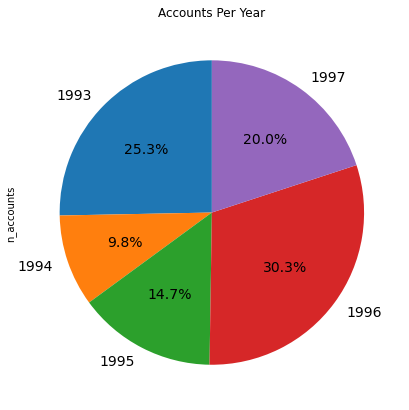

In [38]:
maskYear1993 = df_accounts["account_date"].dt.year == 1993
year1993 = df_accounts[maskYear1993]

maskYear1994 = df_accounts["account_date"].dt.year == 1994
year1994 = df_accounts[maskYear1994]

maskYear1995 = df_accounts["account_date"].dt.year == 1995
year1995 = df_accounts[maskYear1995]

maskYear1996 = df_accounts["account_date"].dt.year == 1996
year1996 = df_accounts[maskYear1996]

maskYear1997 = df_accounts["account_date"].dt.year == 1997
year1997 = df_accounts[maskYear1997]

raw_data = {'year': [1993, 1994, 1995, 1996, 1997],
            'n_accounts': [year1993.size, year1994.size, year1995.size, year1996.size, year1997.size]}


df = pd.DataFrame(raw_data, columns = ['year', 'n_accounts'])

fig,ax = plt.subplots(facecolor="#ffffff", figsize=(7,7))

df.plot(kind='pie', y = 'n_accounts', ax=ax, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=df['year'], legend = False, fontsize=14).set_title("Accounts Per Year")

From the previous pie chart it is possible to see that the accounts created on the years 1993 and 1996 make up over 50% of the accounts in the dataset.  
After seeing this, the frequency of the issurance each year should also be explored. 

In [39]:
year1993['freq'] = year1993.groupby('frequency')['frequency'].transform('count')
year1993["account_date"] = 1993
year1993 = year1993.drop(columns=["account_id","district_id"], errors='ignore')

year1994['freq'] = year1994.groupby('frequency')['frequency'].transform('count')
year1994["account_date"] = 1994
year1994 = year1994.drop(columns=["account_id","district_id"], errors='ignore')

year1995['freq'] = year1995.groupby('frequency')['frequency'].transform('count')
year1995["account_date"] = 1995
year1995 = year1995.drop(columns=["account_id","district_id"], errors='ignore')

year1996['freq'] = year1996.groupby('frequency')['frequency'].transform('count')
year1996["account_date"] = 1996
year1996 = year1996.drop(columns=["account_id","district_id"], errors='ignore')

year1997['freq'] = year1997.groupby('frequency')['frequency'].transform('count')
year1997["account_date"] = 1997
year1997 = year1997.drop(columns=["account_id","district_id"], errors='ignore')

years = year1993.append(year1994).append(year1995).append(year1996).append(year1997)

<ipython-input-39-037e99eb5b88>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year1993['freq'] = year1993.groupby('frequency')['frequency'].transform('count')
<ipython-input-39-037e99eb5b88>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year1993["account_date"] = 1993
<ipython-input-39-037e99eb5b88>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

Text(0.5, 1.0, 'Account Frequency Per Year')

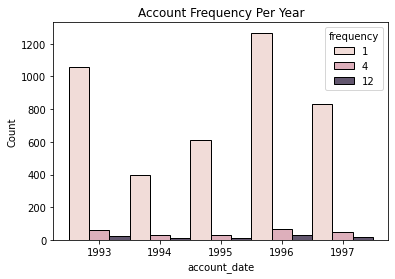

In [40]:
years["account_date"] = years["account_date"].astype("string")
sb.histplot(years,x="account_date", hue="frequency", multiple="dodge").set_title("Account Frequency Per Year")

After analysing the graph, we can conclude that, although the number of accounts fluctuated each year, the ration of the account's type remained similar on all of them.

### Client Data

Text(0.5, 1.0, 'Gender Ratio')

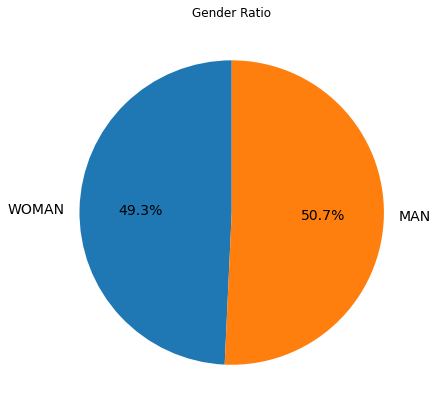

In [41]:
df = pd.DataFrame()
df["sex"] = df_clients["sex"]
df['count'] = df.groupby('sex')['sex'].transform('count')
df = df.drop_duplicates()

fig,ax = plt.subplots(facecolor="#ffffff", figsize=(7,7))
plt.axis('off')

df.plot(kind='pie', y="count", ax=ax, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=df['sex'], legend = False, fontsize=14).set_title("Gender Ratio")

From the graph above, we can see that there is a balanced number of man and woman.

### District data
</br>
The district table is the table with the most number of columns. Since this is the case, it needs to be analysed with extra care.

#### Merging related columns

Since there are many columns in the district column, a correlation matrix is done on this table to see if there are any highly correlated values.

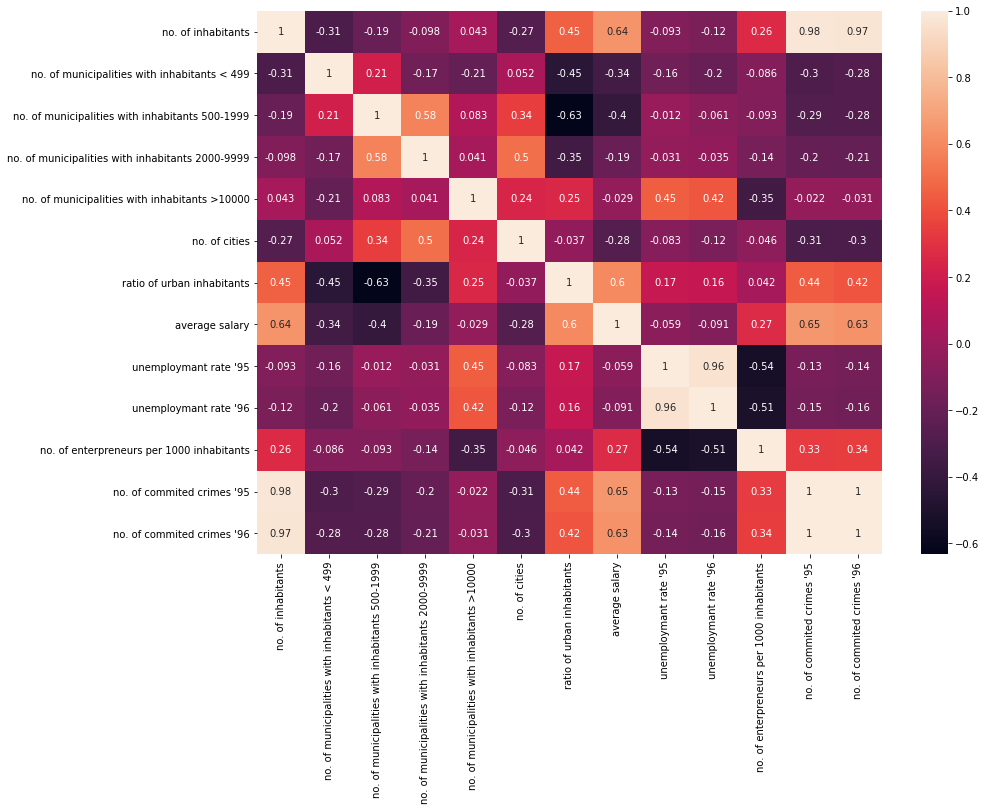

In [42]:
plt.figure(figsize=(14,10))
sb.heatmap(df_district.drop(columns=['code', 'region_0', 'region_1', 'region_2', 'region_3']).corr(method="pearson"), annot=True)
plt.show()

When analysing the correlation map some columns are clearly marked as correlated. To be sure if they can be dropped a pairplot of all columns are made.

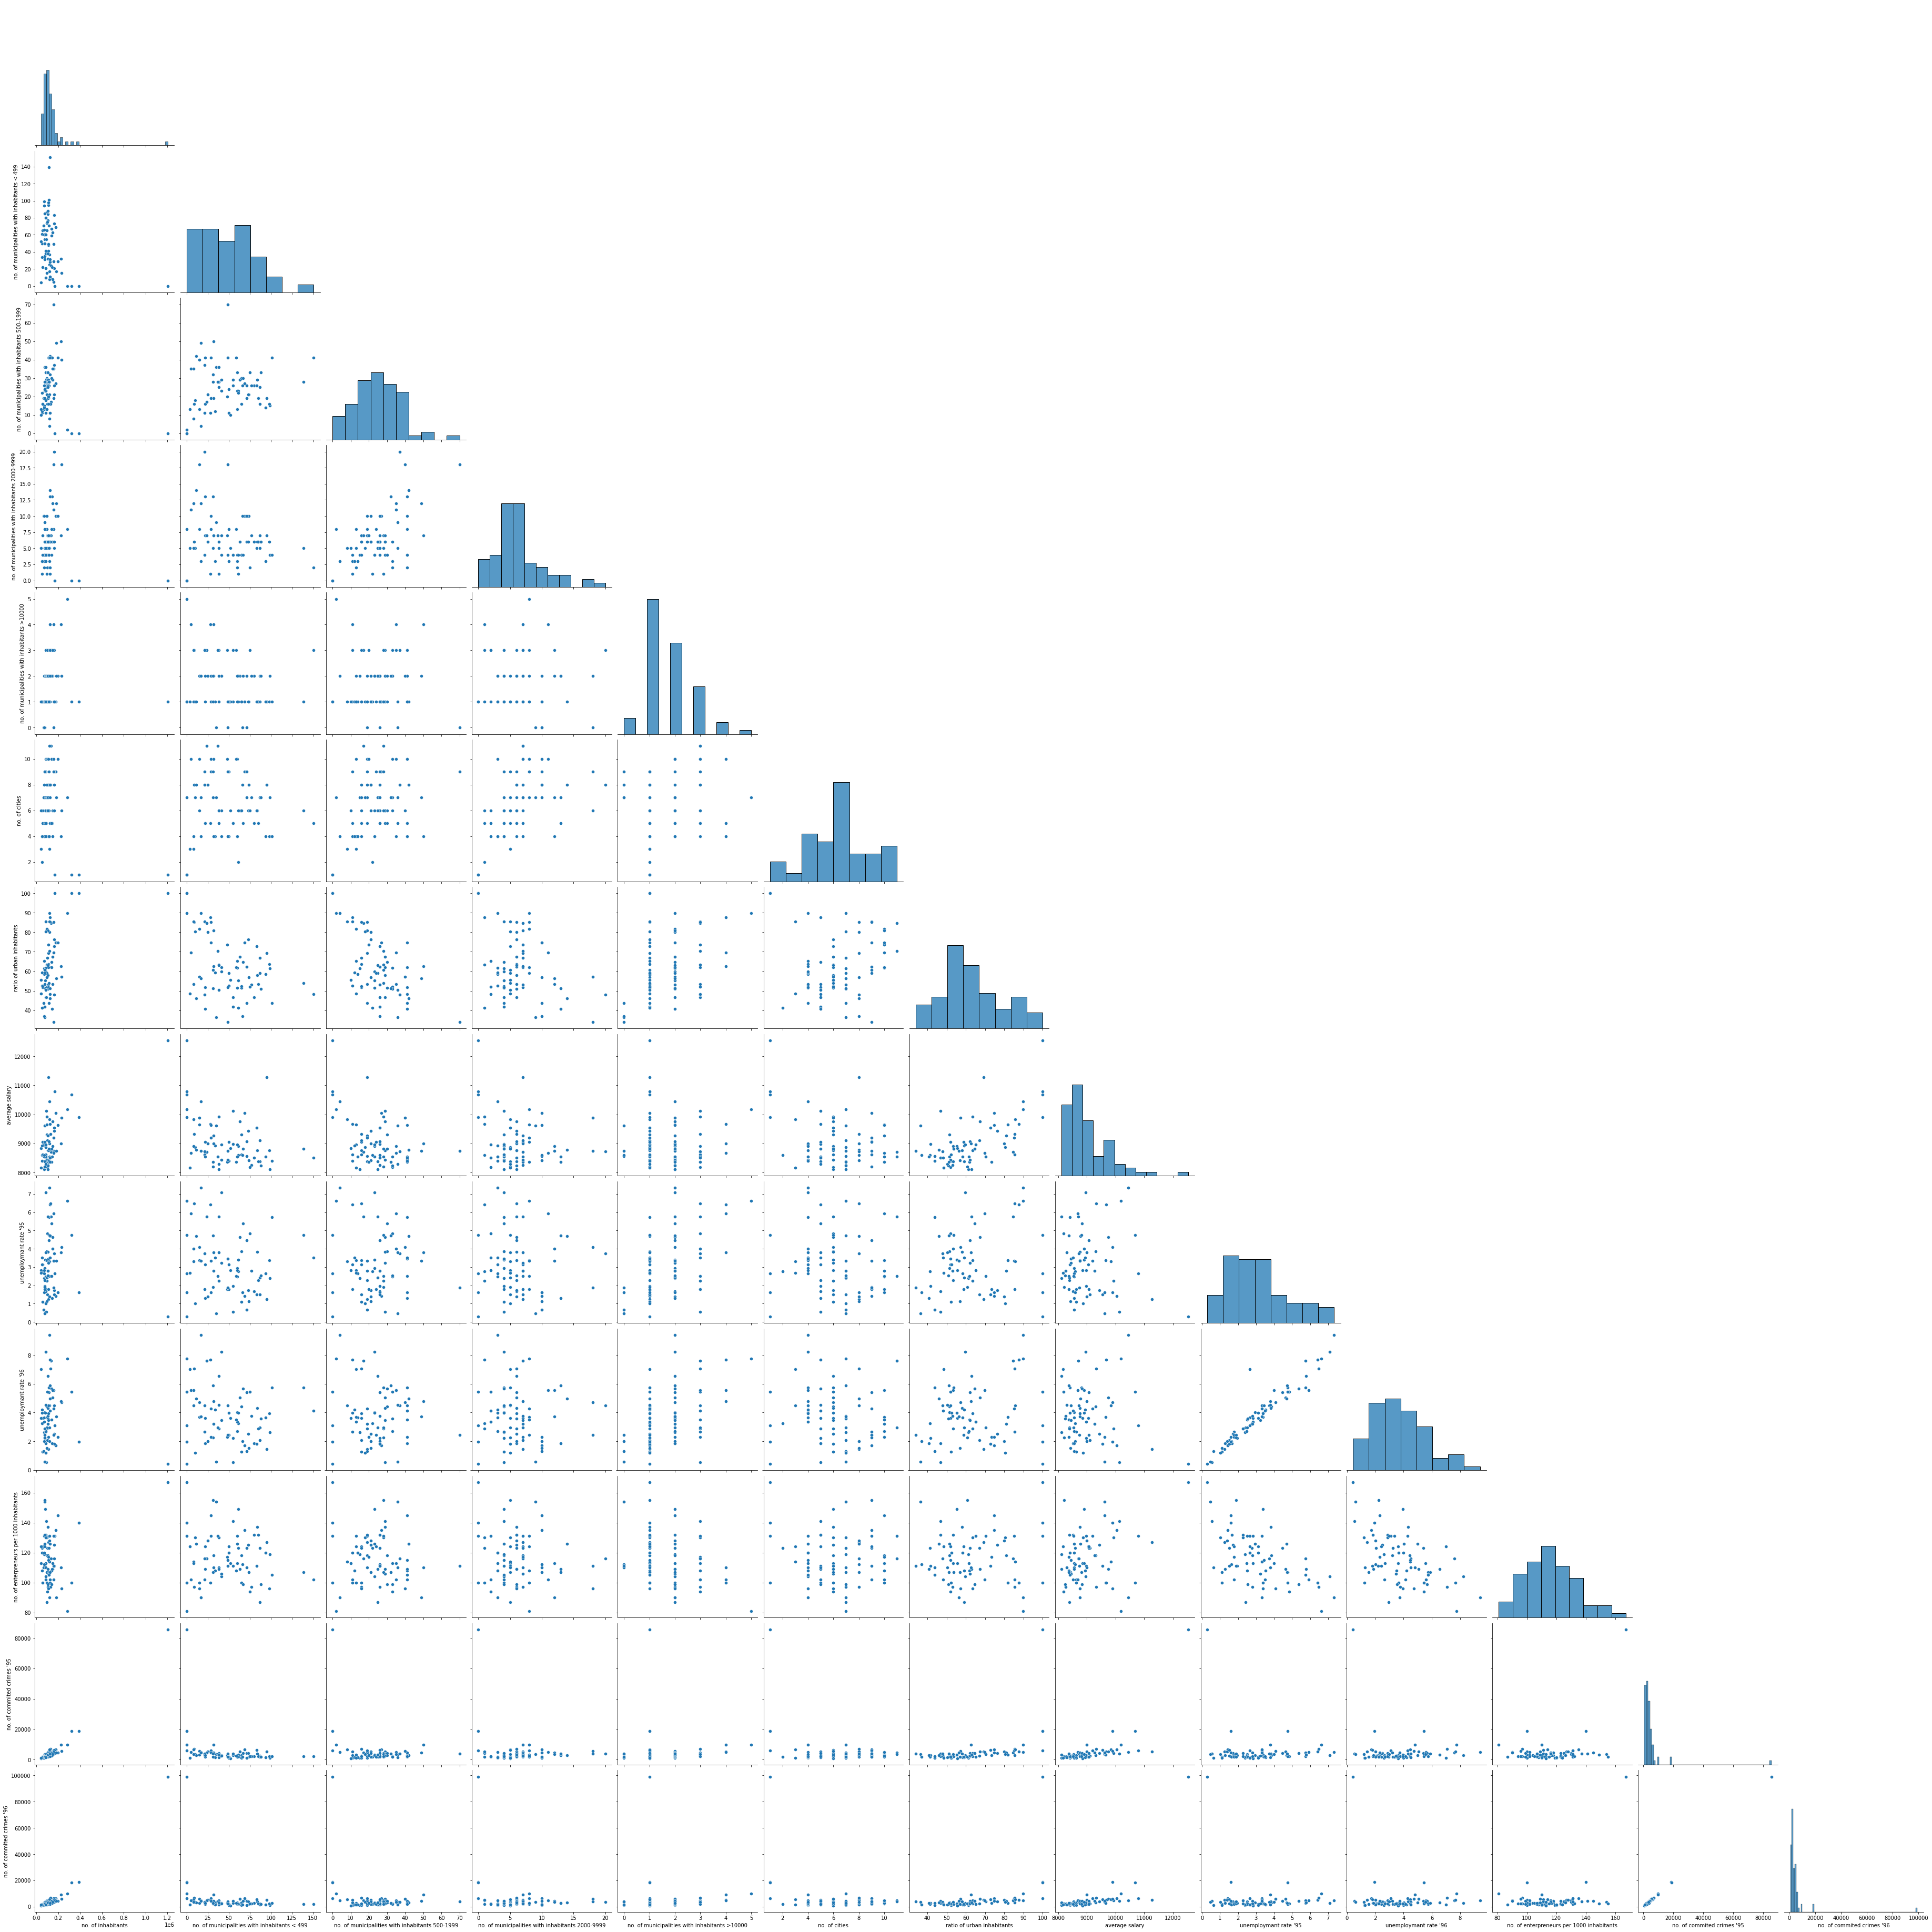

In [43]:
pair_plot = sb.pairplot(df_district, vars=df_district.drop(columns=['code', 'region_0', 'region_1', 'region_2', 'region_3']).columns, corner=True, height=4)
pair_plot.savefig('plots/district_corr.png')

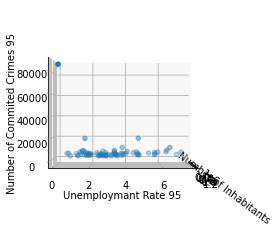

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = df_district['no. of inhabitants']
y = df_district['unemploymant rate \'95']
z = df_district['no. of commited crimes \'95']

ax.set_xlabel("Number of Inhabitants")
ax.set_ylabel("Unemploymant Rate 95")
ax.set_zlabel("Number of Commited Crimes 95")

ax.scatter(x, y, z)

ax.view_init(0, 0)

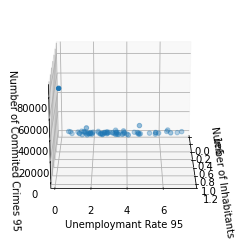

In [45]:
ax.view_init(20, 0)
fig 

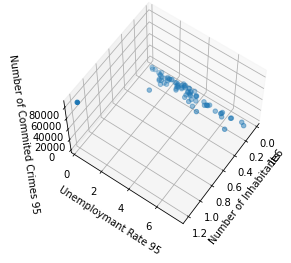

In [46]:
ax.view_init(60, 35)
fig

After analysing the plots, the **no. of commited crimes '95**, **no. of commited crimes '96** and **unemploymant rate '95** were deemed to be redundant and thus dropped, only leaving **unemploymant rate '96** which was renamed to **unemploymant_rate**

In [47]:
df_district.drop(columns=["no. of commited crimes '95", "no. of commited crimes '96","unemploymant rate '95"],inplace=True)

df_district.rename(columns={"unemploymant rate '96": "unemploymant_rate"}, inplace=True)

df_district.head()

code  region_0  region_1  region_2  region_3  no. of inhabitants  \
0     1         0         0         0         1             1204953   
1     2         0         0         1         0               88884   
2     3         0         0         1         0               75232   
3     4         0         0         1         0              149893   
4     5         0         0         1         0               95616   

   no. of municipalities with inhabitants < 499  \
0                                             0   
1                                            80   
2                                            55   
3                                            63   
4                                            65   

   no. of municipalities with inhabitants 500-1999  \
0                                                0   
1                                               26   
2                                               26   
3                                               29   
4                                               30   

   no. of municipalities with inhabitants 2000-9999  \
0                                                 0   
1                                                 6   
2                                                 4   
3                                                 6   
4                                                 4   

   no. of municipalities with inhabitants >10000  no. of cities  \
0                                              1              1   
1                                              2              5   
2                                              1              5   
3                                              2              6   
4                                              1              6   

   ratio of urban inhabitants  average salary  unemploymant_rate  \
0                       100.0           12541               0.43   
1                        46.7            8507               1.85   
2                        41.7            8980               2.21   
3                        67.4            9753               5.05   
4                        51.4            9307               4.43   

   no. of enterpreneurs per 1000 inhabitants  
0                                        167  
1                                        132  
2                                        111  
3                                        109  
4                                        118

In [48]:
df_district = df_district.rename(columns={"code":"district_id"})
df_district.to_csv('clean_datasets/district.csv', index=False)

### Loan Data

When looking at the `loan data` table, three atributes stand out from the others, these being the amount, duration and the payments.</br>
Since the amount is just the duration times the payments they should be highly correlated

Text(0.5, 1.0, 'Verify Amount = Duration*Payments')

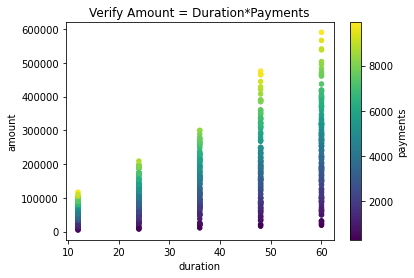

In [49]:
df = df_loans[["amount","payments","duration"]]
fig, ax2 = plt.subplots()
df.plot(kind="scatter",
                      x='duration',
                      y='amount',
                      c='payments',
                        colormap='viridis', ax=ax2).set_title("Verify Amount = Duration*Payments")


As expected, there is a high correlation. When the amount increases it is possible to see that for the same duration the payments increase in value. This is expected and so, we can drop this redundant columns. This is only done later as the feature importance will only be evaluated down the line.

Next, lets look at the data per year.

In [50]:
print("First date: " + df_loans_train_clean["loan_date"].min().strftime("%d/%m/%Y"))
print("Last date: " + df_loans_train_clean["loan_date"].max().strftime("%d/%m/%Y"))

First date: 05/07/1993
Last date: 27/12/1996


Since we now know the loans dataframe we can start separating them per year.

In [51]:
loan1993 = df_loans_train_clean[df_loans_train_clean["loan_date"].dt.year == 1993]
loan1994 = df_loans_train_clean[df_loans_train_clean["loan_date"].dt.year == 1994]
loan1995 = df_loans_train_clean[df_loans_train_clean["loan_date"].dt.year == 1995]
loan1996 = df_loans_train_clean[df_loans_train_clean["loan_date"].dt.year == 1996]

table = [["Year", "Number of Loans", "Loan Average", "Min Loan", "Max Loan"],
         ["1993", loan1993.size, loan1993["amount"].mean(), loan1993["amount"].min(), loan1993["amount"].max()],
         ["1994", loan1994.size, loan1994["amount"].mean(), loan1994["amount"].min(), loan1994["amount"].max()],
         ["1995", loan1995.size, loan1995["amount"].mean(), loan1995["amount"].min(), loan1995["amount"].max()],
         ["1996", loan1996.size, loan1996["amount"].mean(), loan1996["amount"].min(), loan1996["amount"].max()],
         ["Total", df_loans_train_clean.size, df_loans_train_clean["amount"].mean(), df_loans_train_clean["amount"].min(), df_loans_train_clean["amount"].max()]
        ]
print(tabulate(table))

-----  ---------------  ------------------  --------  --------
Year   Number of Loans  Loan Average        Min Loan  Max Loan
1993   140              130963.8            21924     464520
1994   707              132474.29702970298  4980      482940
1995   630              148270.8            15420     538500
1996   819              156561.33333333334  11400     444864
Total  2296             145308.6219512195   4980      538500
-----  ---------------  ------------------  --------  --------


After analysing the previous table, we can see that the year 1993 had the least amount of loans. This is because the first register of a loan was in july of 1993. Since the regestry only contains less than half of the year, it's expected that there were less number of loan in 1993.  
Other info to note is that the average value of a loan increases with the passing of the years even though the max loan in the last year is lower than the other years. This info mean that, even though the loans are smaller in value, there are more high valued loans.

### Cards Data

The cards data only have two important features to analyse at this stage.  
The first one is the card type.  
The cards value is as follows: 
- junior: -10
- classic: 0
- gold: 10

With this in mind, let's analyse their distribution.


<AxesSubplot:ylabel='count'>

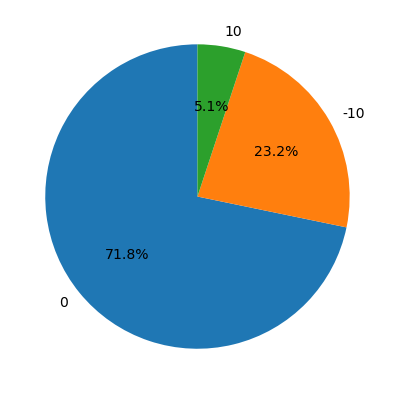

In [52]:
df = pd.DataFrame()
df["card_type"] = df_card_train_clean["card_type"]
df['count'] = df.groupby('card_type')['card_type'].transform('count')
df = df.drop_duplicates()

fig,ax = plt.subplots(facecolor="#ffffff", figsize=(7,7))
plt.axis('off')

df.plot(kind='pie', y="count", ax=ax, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=df['card_type'], legend = False, fontsize=14)

There seem to be an overwhelming majority of cards of type 0 (classic). Only a few (around 5%) have a golden card, which makes sense as there is a fee associated with this type.  
Next, the issued date will be analysed as well as the types of cards created during the corresponding years.  

In [53]:
print("First date: " + df_card_train_clean["card_date"].min().strftime("%d/%m/%Y"))
print("Last date: " + df_card_train_clean["card_date"].max().strftime("%d/%m/%Y"))

First date: 07/11/1993
Last date: 31/12/1996


In [54]:
card1993 = df_card_train_clean[df_card_train_clean["card_date"].dt.year == 1993]
card1994 = df_card_train_clean[df_card_train_clean["card_date"].dt.year == 1994]
card1995 = df_card_train_clean[df_card_train_clean["card_date"].dt.year == 1995]
card1996 = df_card_train_clean[df_card_train_clean["card_date"].dt.year == 1996]

table = [["Year", "Number of Cards", "Number of Junior Cards", "Number of Classic Cards", "Number of Gold Cards"],
         ["1993", card1993.size, card1993[card1993["card_type"] == -10].size, card1993[card1993["card_type"] == 0].size, card1993[card1993["card_type"] == 10].size],
         ["1994", card1994.size, card1994[card1994["card_type"] == -10].size, card1994[card1994["card_type"] == 0].size, card1994[card1994["card_type"] == 10].size],
         ["1995", card1995.size, card1995[card1995["card_type"] == -10].size, card1995[card1995["card_type"] == 0].size, card1995[card1995["card_type"] == 10].size],
         ["1996", card1996.size, card1996[card1996["card_type"] == -10].size, card1996[card1996["card_type"] == 0].size, card1996[card1996["card_type"] == 10].size]
        ]
print(tabulate(table))

----  ---------------  ----------------------  -----------------------  --------------------
Year  Number of Cards  Number of Junior Cards  Number of Classic Cards  Number of Gold Cards
1993  4                0                       4                        0
1994  84               16                      68                       0
1995  228              56                      156                      16
1996  392              92                      280                      20
----  ---------------  ----------------------  -----------------------  --------------------


We can see that in 1993, there are only 4 records of cards creations. This is because the first register of card creation is in November, which means almost the whole year is missing from the dataset. On top of that, only in 1995 were there gold cards created, but without further data we cannot be sure as to why this happens. We can also see that the number of cards made per year is increasing.

<AxesSubplot:xlabel='year'>

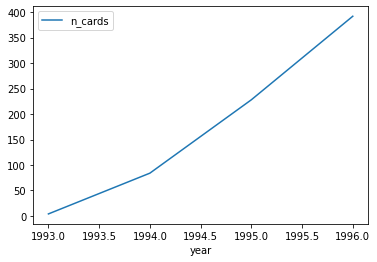

In [55]:
raw_data = {'year': [1993, 1994, 1995, 1996],
            'n_cards': [card1993.size, card1994.size, card1995.size, card1996.size]}


df = pd.DataFrame(raw_data, columns = ['year', 'n_cards'])
df['n_cards'] = df['n_cards'].astype('int')
df.plot.line(x="year", y="n_cards")

As the plot above shows, it seems the number of cards created per year follow an almost linear patter, however, this is not certain as the year 1993 does not seem to be complete.

### Transactions

When talking about transaction, the money involved comes to mind. So let's start analysing the columns that involve money.

In [56]:
df_trans_train = pd.read_csv("clean_datasets/trans_train.csv")
df_trans_train.head()

trans_id  account_id        date    type                     operation  \
0   1548749        5270  1993-01-13  credit                credit in cash   
1   1548750        5270  1993-01-14  credit  collection from another bank   
2   3393738       11265  1993-01-14  credit                credit in cash   
3   3122924       10364  1993-01-17  credit                credit in cash   
4   1121963        3834  1993-01-19  credit                credit in cash   

    amount  balance  
0    800.0    800.0  
1  44749.0  45549.0  
2   1000.0   1000.0  
3   1100.0   1100.0  
4    700.0    700.0

In [57]:
df_trans_train["date"] = pd.to_datetime(df_trans_train["date"])

print("First date: " + df_trans_train["date"].min().strftime("%d/%m/%Y"))
print("Last date: " +  df_trans_train["date"].max().strftime("%d/%m/%Y"))

First date: 01/01/1993
Last date: 31/12/1996


In [58]:
trans1993 = df_trans_train[df_trans_train["date"].dt.year == 1993]
trans1994 = df_trans_train[df_trans_train["date"].dt.year == 1994]
trans1995 = df_trans_train[df_trans_train["date"].dt.year == 1995]
trans1996 = df_trans_train[df_trans_train["date"].dt.year == 1996]

After extracting every year's data, it is possible to start analysing each year individually.

In [59]:
table = [["Year", "Number of Transactions", "Number of Credit Transactions", "Number of withdrawal Transactions", "Mean Transactions"],
         ["1993", trans1993.size, trans1993[trans1993["type"] == "credit"].size, trans1993[(trans1993["type"] == "withdrawal") | (trans1993["type"] == "withdrawal in cash")].size, trans1993["amount"].mean()],
         ["1994", trans1994.size, trans1994[trans1994["type"] == "credit"].size, trans1994[(trans1994["type"] == "withdrawal") | (trans1994["type"] == "withdrawal in cash")].size, trans1994["amount"].mean()],
         ["1995", trans1995.size, trans1995[trans1995["type"] == "credit"].size, trans1995[(trans1995["type"] == "withdrawal") | (trans1995["type"] == "withdrawal in cash")].size, trans1995["amount"].mean()],
         ["1996", trans1996.size, trans1996[trans1996["type"] == "credit"].size, trans1996[(trans1996["type"] == "withdrawal") | (trans1996["type"] == "withdrawal in cash")].size, trans1996["amount"].mean()],
         ["Total", df_trans_train.size, df_trans_train[df_trans_train["type"] == "credit"].size, df_trans_train[(df_trans_train["type"] == "withdrawal") | (df_trans_train["type"] == "withdrawal in cash")].size, df_trans_train["amount"].mean()]     
         ]

print(tabulate(table))

-----  ----------------------  -----------------------------  ---------------------------------  -----------------
Year   Number of Transactions  Number of Credit Transactions  Number of withdrawal Transactions  Mean Transactions
1993   194803                  105581                         89222                              7237.555970390599
1994   599270                  235543                         363727                             5749.720923957481
1995   824215                  316792                         507423                             5562.688466601555
1996   1158507                 458360                         700147                             5459.62741494009
Total  2776795                 1116276                        1660519                            5677.552979568172
-----  ----------------------  -----------------------------  ---------------------------------  -----------------


From the above table we can see that the number of transactions increases every year, however the mean stays roughly the same. This makes sense since from the previous analysis, each year the number of accounts increases which would also lead to an increase in the number of transactions. 

## Additional Post Analysis Transaction Cleanup

After merging both the test and train data, let's make it so that the account_id is also unique so when merging with other tables we do not get duplicate values.
This must be taken into account because **for each account there might be more than one transaction**, although there can only be one row for each account for the final data merging to be correct.

In order to do this, we need to group all the transactions relative to each account and develop new features derivated from the old ones. These new features must allow for a representation of the entire group, instead of each transaction.

We will start by making two new columns, one for the **mean credit amounts**, and another for the **mean of withdrawal amounts**.

In [60]:
#gets the mean amount of credits
df_credits = df_trans_merge[df_trans_merge["type"] == "credit"].groupby("account_id")['amount'].agg([np.mean])

#gets the mean amount of withdrawal
df_withdrawals = df_trans_merge[(df_trans_merge["type"] == "withdrawal") | (df_trans_merge['type'] == "withdrawal in cash")].groupby("account_id")['amount'].agg([np.mean])

df_credits = df_credits.reset_index()
df_withdrawals = df_withdrawals.reset_index()

#renames both columns
df_credits = df_credits.rename(columns={"mean":"credits_mean"})
df_withdrawals = df_withdrawals.rename(columns={"mean":"withdrawal_mean"})

#drops values no longer needed because of the new columns
df_trans_merge.drop(columns=["type", "operation", "amount"], inplace=True)

#adds the new columns to the main dataframe
df_trans_merge = pd.merge(df_trans_merge, df_credits, on="account_id", how="left")
df_trans_merge = pd.merge(df_trans_merge, df_withdrawals, on="account_id", how="left")



After all the data preparing we can start filtering all unwanted rows according to the transaction date.
Here we will only keep the last transaction before the loan, in order to keep how the account was at that time. On top of that, we will remove every row with date after the loan date.

In [61]:
df_loans_merge = pd.concat([pd.read_csv('clean_datasets/loans_train.csv'),pd.read_csv('clean_datasets/loans_test.csv')])

df_trans_merge = df_trans_merge.merge(df_loans_merge[["account_id", "loan_date"]], on="account_id", how="left")

df_trans_merge = df_trans_merge[(df_trans_merge["date"] <= df_trans_merge["loan_date"])].drop(columns="loan_date")

#gets the minimum value of balance
min_value = df_trans_merge.groupby('account_id').balance.min()

#gets the maximum value of balance
max_value = df_trans_merge.groupby('account_id').balance.max()

df_trans_merge = df_trans_merge.drop(columns=['trans_id'])

df1 = df_trans_merge.reset_index() #makes the index a normal column for easier data handle
g = df1.groupby(["account_id",])
once = df1[g["index"].transform(len) == 1] #gets all rows whose index only appears once in the table
more = df1[g["index"].transform(len) > 1] #gets all rows whose index appears multiple times in the table
g2 = more.groupby(["account_id"], as_index=False)

max_mores  = df1.loc[g2["date"].agg(lambda x: x.idxmax())["date"]] #filter by date, leaving only the one more recent
df_trans_clean = pd.concat([once, max_mores]).reset_index() #concatenates the 'once' and 'max_more' tables to have a complete dataframe
df_trans_clean.drop(columns=["index","level_0"],inplace=True) # columns created by reset_index()

df_trans_clean['credits_mean'] = df_trans_clean['credits_mean'].apply(lambda x: 0 if pd.isna(x) else x)
df_trans_clean['withdrawal_mean'] = df_trans_clean['withdrawal_mean'].apply(lambda x: 0 if pd.isna(x) else x)
df_trans_clean = df_trans_clean.merge(min_value, on="account_id", how="left", suffixes=('', '_min'))
df_trans_clean = df_trans_clean.merge(max_value, on="account_id", how="left", suffixes=('', '_max'))

df_trans_clean = df_trans_clean.rename(columns={"date":"trans_date", "balance":"last_balance"})

df_trans_train =  df_trans_clean[df_trans_clean['account_id'].isin(df_trans_train['account_id'].values)]   
df_trans_test = df_trans_clean[df_trans_clean['account_id'].isin(df_trans_test['account_id'].values)]  
df_trans_train.to_csv('clean_datasets/trans_train.csv', index=False)
df_trans_test.to_csv('clean_datasets/trans_test.csv', index=False)

In [62]:
df_trans_clean.head()

account_id trans_date  last_balance  credits_mean  withdrawal_mean  \
0           2 1993-12-31       27840.6  10394.786364      6276.393750   
1          19 1996-04-10       15854.0   5264.765217      6656.611765   
2          25 1997-12-06       31621.9  19787.319608      8650.720354   
3          37 1998-10-12       16367.8  13979.996875      5130.857143   
4          38 1998-04-10       37416.7   6452.334783      3468.343750   

   balance_min  balance_max  
0       1100.0      67529.6  
1        715.0      58157.5  
2        900.0     119652.7  
3      -1011.2     104761.5  
4      13841.0      55991.1

## Merging the Data

Now that we have the different tables clean, we start merging the data into our final dataset.

In [63]:
# Loan data
df_loan_train = pd.read_csv('clean_datasets/loans_train.csv', parse_dates=['loan_date'], date_parser=pd.to_datetime)
df_loan_test = pd.read_csv('clean_datasets/loans_test.csv', parse_dates=['loan_date'], date_parser=pd.to_datetime)

In [64]:
# Accounts data
df_accounts_test = pd.read_csv('clean_datasets/account.csv', parse_dates=['account_date'], date_parser=pd.to_datetime)

In [65]:
# District data
df_districts_test = pd.read_csv('clean_datasets/district.csv', dtype={"region":"category"})
df_districts_test = df_districts_test.reset_index()

In [66]:
# Clients and Disposition data
df_clients = pd.read_csv('clean_datasets/client.csv', dtype={"birthdate":"datetime64[ns]"})
df_disp = pd.read_csv('clean_datasets/disp.csv')

In [67]:
# Card data
pd_card_test = pd.read_csv('clean_datasets/cards_test.csv')
pd_card_train = pd.read_csv('clean_datasets/cards_train.csv')
pd_concat = pd.concat([pd_card_test,pd_card_train])

We start by merging the client and disposition data, as each disposition entry is associated to a client.

In [68]:
merge_clients_disp = pd.merge(df_clients,df_disp, on="client_id", how="left")
merge_clients_disp.head()

client_id  district_id    sex  birth_date  disp_id  account_id  disp_type
0          1           18  WOMAN  1970-12-13        1           1      OWNER
1          2            1    MAN  1945-02-04        2           2      OWNER
2          3            1  WOMAN  1940-10-09        3           2  DISPONENT
3          4            5    MAN  1956-12-01        4           3      OWNER
4          5            5  WOMAN  1960-07-03        5           3  DISPONENT

In the next step we join the clients and disposition data with the card data. We merge them on the disposition ID as every card is associated to a disposition.

In [69]:
merge_clients_disp_card = pd.merge(merge_clients_disp, pd_concat, on="disp_id", how="left")
merge_clients_disp_card.head()

client_id  district_id    sex  birth_date  disp_id  account_id  disp_type  \
0          1           18  WOMAN  1970-12-13        1           1      OWNER   
1          2            1    MAN  1945-02-04        2           2      OWNER   
2          3            1  WOMAN  1940-10-09        3           2  DISPONENT   
3          4            5    MAN  1956-12-01        4           3      OWNER   
4          5            5  WOMAN  1960-07-03        5           3  DISPONENT   

   card_id  card_type card_date  
0      NaN        NaN       NaN  
1      NaN        NaN       NaN  
2      NaN        NaN       NaN  
3      NaN        NaN       NaN  
4      NaN        NaN       NaN

**Problem**: When merging the disposition, client and card data, there might be multiple entries related to each account_id because every account can have more than one client and, consequently, more than one card. This makes it impossible to merge this data for the final dataset.

In order to resolve this, we group the entries by account_id, replacing the features related to the cards. As the number of clients associated with each account and the overall importance of the cards in an account might prove useful to predict the target, we add two new features:
- **n_clients**: number of clients associated with the account
- **card_avg**: average 'score' of all the cards associated with the account (Junior card: -10, Classic card: 0, Gold card: 10)

In [70]:
n_account_ids = merge_clients_disp_card.groupby("account_id")["client_id"].count()

In [71]:
merge_clients_disp_card = pd.merge(merge_clients_disp_card, n_account_ids, on="account_id").rename(columns={"client_id_x": "client_id","client_id_y": "n_clients"})

In [72]:
n_cards = merge_clients_disp_card[merge_clients_disp_card["card_id"].notnull()].groupby("account_id")["client_id"].count()

In [73]:
cards_value = merge_clients_disp_card[merge_clients_disp_card["card_id"].notnull()].groupby("account_id")["card_type"].sum()
card_avg = cards_value / n_cards
card_avg = pd.DataFrame({"account_id": card_avg.index.values, "card_avg": card_avg.values})

In [74]:
merge_clients_disp_card = pd.merge(merge_clients_disp_card, card_avg, on="account_id", how="left")
merge_clients_disp_card['card_avg'] = merge_clients_disp_card['card_avg'].apply(lambda x: 0 if np.isnan(x) else x) 
merge_clients_disp_card['card_avg'] = merge_clients_disp_card['card_avg'].astype('int')
merge_clients_disp_card

client_id  district_id    sex  birth_date  disp_id  account_id  \
0             1           18  WOMAN  1970-12-13        1           1   
1             2            1    MAN  1945-02-04        2           2   
2             3            1  WOMAN  1940-10-09        3           2   
3             4            5    MAN  1956-12-01        4           3   
4             5            5  WOMAN  1960-07-03        5           3   
...         ...          ...    ...         ...      ...         ...   
5364      13955            1  WOMAN  1945-10-30    13647       11349   
5365      13956            1    MAN  1943-04-06    13648       11349   
5366      13968           61    MAN  1968-04-13    13660       11359   
5367      13971           67  WOMAN  1962-10-19    13663       11362   
5368      13998           74  WOMAN  1953-08-12    13690       11382   

      disp_type  card_id  card_type   card_date  n_clients  card_avg  
0         OWNER      NaN        NaN         NaN          1         0  
1         OWNER      NaN        NaN         NaN          2         0  
2     DISPONENT      NaN        NaN         NaN          2         0  
3         OWNER      NaN        NaN         NaN          2         0  
4     DISPONENT      NaN        NaN         NaN          2         0  
...         ...      ...        ...         ...        ...       ...  
5364      OWNER      NaN        NaN         NaN          2         0  
5365  DISPONENT      NaN        NaN         NaN          2         0  
5366      OWNER   1247.0        0.0  1995-06-13          1         0  
5367      OWNER      NaN        NaN         NaN          1         0  
5368      OWNER      NaN        NaN         NaN          1         0  

[5369 rows x 12 columns]

After adding the new features to group the entries to each account, we drop every entry except for the ones relative to the Owner of the account.

In [75]:
merge_clients_disp_card = merge_clients_disp_card[merge_clients_disp_card["disp_type"]=="OWNER"]

In [76]:
merge_clients_disp_card = merge_clients_disp_card.drop(columns=["card_id", "card_type", "card_date","district_id"])


# Splitting the data back into train and test
merge_clients_disp_train =  merge_clients_disp_card[merge_clients_disp_card['account_id'].isin(df_loan_train['account_id'].values)]   
merge_clients_disp_test = merge_clients_disp_card[merge_clients_disp_card['account_id'].isin(df_loan_test['account_id'].values)]  

merge_clients_disp_train.to_csv("merge_clients_disp_train.csv", index=False)
merge_clients_disp_test.to_csv("merge_clients_disp_test.csv", index=False)

After carefuly examining the previous cases and correctly merging the data, we can merge all the different datasets.

In [77]:
# Merging train data
merge_train = pd.merge(df_loan_train, df_accounts_test, on = 'account_id', how='left')
merge_train = pd.merge(merge_train, df_districts_test, on = 'district_id',how='left')
merge_train = pd.merge(merge_train, df_trans_train, on='account_id', how="left")
merge_train = pd.merge(merge_train, merge_clients_disp_train, on='account_id', how="left")

In [78]:
# Merging test data
merge_test = pd.merge(df_loan_test, df_accounts_test, on = 'account_id', how='left')
merge_test = pd.merge(merge_test, df_districts_test, on = 'district_id',how='left')
merge_test = pd.merge(merge_test, df_trans_test, on='account_id', how="left")
merge_test = pd.merge(merge_test, merge_clients_disp_test, on='account_id', how="left")

### Merged Dataset

With all tables cleaned we can start joining them all.  
On top of joining them all, it is also possible to extract new information after joining.  
An example of this is the age of the client when asking for a loan, using the loan date and the client's birthdate.  
In adition to this, it was decided to apply a log operation to the `no. of inhabitants` columns since there was a very big gap between the low number of inhabitants and the big number of inhabitants.

In [79]:
for df in (merge_train, merge_test):
    df['time_since_create'] = (df["loan_date"] - df["account_date"]).dt.days
    df['time_since_last_trans'] = (df["loan_date"] - df["trans_date"]).dt.days

merge_train = merge_train.drop(columns=["account_date", "index", "trans_date"])
merge_test = merge_test.drop(columns=["account_date", "index", "trans_date"])
merge_train["no. of inhabitants"] = np.log(merge_train["no. of inhabitants"])
merge_test["no. of inhabitants"] = np.log(merge_test["no. of inhabitants"])


merge_train.loan_date = merge_train.loan_date.astype('datetime64[ns]')
merge_train.birth_date = merge_train.birth_date.astype('datetime64[ns]')

merge_test.loan_date = merge_test.loan_date.astype('datetime64[ns]')
merge_test.birth_date = merge_test.birth_date.astype('datetime64[ns]')

#get age of owner at time of loan
extra_year = - ((merge_train["loan_date"].dt.month*100 + merge_train["loan_date"].dt.day)  < (merge_train["birth_date"].dt.month*100 + merge_train["birth_date"].dt.day))
merge_train["age"] = (merge_train["loan_date"].dt.year - merge_train["birth_date"].dt.year) + extra_year
merge_test["age"] = (merge_test["loan_date"].dt.year - merge_train["birth_date"].dt.year) + extra_year

Since there was a large skewness in the `no. of inhabitants` column, a logarithmic transformation was applied to this column.

In [80]:
merge_train.head()

loan_id  account_id  loan_date  amount  duration  payments  status  \
0     5314        1787 1993-07-05   96396        12      8033       1   
1     5316        1801 1993-07-11  165960        36      4610       0   
2     6863        9188 1993-07-28  127080        60      2118       0   
3     5325        1843 1993-08-03  105804        36      2939       0   
4     7240       11013 1993-09-06  274740        60      4579       0   

   district_id  frequency  region_0  ...  client_id    sex  birth_date  \
0           30          4         0  ...       2166  WOMAN  1947-07-22   
1           46          1         0  ...       2181    MAN  1968-07-22   
2           45          1         0  ...      11314    MAN  1936-06-02   
3           12          1         0  ...       2235  WOMAN  1940-04-20   
4            1          4         0  ...      13539    MAN  1978-09-07   

   disp_id  disp_type  n_clients  card_avg  time_since_create  \
0     2166      OWNER          1         0                105   
1     2181      OWNER          1         0                148   
2    11006      OWNER          1         0                170   
3     2235      OWNER          1         0                185   
4    13231      OWNER          1         0                204   

   time_since_last_trans  age  
0                     15   46  
1                      2   25  
2                      7   58  
3                      3   54  
4                      6   15  

[5 rows x 38 columns]

In [81]:
merge_train.to_csv("merge_train.csv", index=False)
merge_test.to_csv("merge_test.csv", index=False)

## Post Merge Analysis

### Client Age Distribuition

<Figure size 576x576 with 0 Axes>

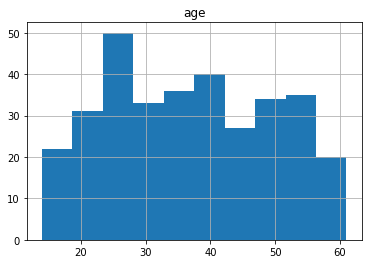

In [82]:
merge_train = pd.read_csv("merge_train.csv")
plt.figure(figsize=(8, 8))

merge_train.hist(column='age')
plt.show()

### Comparing last balance and loan amount

<function matplotlib.pyplot.show(close=None, block=None)>

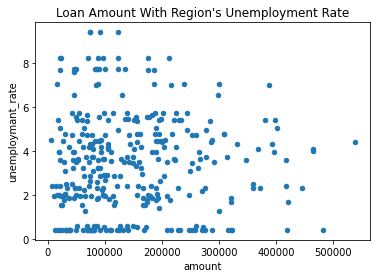

In [83]:
df = merge_train[["unemploymant_rate","amount"]]
fig, ax2 = plt.subplots()
df.plot(kind="scatter",
            x='amount',
            y='unemploymant_rate', ax=ax2).set_title("Loan Amount With Region's Unemployment Rate")
plt.show

It seems that, contrary to what was expected, as the unemploymant rate increases the number of loans decreases and so does the amount (the number of loans is given by the number of dots).

### Class Balance

One of the most important consideration to have when working on a predictive model for a single class is to know whether the dataset is **balanced** and, if not, how so.

We can observe this by plotting the entry count for each class in the training data.

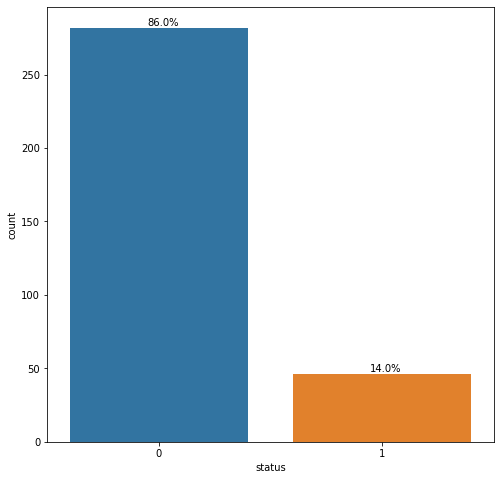

In [84]:
plt.figure(figsize=(8, 8))

cp = sb.countplot(x='status', data=merge_train)
total = len(merge_train)

patchNegative = cp.patches[0]
percentage = '{:.1f}%'.format(100 * patchNegative.get_height() / total)
x = patchNegative.get_x() + (patchNegative.get_width() / 2.3)
y = patchNegative.get_y() + patchNegative.get_height() + 1.5
cp.annotate(percentage, (x, y))

patchPositive = cp.patches[1]
percentage = '{:.1f}%'.format(100 * patchPositive.get_height() / total)
x = patchPositive.get_x() + (patchPositive.get_width() / 2.3)
y = patchPositive.get_y() + patchPositive.get_height() + 1.5
cp.annotate(percentage, (x, y))

plt.show()

This dataset is **very unbalanced**. Only 14% of the rows are relative to refused loans (positive class).

This means that our models will tend to favour the negative class, unless measures are taken to avoid this. To address this, class weight options in the classifiers and **sampling** methods will be considered later on.

### Correlations

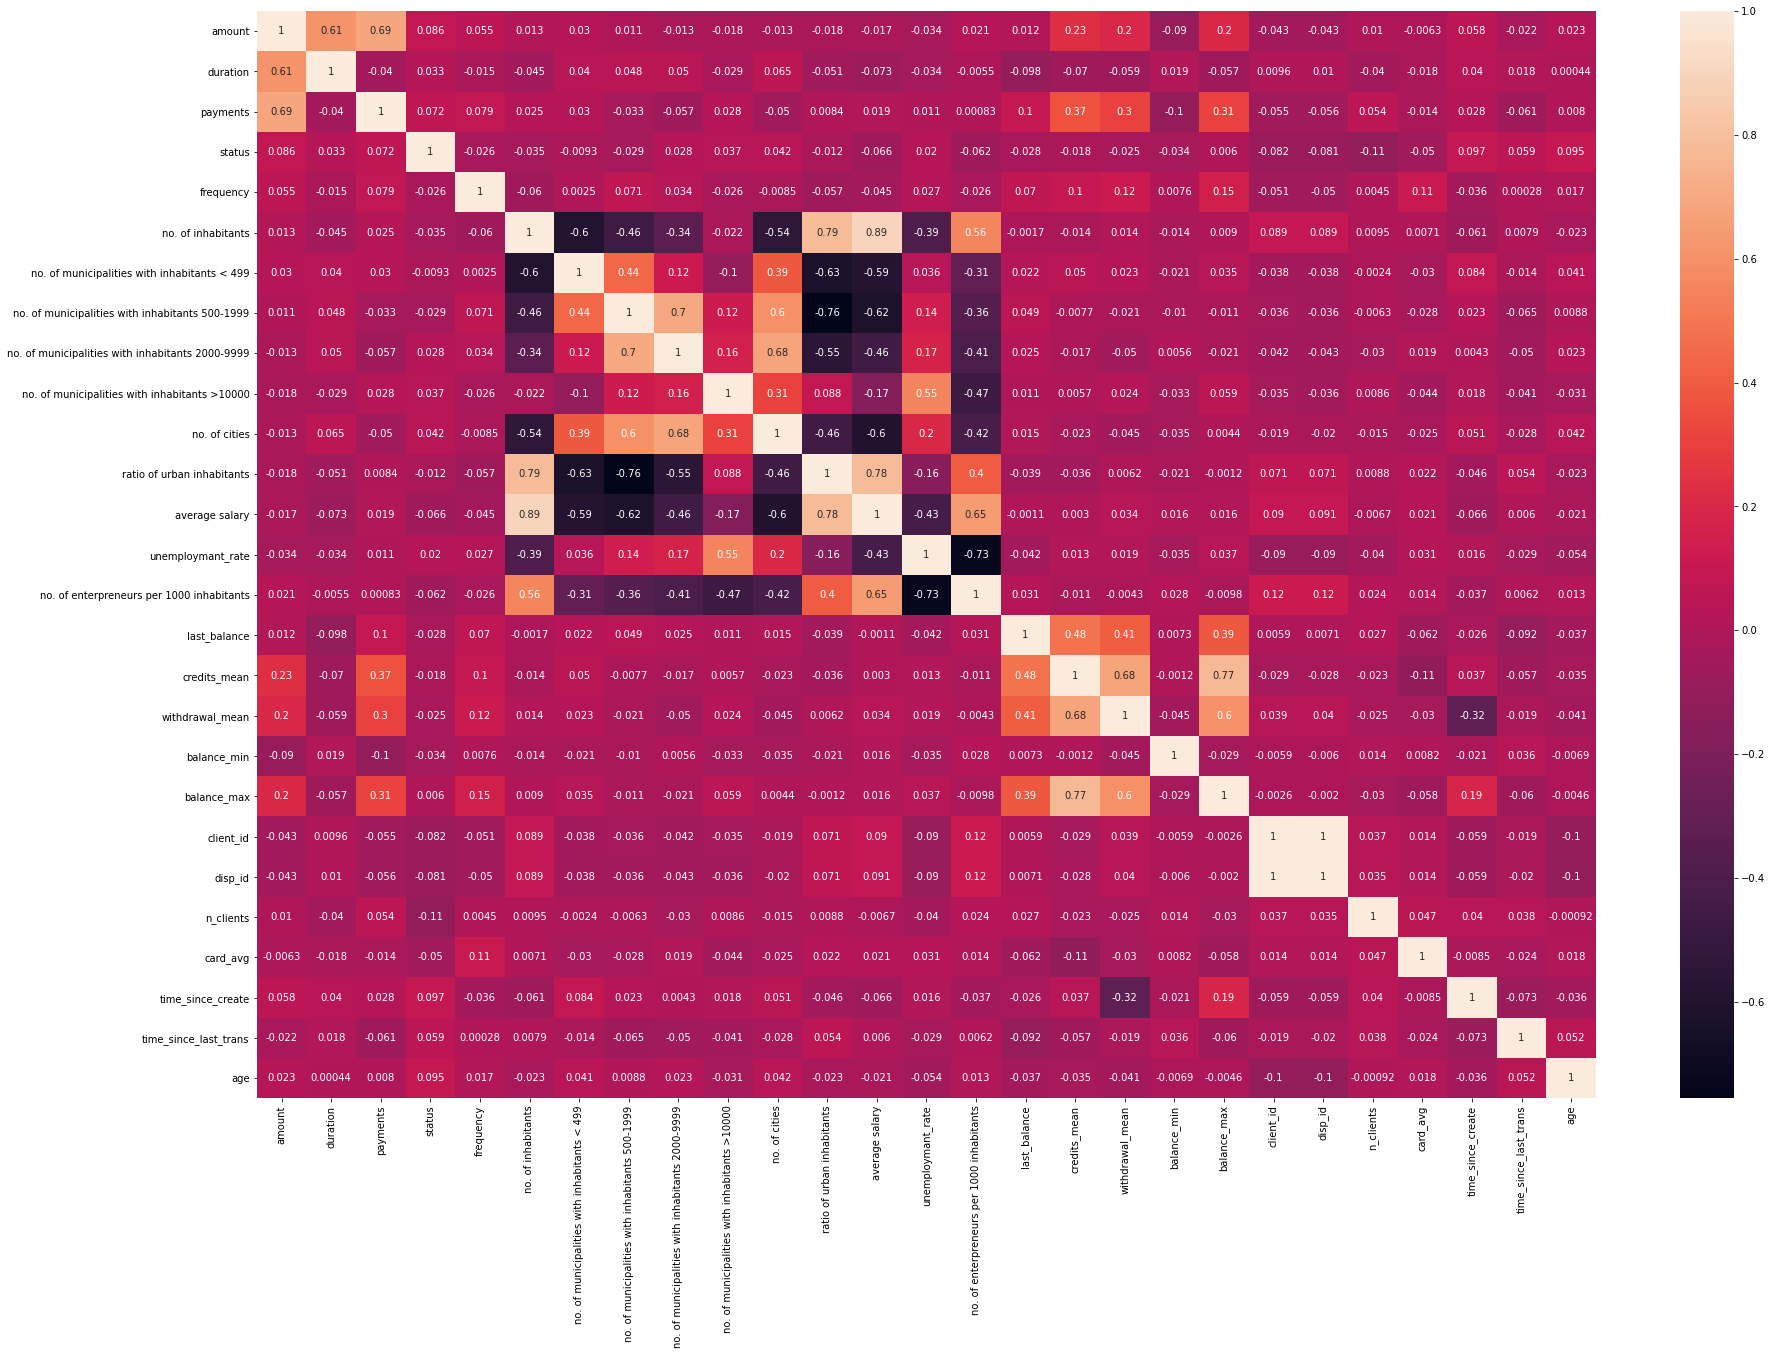

In [85]:
merge_train = pd.concat([pd.read_csv("merge_train.csv"),pd.read_csv("merge_test.csv")])

plt.figure(figsize=(30,20))
sb.heatmap(merge_train.drop(columns=['loan_id', 'account_id', 'district_id', 'region_0', 'region_1', 'region_2', 'region_3']).corr(method="pearson"), annot=True)
plt.show()

After the merge, there do not seem to be any highly correlated values so there is not need to drop or join any column.

### Class Distribution

After checking the merged table's correlation matrix, it is also necessary to see how the status behaves with the different features.  
To analyse this, it is necessary to create a **histplot** for each feature.

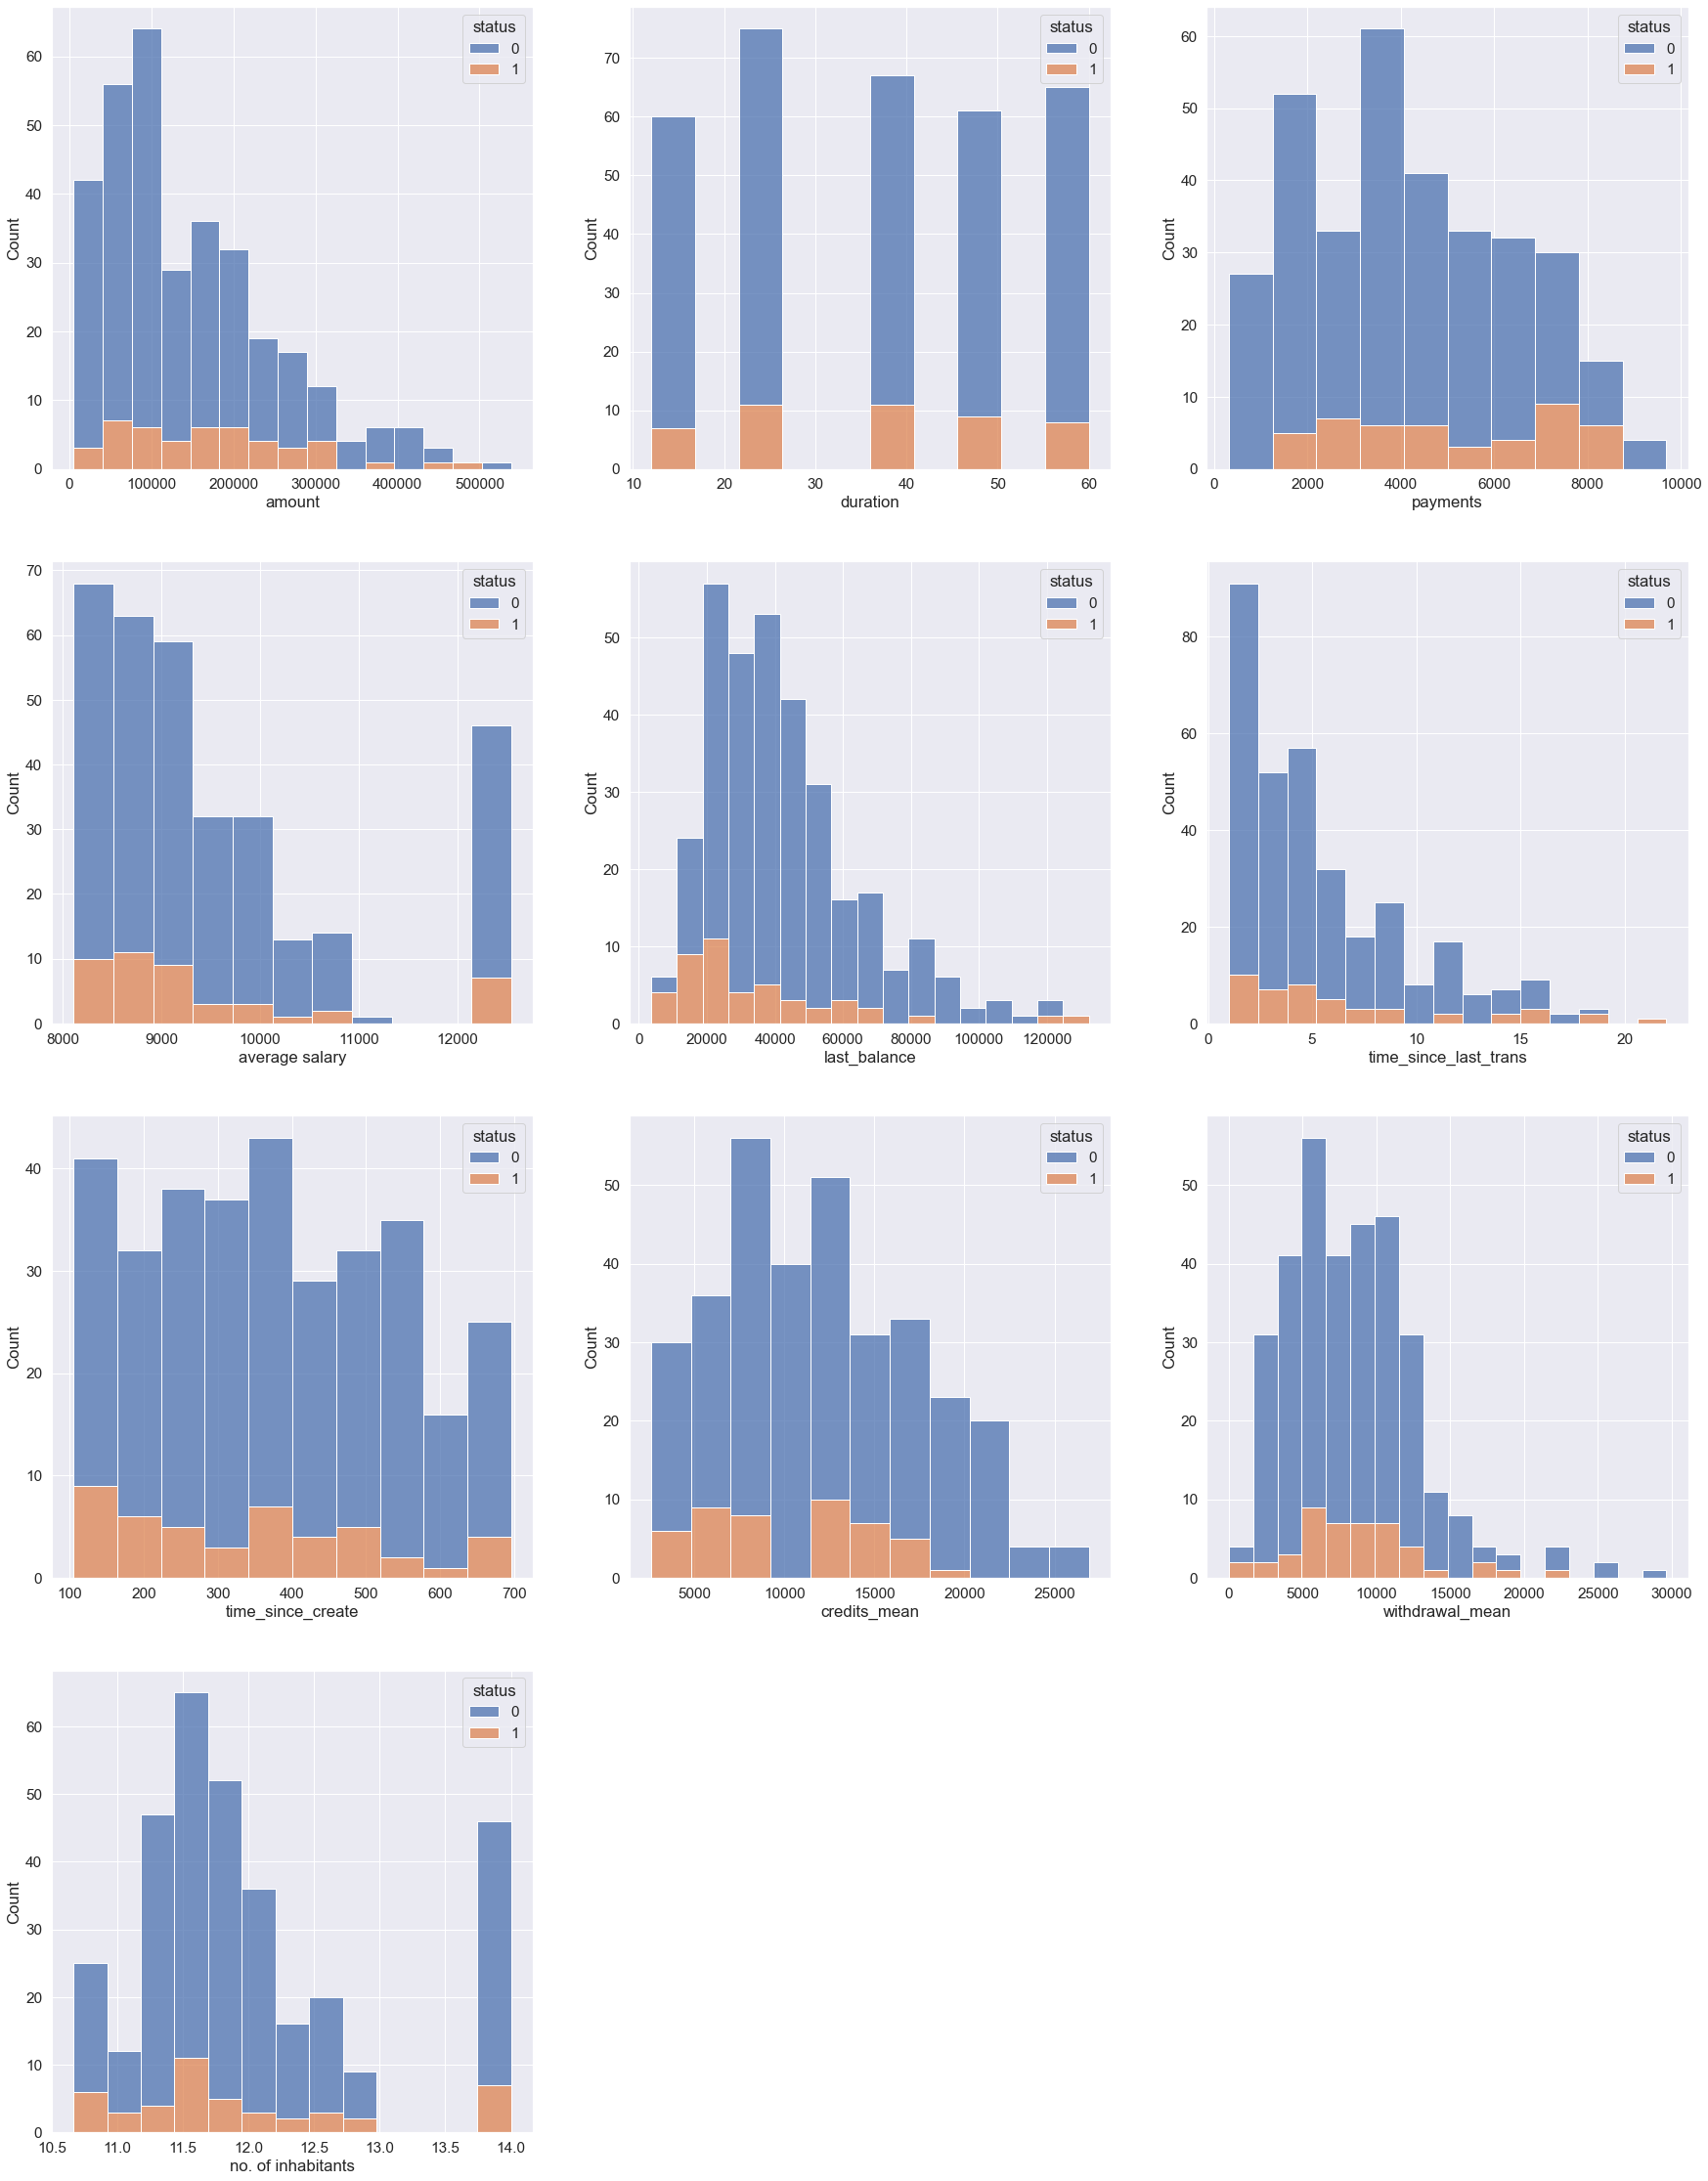

In [86]:
merge_train = pd.read_csv("merge_train.csv")

fig = plt.figure(figsize=(30, 40))
sb.set(font_scale=1.4)

ax = fig.add_subplot(4, 3, 1)
sb.histplot(merge_train, x="amount", multiple="stack", hue="status", ax=ax)
ax = fig.add_subplot(4, 3, 2)
sb.histplot(merge_train, x="duration", multiple="stack", hue="status", ax=ax)
ax = fig.add_subplot(4, 3, 3)
sb.histplot(merge_train, x="payments", multiple="stack", hue="status", ax=ax)
ax = fig.add_subplot(4, 3, 4)
sb.histplot(merge_train, x="average salary", multiple="stack", hue="status", ax=ax)
ax = fig.add_subplot(4, 3, 5)
sb.histplot(merge_train, x="last_balance", multiple="stack", hue="status", ax=ax)
ax = fig.add_subplot(4, 3, 6)
sb.histplot(merge_train, x="time_since_last_trans", multiple="stack", hue="status", ax=ax)
ax = fig.add_subplot(4, 3, 7)
sb.histplot(merge_train, x="time_since_create", multiple="stack", hue="status", ax=ax)
ax = fig.add_subplot(4, 3, 8)
sb.histplot(merge_train, x="credits_mean", multiple="stack", hue="status", ax=ax)
ax = fig.add_subplot(4, 3, 9)
sb.histplot(merge_train, x="withdrawal_mean", multiple="stack", hue="status", ax=ax)
ax = fig.add_subplot(4, 3, 10)
sb.histplot(merge_train, x="no. of inhabitants", multiple="stack", hue="status", ax=ax)

plt.show()

It seems there is nothing out of the ordinary with the data so far. It seems that for almost every value in the columns, the proportion of the two status is very close.

### Clustering


With all data merged we can start clustering the data to see how it behaves.  
Our main objective with clustering is to if there is a pattern with the data. If there is a visible pattern with the selected features, those features may be good features to be used in the classification.  
Let's begin by clustering the client's district data.

Before the clustering process, first an elbow curve needs to be done to know how many clusters we should have.

In [87]:
def elbow_curve(principalDf):
    distortions=[]
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(principalDf)
        distortions.append(kmeanModel.inertia_)

    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

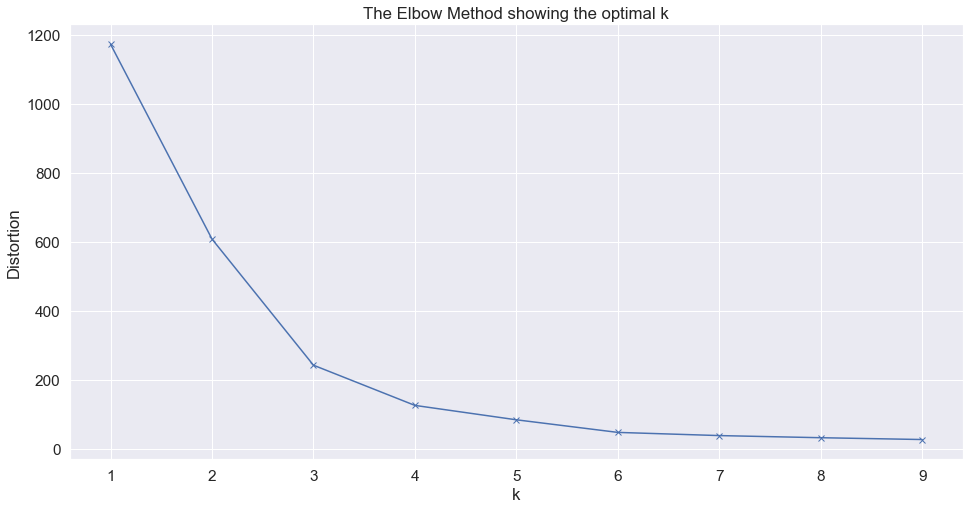

In [88]:
merge_train = pd.read_csv("merge_train.csv", parse_dates = ["loan_date","birth_date"])

df_cluster = merge_train[["sex", "age", "region_0", "region_1", "region_2", "region_3", "average salary"]].copy()
df_cluster["sex"] = df_cluster["sex"].map({'WOMAN': 0, 'MAN': 1})


scaler = StandardScaler()

df_cluster = pd.DataFrame(df_cluster)

pca = PCA(n_components=2)

df_cluster = scaler.fit_transform(df_cluster)
df_cluster = pd.DataFrame(df_cluster)

comps = pca.fit_transform(df_cluster)

principalDf = pd.DataFrame(data = comps, columns = ['principal component 1', 'principal component 2'])

principalDf.rename(columns={0:'principal component 1',1:'principal component 2'},inplace = True)

elbow_curve(principalDf)

For the features used for this clustering, we will have 4 clusters.

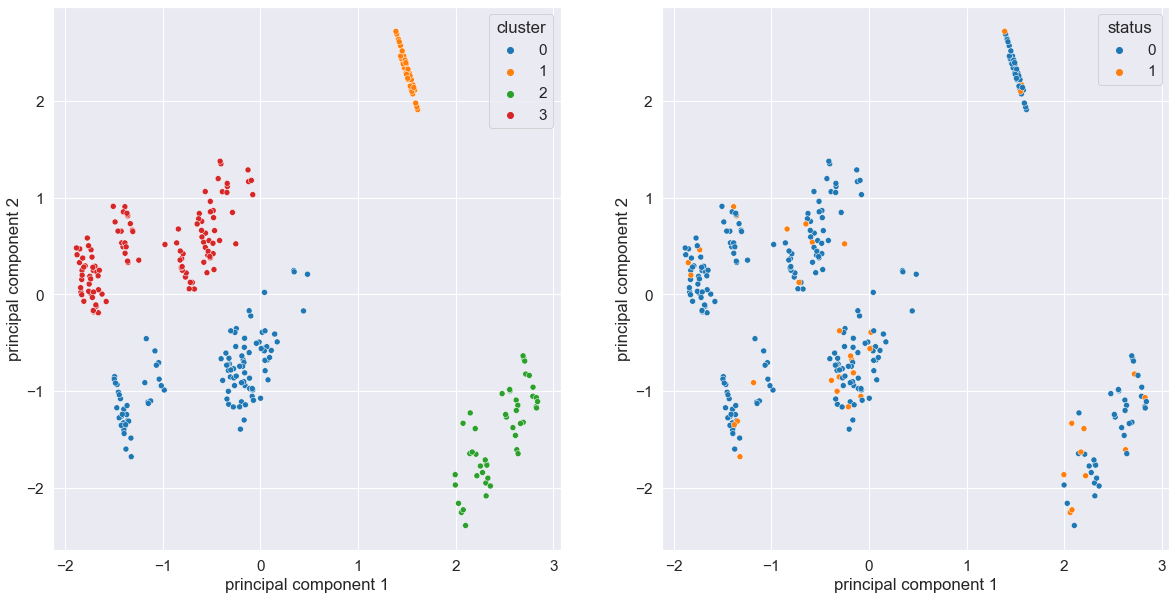

In [89]:
clusters = KMeans(random_state=0, n_clusters=4).fit_predict(principalDf)

principalDf['cluster'] = clusters
principalDf['status'] =  merge_train["status"]
n_colors = len(principalDf['cluster'].unique())

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 2, 1)
sb.scatterplot(x='principal component 1',y='principal component 2',data=principalDf,palette=sb.color_palette("tab10",n_colors),hue='cluster', ax=ax)
ax = fig.add_subplot(1, 2, 2)
sb.scatterplot(x='principal component 1',y='principal component 2',data=principalDf,palette=sb.color_palette("tab10",2),hue='status', ax=ax)

plt.show()


From the clustering above, we can see that the clustering method does not single out any group of entries.  
Although these features do not create any informative cluster, there might be others that do, so we need to keep searching.

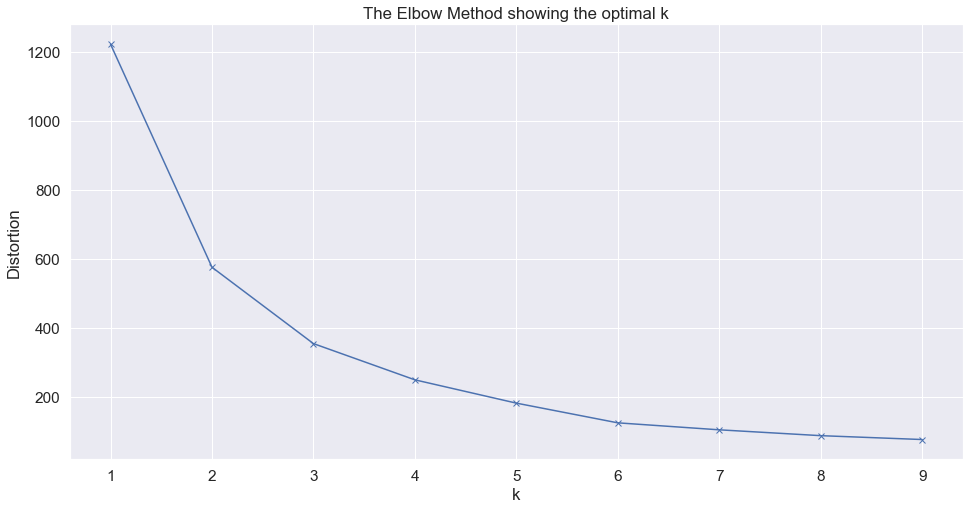

In [90]:
scaler = StandardScaler()

df_cluster = merge_train[["last_balance", "credits_mean", "balance_min", "balance_max", "withdrawal_mean"]].copy()
df_cluster = pd.DataFrame(df_cluster)

pca = PCA(n_components=2)

df_cluster = scaler.fit_transform(df_cluster)
df_cluster = pd.DataFrame(df_cluster)

comps = pca.fit_transform(df_cluster)

principalDf = pd.DataFrame(data = comps, columns = ['principal component 1', 'principal component 2'])

principalDf.rename(columns={0:'principal component 1',1:'principal component 2'},inplace = True)

elbow_curve(principalDf)

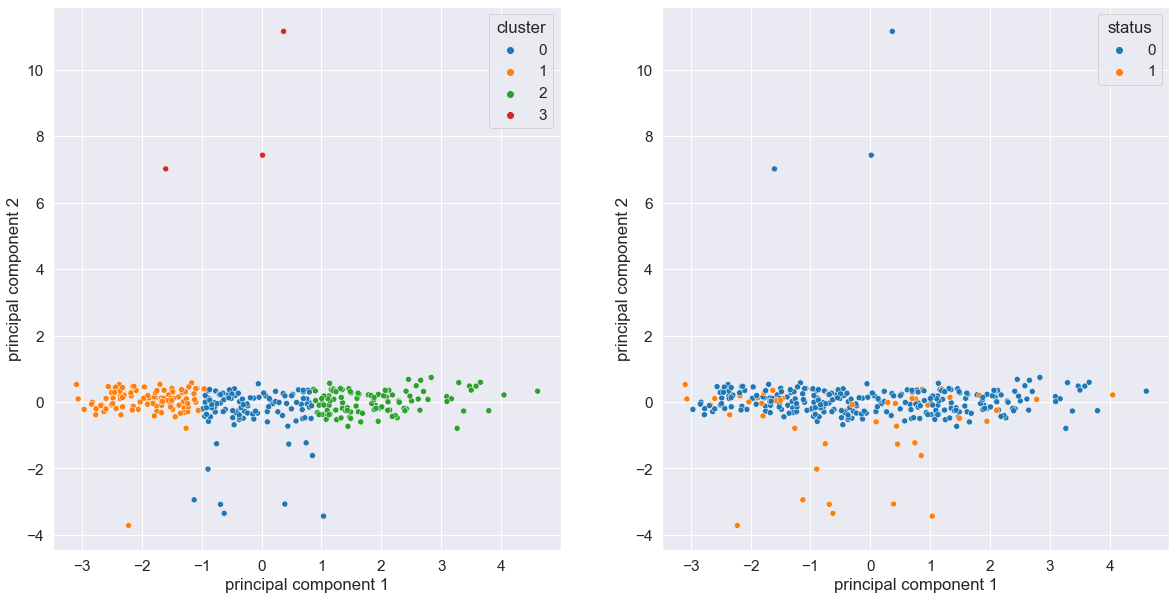

In [91]:
clusters = KMeans(n_clusters=4, random_state=0).fit_predict(principalDf)

principalDf['cluster'] = clusters
principalDf['status'] =  merge_train["status"]
n_colors = len(principalDf['cluster'].unique())

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 2, 1)
sb.scatterplot(x='principal component 1',y='principal component 2',data=principalDf,palette=sb.color_palette("tab10",n_colors),hue='cluster', ax=ax)
ax = fig.add_subplot(1, 2, 2)
sb.scatterplot(x='principal component 1',y='principal component 2',data=principalDf,palette=sb.color_palette("tab10",2),hue='status', ax=ax)

plt.show()

Even though there are some values separeted from the rest of the cluster, there isn't any cluster that we can extract additional or useful information.  
One last clustering done will involve the loan data mixed with the transaction data

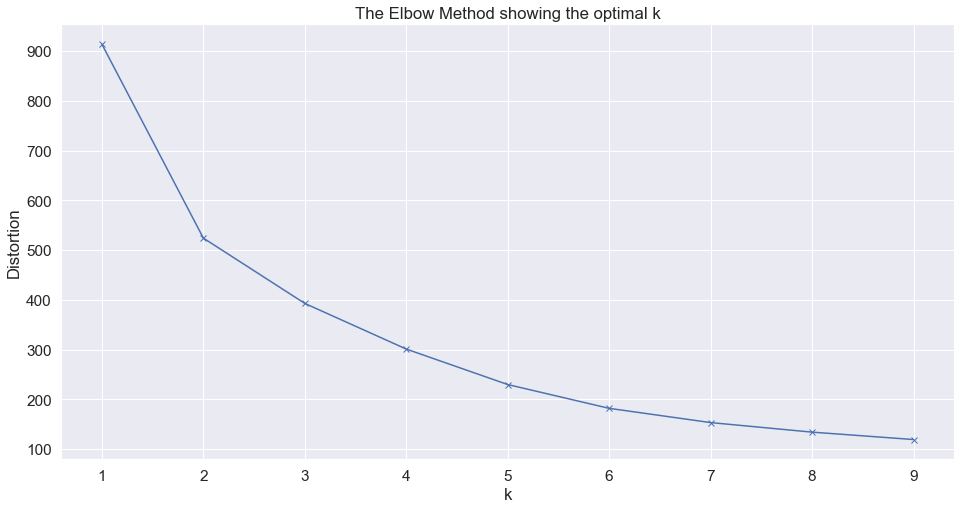

In [92]:
scaler = StandardScaler()

df_cluster = merge_train[["last_balance", "balance_min", "amount", "payments"]].copy()
df_cluster = pd.DataFrame(df_cluster)

pca = PCA(n_components=2)

df_cluster = scaler.fit_transform(df_cluster)
df_cluster = pd.DataFrame(df_cluster)

comps = pca.fit_transform(df_cluster)

principalDf = pd.DataFrame(data = comps, columns = ['principal component 1', 'principal component 2'])

principalDf.rename(columns={0:'principal component 1',1:'principal component 2'},inplace = True)

elbow_curve(principalDf)

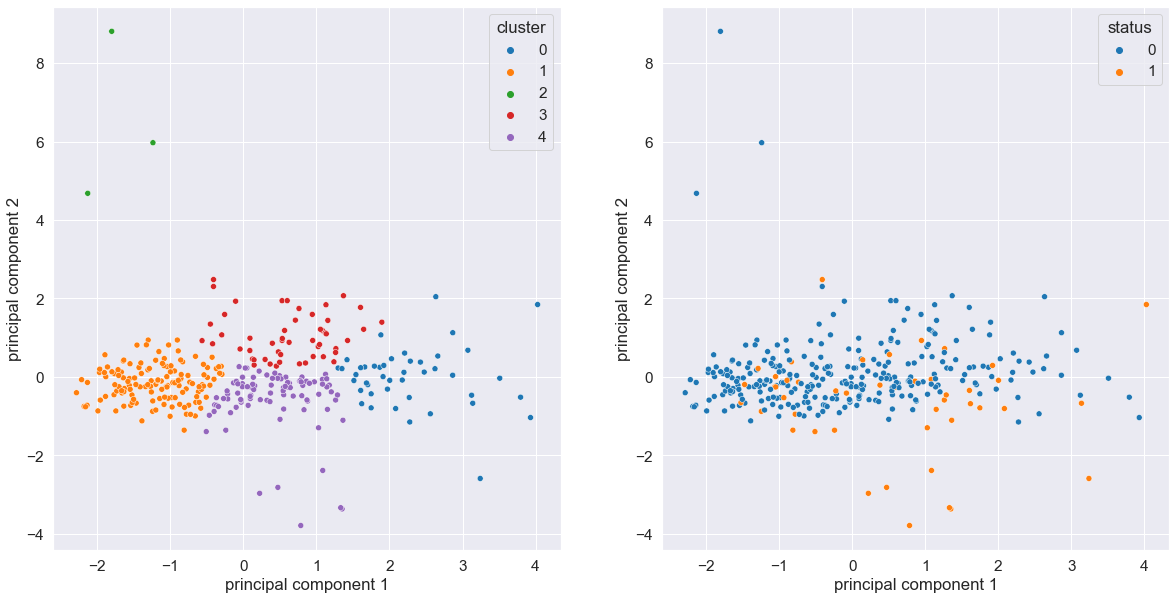

In [93]:
clusters = KMeans(n_clusters=5, random_state=0).fit_predict(principalDf)

principalDf['cluster'] = clusters
principalDf['status'] =  merge_train["status"]
n_colors = len(principalDf['cluster'].unique())

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 2, 1)
sb.scatterplot(x='principal component 1',y='principal component 2',data=principalDf,palette=sb.color_palette("tab10",n_colors),hue='cluster', ax=ax)
ax = fig.add_subplot(1, 2, 2)
sb.scatterplot(x='principal component 1',y='principal component 2',data=principalDf,palette=sb.color_palette("tab10",2),hue='status', ax=ax)

plt.show()

Just like the rest of the clusters done, there isn't any cluster we can extract useful data. 

## Outliers

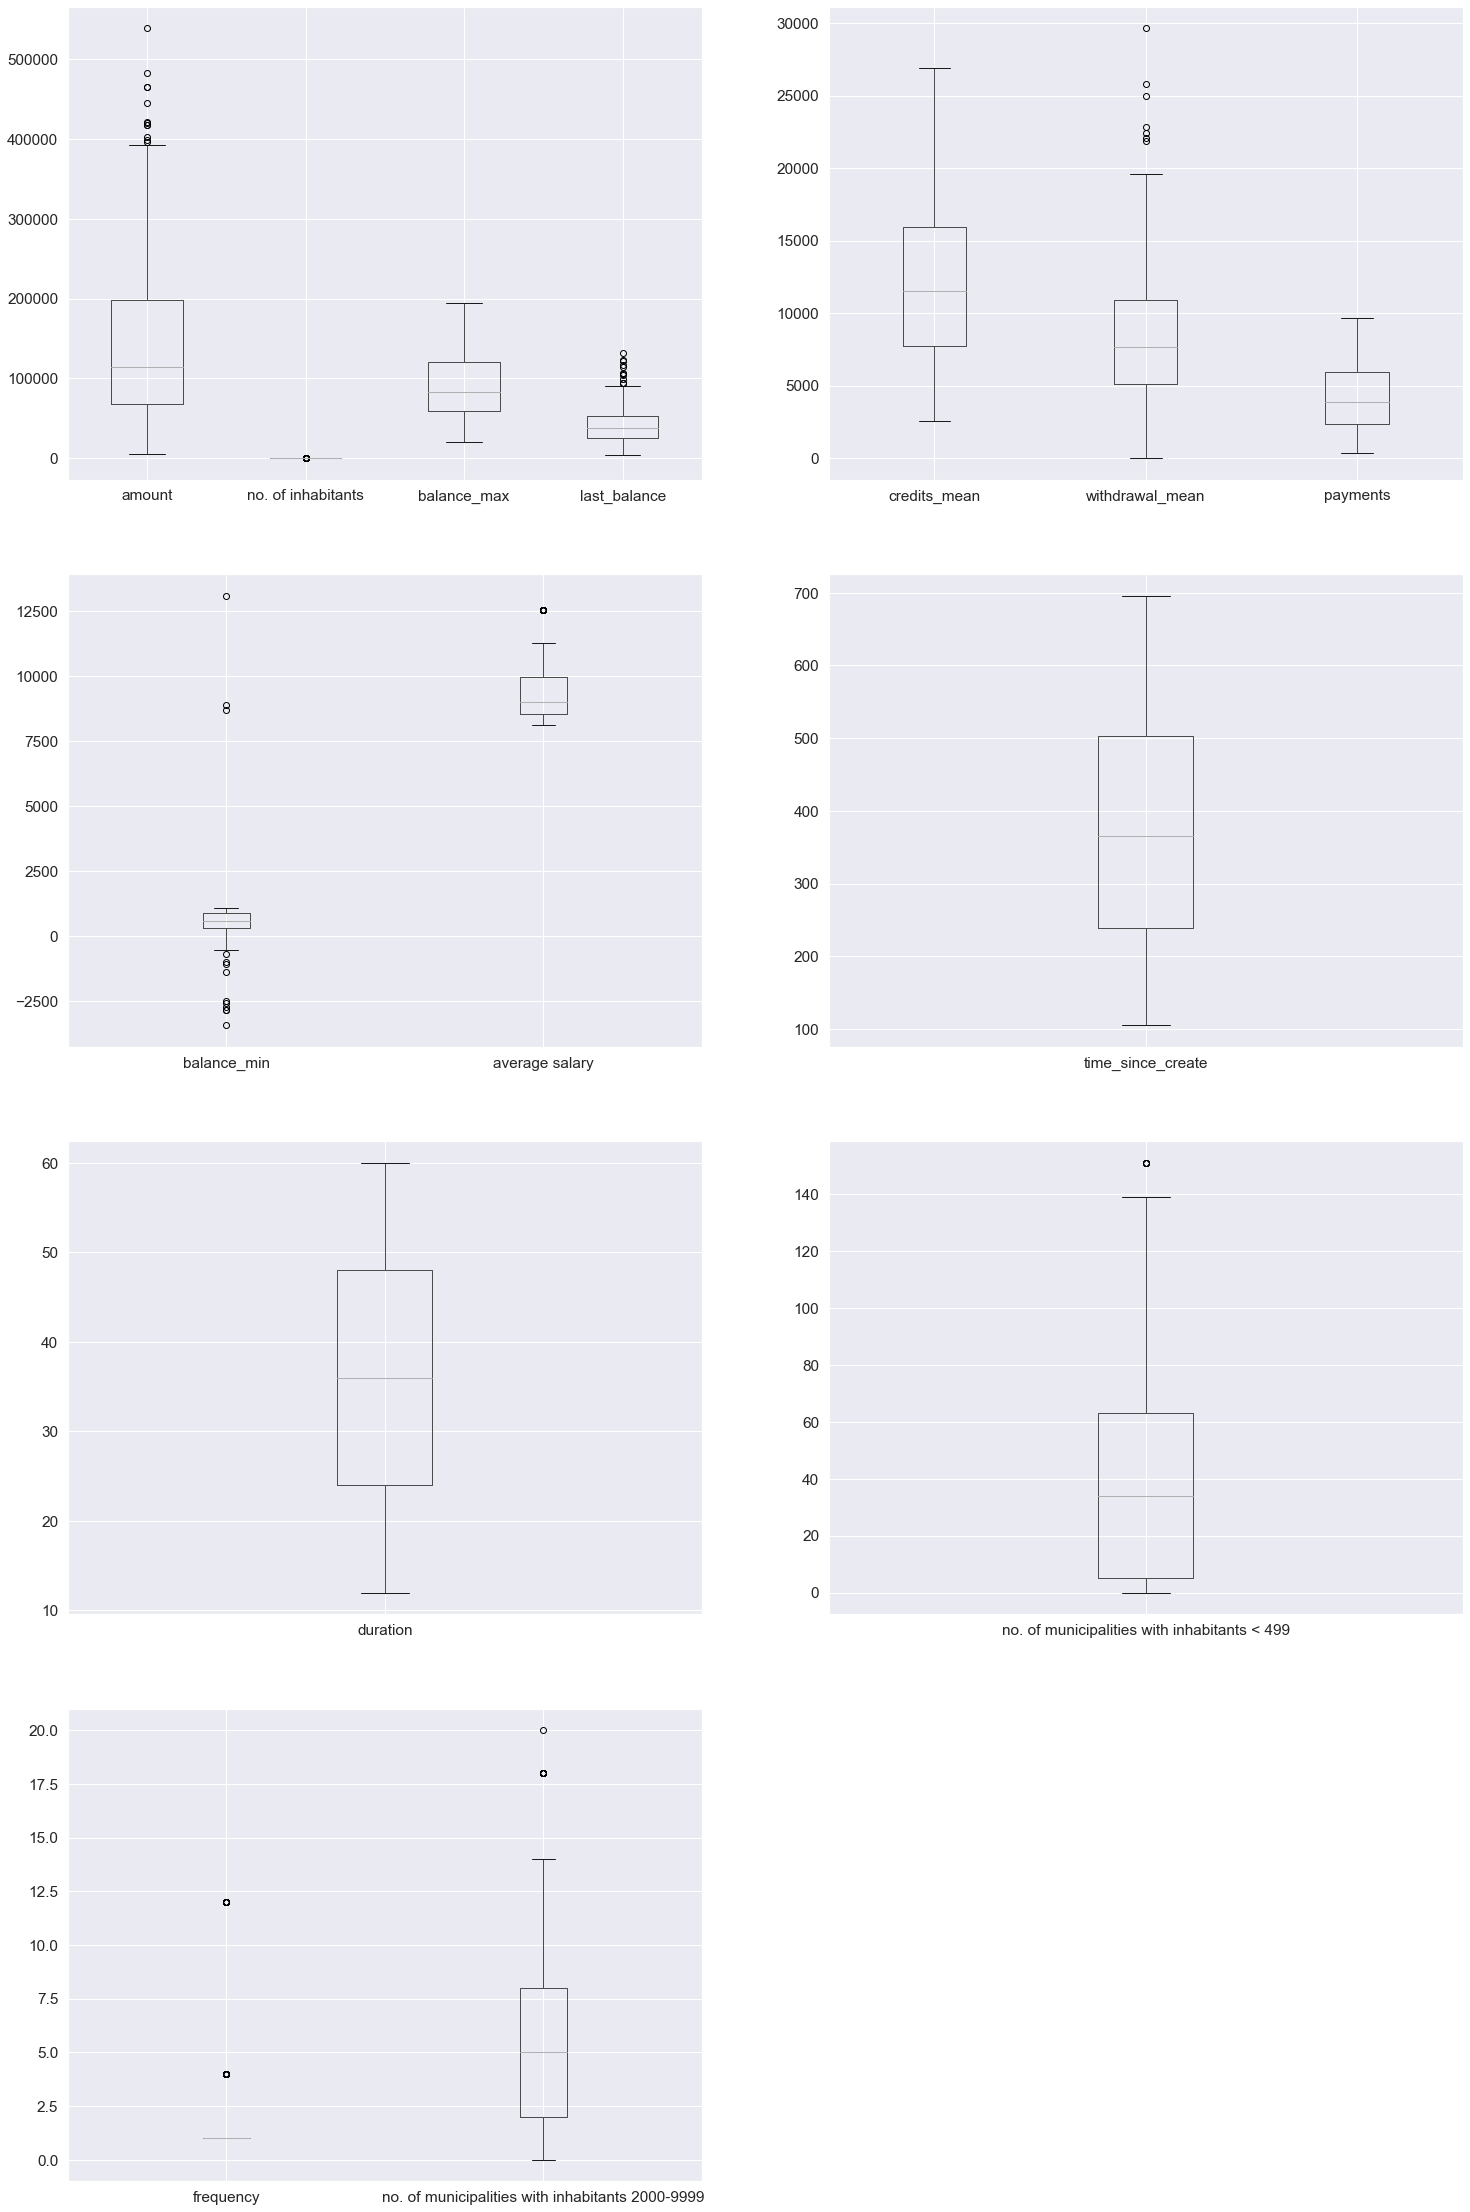

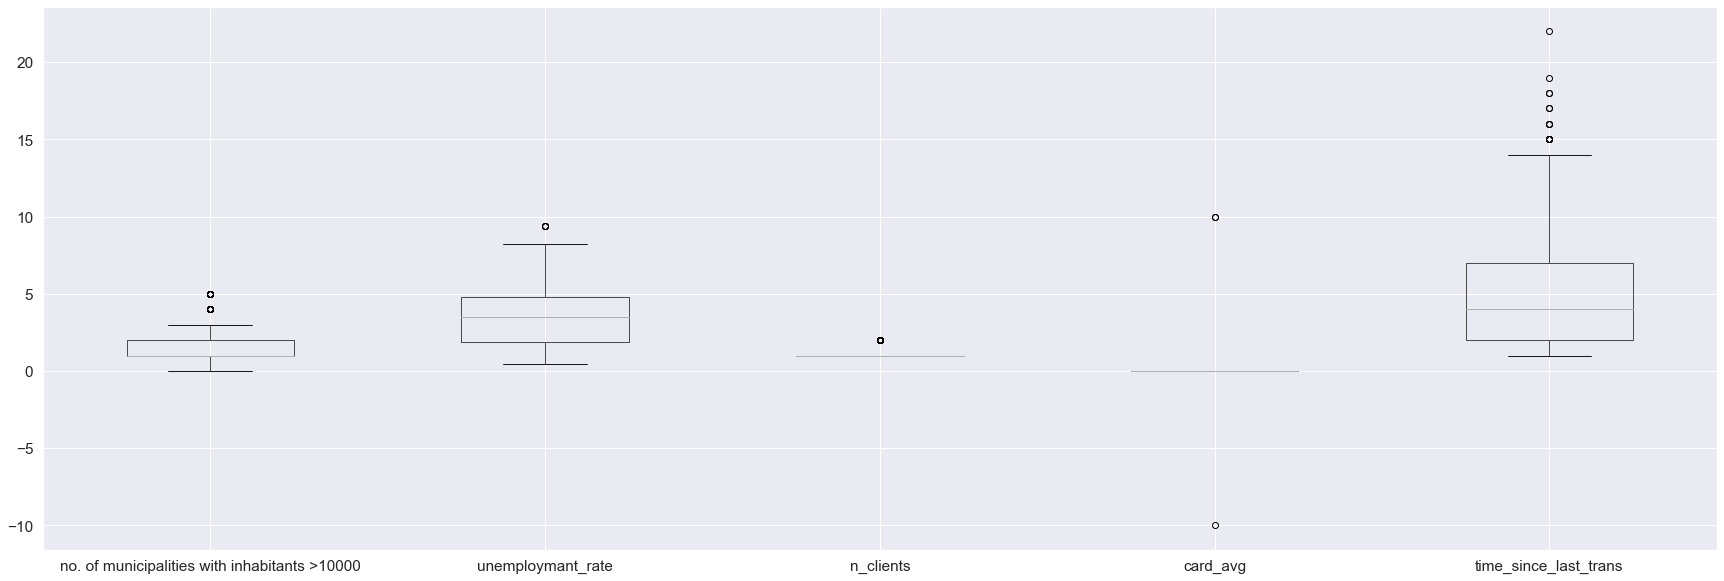

In [94]:
merge_train = pd.read_csv("merge_train.csv", parse_dates = ["loan_date","birth_date"])
fig = plt.figure(figsize=(25,40))


# merge_test.drop(columns=["frequency", "no. of municipalities with inhabitants >10000", "unemploymant_rate", "n_clients", "card_avg", "time_since_last_trans","frequency", "no. of municipalities with inhabitants 2000-9999", "region_0", "region_1", "region_2", "region_3", "no. of municipalities with inhabitants < 499", "duration", "time_since_create", "average salary", "balance_min", "loan_id", "district_id", "client_id", "account_id", "disp_id", "amount" , "no. of inhabitants", "balance_max", "last_balance", "credits_mean" , "withdrawal_mean", "payments"]).boxplot()
ax = fig.add_subplot(4, 2, 1)
merge_train[["amount" , "no. of inhabitants", "balance_max", "last_balance"]].boxplot()
ax = fig.add_subplot(4, 2, 2)
merge_train[["credits_mean" , "withdrawal_mean", "payments"]].boxplot()
ax = fig.add_subplot(4, 2, 3)
merge_train[["balance_min", "average salary"]].boxplot()
ax = fig.add_subplot(4, 2, 4)
merge_train[["time_since_create"]].boxplot()
ax = fig.add_subplot(4, 2, 5)
merge_train[["duration"]].boxplot()
ax = fig.add_subplot(4, 2, 6)
merge_train[["no. of municipalities with inhabitants < 499"]].boxplot()
ax = fig.add_subplot(4, 2, 7)
merge_train[["frequency", "no. of municipalities with inhabitants 2000-9999"]].boxplot()
plt.show()
fig = plt.figure(figsize=(30,10))
merge_train[["no. of municipalities with inhabitants >10000", "unemploymant_rate", "n_clients", "card_avg", "time_since_last_trans"]].boxplot()

plt.show()

After creating a box plot for the features, we can see little dots above the box. The dots are outliers.  
To deal with these outliers we first need to make sure we can change/delete them.

In [95]:
countAmount1 = merge_train[(merge_train['amount'] > 440000) & (merge_train["status"]==1)]
countAmount0 = merge_train[(merge_train['amount'] > 440000) & (merge_train["status"]==0)]
print("A total of {} rows with status 1 were considered outliers and a total of {} rows with status equal to 0 were considered outliers when looking at the amount feature.".format(len(countAmount1), len(countAmount0)))

A total of 2 rows with status 1 were considered outliers and a total of 3 rows with status equal to 0 were considered outliers when looking at the amount feature.


In [96]:
countSalary1 = merge_train[(merge_train['average salary'] > 12000) & (merge_train["status"]==1)]
countSalary0 = merge_train[(merge_train['average salary'] > 12000) & (merge_train["status"]==0)]
print("A total of {} rows with status 1 were considered outliers and a total of {} rows with status equal to 0 were considered outliers when looking at the average district salary feature.".format(len(countSalary1), len(countSalary0)))

A total of 7 rows with status 1 were considered outliers and a total of 39 rows with status equal to 0 were considered outliers when looking at the average district salary feature.


We might be inclined on assuming these values as outlier, however, before being certain of this, a closer analysis must be done.

In [97]:
idx0 = np.intersect1d(countAmount0.index, countSalary0.index)
idx1 = np.intersect1d(countAmount1.index, countSalary1.index)

print("There are a total of {} rows that is/are present in both outliers groups for status 0 and a total of {} rows that is/are present in both outliers groups for status 1".format(idx0.size, idx1.size))

There are a total of 0 rows that is/are present in both outliers groups for status 0 and a total of 1 rows that is/are present in both outliers groups for status 1


Since there isn't a high correlation between the tested group of outliers, we can conclude that they are indeed outliers and can be dealt with.

In [98]:
merge_train_no_out = merge_train[(merge_train['amount'] <= 440000)]  
merge_train_no_out = merge_train_no_out[(merge_train_no_out['average salary'] <= 12000)]
merge_train_no_out.to_csv('merge_train_no_out.csv', index=False)

To test if dropping outliers helps the classifiers, the data without the outliers will be saved in an additional file, where it will be compared to another file keeping the outliers.

## Data Quality

Before we start predicting results, we have all data needed so we can analyse some dimension of the Data Quality:
- **No Completeness**: Since there are some non optional missing values in the data, we can claim that there is no completeness in the data, for example in the district table, some values are missing.
- **No Consistency**: There does not exist consistency in, for example, the `type` and the `operation` of the table **transactions**. Even though there is a type "withdrawal in cash", some types are still labeled as only "withdrawal" even though the operation is "withdrawal in cash" and the other way around too.
- **No Conformity**: The data does not have conformity as, for example, every genral date follow the same pattern (YYMMDD) however the birthdate of the clients follow it's own specific pattern.
- **No Accuracy**: As shown by [this article](https://voxeu.org/article/sex-and-credit-there-gender-bias-lending), the gender makes a huge difference when analysing if a client should or should not receive a loan. This, however, does not exist in our dataset as the gender does not have impact in the prediction.
- **No Integrity**: Since some clients do not have any loan records, their record is dropped.
- **No Timeliness**: There is no timeliness since the data we are working with is more than 20 years old.

## Feature Engineering

In order to start the feature engineering process, it is first necessary to merge all tables in order to apply the same opeartion to both test and train data.

In [99]:
merge_train = pd.read_csv("merge_train.csv", parse_dates = ["loan_date","birth_date"])
merge_test = pd.read_csv("merge_test.csv", parse_dates = ["loan_date","birth_date"])
merge_train_no_out = pd.read_csv("merge_train_no_out.csv", parse_dates = ["loan_date","birth_date"])


merge_train = merge_train.drop(columns=["district_id","account_id","client_id","disp_id", "loan_date", "birth_date", "sex", "disp_type"])
merge_test = merge_test.drop(columns=["district_id","account_id","client_id","disp_id", "loan_date", "birth_date", "sex", "disp_type"])
merge_train_no_out = merge_train_no_out.drop(columns=["district_id","account_id","client_id","disp_id", "loan_date", "birth_date", "sex", "disp_type"])

merge_train.head()

loan_id  amount  duration  payments  status  frequency  region_0  region_1  \
0     5314   96396        12      8033       1          4         0         1   
1     5316  165960        36      4610       0          1         0         1   
2     6863  127080        60      2118       0          1         0         1   
3     5325  105804        36      2939       0          1         0         0   
4     7240  274740        60      4579       0          4         0         0   

   region_2  region_3  ...  last_balance  credits_mean  withdrawal_mean  \
0         0         0  ...       20100.0   5025.000000             0.00   
1         1         0  ...       52208.9  13523.158824          8884.24   
2         1         0  ...       20272.8   5009.733333          6097.00   
3         1         0  ...       34307.3   9254.600000          7168.10   
4         0         1  ...       41112.9  21255.930769         16801.00   

   balance_min  balance_max  n_clients  card_avg  time_since_create  \
0       1100.0      20100.0          1         0                105   
1        700.0     120512.8          1         0                148   
2        800.0      49590.4          1         0                170   
3       1000.0      65898.5          1         0                185   
4        600.0     122893.1          1         0                204   

   time_since_last_trans  age  
0                     15   46  
1                      2   25  
2                      7   58  
3                      3   54  
4                      6   15  

[5 rows x 30 columns]

Since there are a large number of columns we need to start trimming/merging them. The first to be merged are the number of municipalities with different population. All different columns were merged into a single one.

In [100]:
merge_train["no. of municipalities"] = merge_train["no. of municipalities with inhabitants 2000-9999"] + merge_train["no. of municipalities with inhabitants 500-1999"] + merge_train["no. of municipalities with inhabitants < 499"] + merge_train["no. of municipalities with inhabitants >10000"]
merge_test["no. of municipalities"] = merge_test["no. of municipalities with inhabitants 2000-9999"] + merge_test["no. of municipalities with inhabitants 500-1999"] + merge_test["no. of municipalities with inhabitants < 499"] + merge_test["no. of municipalities with inhabitants >10000"]
merge_train_no_out["no. of municipalities"] = merge_train_no_out["no. of municipalities with inhabitants 2000-9999"] + merge_train_no_out["no. of municipalities with inhabitants 500-1999"] + merge_train_no_out["no. of municipalities with inhabitants < 499"] + merge_train_no_out["no. of municipalities with inhabitants >10000"]

## Feature Selection

### Embedded Method

After testing without any type of embedded method, the Random Forest Classifier revealed to be the best one. After this conclusion, it was decided to make a feature selector for this classifier only since making one for each classifier would be impractical.

In [101]:
def feature_selector(classifier, n_features, n_splits):
    return SequentialFeatureSelector(classifier,
           k_features=n_features,
           forward=True,
           floating=False,
           scoring='roc_auc',
           cv=StratifiedKFold(n_splits=n_splits))

In [102]:
features = feature_selector(RandomForestClassifier(n_jobs=-1), 10, 3).fit(merge_train.drop(columns=["status"]), merge_train["status"])
print(list(features.k_feature_idx_))


[1, 3, 4, 19, 21, 22, 23, 24, 25, 27]


In [103]:
filtered_features = merge_train.columns[list(features.k_feature_idx_)]
feature_string = []
for feature in filtered_features: feature_string.append(feature)
if "region_0" in feature_string or "region_1" in feature_string or "region_2" in feature_string or "region_3" in feature_string:
    feature_string.extend(["region_0","region_1", "region_2","region_3"])
    feature_string = list(set(feature_string))

feature_string.extend(["status", "loan_id"])


In [104]:
print(merge_train[feature_string])

     amount  payments  status  no. of enterpreneurs per 1000 inhabitants  \
0     96396      8033       1                                        100   
1    165960      4610       0                                        117   
2    127080      2118       0                                        132   
3    105804      2939       0                                        137   
4    274740      4579       0                                        167   
..      ...       ...     ...                                        ...   
323  155616      3242       0                                        110   
324  222180      3703       1                                        113   
325   45024       938       0                                         81   
326  115812      3217       0                                        107   
327  129408      5392       0                                        109   

     credits_mean  withdrawal_mean  balance_min  balance_max  n_clients  \
0     5025.0

In [105]:
merge_train[feature_string].to_csv("merge_train_rdc_emb.csv")
merge_test[feature_string].to_csv("merge_test_rdc_emb.csv")

Saving this data to a new CSV file, it is possbile to later compare the results of this feature selection using embedded methods, to the selected features using other feature selection methods.

### Anova Test

In order to try to decrease the number of features a bit more, an **Anova test** is done. This test gives a score depending how usefull it thinks the features are. This will help selecting some columns which do not provide any useful information to our models.

In [106]:
bestfeatures = SelectKBest(score_func = f_classif,k = "all")
fit = bestfeatures.fit(merge_train, merge_train["status"])

d = {'feature' : merge_train.columns.tolist(), 'values' : fit.scores_}
anova_df = pd.DataFrame(data=d)
anova_df.sort_values("values", ascending=False)


C:\Users\Utilizador\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


feature     values
4                                             status        inf
23                                       balance_min  17.658363
25                                         n_clients  16.565041
3                                           payments   9.518871
20                                      last_balance   6.407870
1                                             amount   5.450596
21                                      credits_mean   5.343836
28                             time_since_last_trans   5.001300
0                                            loan_id   4.918689
6                                           region_0   2.858053
7                                           region_1   2.122396
27                                 time_since_create   2.036491
5                                          frequency   1.737441
8                                           region_2   1.604477
30                             no. of municipalities   1.511511
9                                           region_3   1.384218
12   no. of municipalities with inhabitants 500-1999   1.208090
11      no. of municipalities with inhabitants < 499   1.073769
15                                     no. of cities   0.443437
13  no. of municipalities with inhabitants 2000-9999   0.366018
14     no. of municipalities with inhabitants >10000   0.330159
29                                               age   0.234578
22                                   withdrawal_mean   0.194406
17                                    average salary   0.186247
24                                       balance_max   0.128700
16                        ratio of urban inhabitants   0.110299
19         no. of enterpreneurs per 1000 inhabitants   0.105194
10                                no. of inhabitants   0.089889
26                                          card_avg   0.054106
18                                 unemploymant_rate   0.005841
2                                           duration   0.004079

### Chi Squared

It was also done the chi squared test, but the results of this test were ignored as it works best for categorical data.

In [107]:
bestfeatures = SelectKBest(score_func = chi2,k = "all")
merge_train_scaled = scale_min_max(merge_train)
fit = bestfeatures.fit(merge_train_scaled, merge_train["status"])

d = {'feature' : merge_train.columns.tolist(), 'values' : fit.scores_}
anova_df = pd.DataFrame(data=d)
anova_df.sort_values("values", ascending=False)

feature      values
4                                             status  282.000000
25                                         n_clients   12.234043
6                                           region_0    2.407363
3                                           payments    1.243317
7                                           region_1    1.080207
5                                          frequency    1.018434
28                             time_since_last_trans    0.934406
1                                             amount    0.795606
8                                           region_2    0.768924
0                                            loan_id    0.740593
21                                      credits_mean    0.675509
9                                           region_3    0.672270
20                                      last_balance    0.644939
27                                 time_since_create    0.342090
23                                       balance_min    0.306829
30                             no. of municipalities    0.250823
11      no. of municipalities with inhabitants < 499    0.220042
12   no. of municipalities with inhabitants 500-1999    0.213006
15                                     no. of cities    0.087700
13  no. of municipalities with inhabitants 2000-9999    0.066578
17                                    average salary    0.052483
14     no. of municipalities with inhabitants >10000    0.045966
29                                               age    0.034534
16                        ratio of urban inhabitants    0.020381
10                                no. of inhabitants    0.017228
19         no. of enterpreneurs per 1000 inhabitants    0.016850
22                                   withdrawal_mean    0.015507
24                                       balance_max    0.012942
18                                 unemploymant_rate    0.001050
2                                           duration    0.001001
26                                          card_avg    0.000248

### Feature Inportance Random Forest
After the tests done with both anova and chi squared, it is also necessary to check the feature importance given by Random Forest.

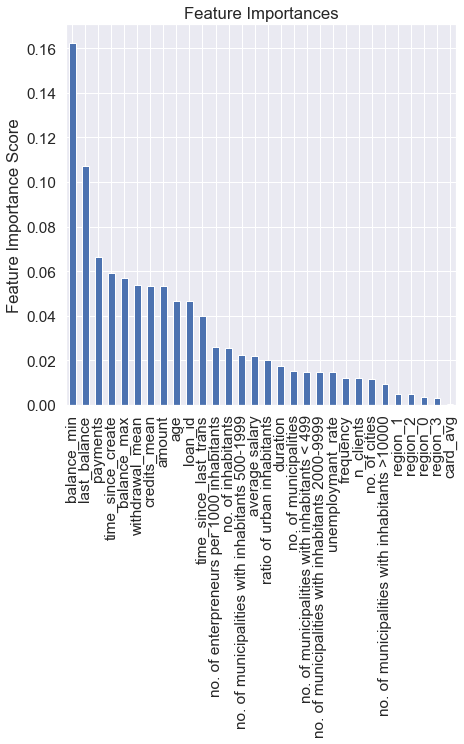

In [108]:
rfc = RandomForestClassifier()

x_train = merge_train.drop(columns=["status"])
y_train = merge_train["status"]
x_test = merge_test.drop(columns=["status"])
y_tesst = merge_test["status"]

rfc.fit(x_train, y_train)

plt.figure(figsize=(7,7))
predictors = [x for x in x_train]
feat_imp = pd.Series(rfc.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.draw()

The feature importance given by the random forest classifier also confirms the anova test results. All the features chosen by the anova test are important according to the random forest classifier. There are some that are slightly higher rate, however, the difference is almost nonexistant (under or equal to 0.01) so the classification can be done using the parameters selected by the anova test.

With the anova results, it was decided to drop every feature with importance less than 5. This meant we would significantly reduce the number of features used for the training models.

In [109]:
merge_train.drop(columns=["balance_max","no. of cities", "no. of municipalities with inhabitants < 499", "no. of municipalities with inhabitants 500-1999","no. of municipalities with inhabitants >10000", "no. of municipalities with inhabitants 2000-9999", "withdrawal_mean", "average salary"
                          , "no. of enterpreneurs per 1000 inhabitants", "ratio of urban inhabitants", "no. of inhabitants", "card_avg", "unemploymant_rate","age"], inplace = True)
merge_test.drop(columns=["balance_max","no. of cities", "no. of municipalities with inhabitants < 499", "no. of municipalities with inhabitants 500-1999", "no. of municipalities with inhabitants >10000", "no. of municipalities with inhabitants 2000-9999", "withdrawal_mean", "average salary"
                          , "no. of enterpreneurs per 1000 inhabitants", "ratio of urban inhabitants", "no. of inhabitants", "card_avg", "unemploymant_rate","age"], inplace = True)
merge_train_no_out.drop(columns=["balance_max","no. of cities", "no. of municipalities with inhabitants < 499", "no. of municipalities with inhabitants 500-1999", "no. of municipalities with inhabitants >10000", "no. of municipalities with inhabitants 2000-9999", "withdrawal_mean", "average salary"
                          , "no. of enterpreneurs per 1000 inhabitants", "ratio of urban inhabitants", "no. of inhabitants", "card_avg", "unemploymant_rate"], inplace = True)

# lower than 5 score in anova
merge_test.drop(columns = ["region_3","no. of municipalities","region_2","frequency","time_since_create","region_1","region_0", "duration"], inplace = True)
merge_train_no_out.drop(columns = ["region_3","no. of municipalities","region_2","frequency","time_since_create","region_1","region_0", "duration"], inplace = True)

merge_train.drop(columns = ["region_3","no. of municipalities","region_2","frequency","time_since_create","region_1","region_0", "duration"], inplace = True)

After dropping the unwanted features, the remaining ones were analysed again to see if anything changed.

In [110]:
bestfeatures = SelectKBest(score_func = f_classif,k = "all")
fit = bestfeatures.fit(merge_train,merge_train["status"])

d = {'feature' : merge_train.columns.tolist(), 'values' : fit.scores_}
anova_df = pd.DataFrame(data=d)
anova_df.sort_values("values", ascending=False)

C:\Users\Utilizador\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


feature     values
3                 status        inf
6            balance_min  17.658363
7              n_clients  16.565041
2               payments   9.518871
4           last_balance   6.407870
1                 amount   5.450596
5           credits_mean   5.343836
8  time_since_last_trans   5.001300
0                loan_id   4.918689

In [111]:
print(merge_train.head())

merge_train.to_csv("merge_train.csv", index=False)
merge_train_no_out.to_csv("merge_train_no_out.csv", index=False)
merge_test.to_csv("merge_test.csv", index=False)

   loan_id  amount  payments  status  last_balance  credits_mean  balance_min  \
0     5314   96396      8033       1       20100.0   5025.000000       1100.0   
1     5316  165960      4610       0       52208.9  13523.158824        700.0   
2     6863  127080      2118       0       20272.8   5009.733333        800.0   
3     5325  105804      2939       0       34307.3   9254.600000       1000.0   
4     7240  274740      4579       0       41112.9  21255.930769        600.0   

   n_clients  time_since_last_trans  
0          1                     15  
1          1                      2  
2          1                      7  
3          1                      3  
4          1                      6  


### SMOTE Oversampling

Since the data acquired was extremely skewed, a oversampling technic was done to the data, when performing the training.  
Since it was also done a cross validation method, some caution was taken to ensure the smote technic was only done to the training split.

In [112]:
def smote(train, train_classes):
    sm = SMOTE()
    X_res, Y_res = sm.fit_resample(train, train_classes)
    return X_res,Y_res
        


## Classification

After dealing with the data, it was time to start using classifiers to try to predict the status column.

In [113]:
#load data used to train
merge_train = pd.read_csv("merge_train.csv")
merge_train_no_out = pd.read_csv("merge_train_no_out.csv")
merge_train_rdc_emb = pd.read_csv("merge_train_rdc_emb.csv")

### Grid Search

A generic function was created to simplify the **grid search** done by every classifier.

In [114]:
def grid_search(model, n_splits, parameter_grid, scale=False):
    cross_validation = StratifiedKFold(n_splits=n_splits)


    grid_search = GridSearchCV(model,
                               param_grid=parameter_grid,
                               cv=cross_validation, scoring='roc_auc')

    grid_df = merge_train
    if scale:
        X_train_decision, y_train_decision = smote(grid_df.drop(columns=["status"]), grid_df["status"])
        X_train_decision, _ = scale_data(X_train_decision,pd.DataFrame())

    else:
        X_train_decision, y_train_decision = smote(grid_df.drop(columns=["status"]), grid_df["status"])
    grid_search.fit(X_train_decision, y_train_decision)

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))

    return grid_search.best_estimator_

### Validation Technique

#### Scaling

Since some models do not accept negative data a function was created to scale the data. This mean to turn any numerical column and it's values and make them fit an interval of 0 to 1.

In [115]:
def scale_data(train, test):
    scaler = StandardScaler()
    scaler.fit(train)
    train = scaler.transform(train)
    if not test.empty:
        test = scaler.transform(test)
    return train, test

#### Stratified Cross Validation

To mitigate and detect when overfit was being done, a custom coss validation function was created. 

In [116]:
def train_model(model, train, test, fold_no, do_smote, scaling=False):
    
    X_train = train[train.columns.difference(['status'])]
    y_train = train['status']
    X_test = test[test.columns.difference(["status"])]
    y_test = test['status']
    
    if(scaling):
        X_train, X_test = scale_data(X_train, X_test)
        
    if type(model) == ComplementNB or type(model) == VotingClassifier:
        X_train, X_test = scale_min_max(X_train, X_test)
            
    if do_smote:
        X_train, y_train = smote(X_train,y_train)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    predictions_proba = model.predict_proba(X_test)
    predictions_proba = predictions_proba[:,1]
    
    # precision, recall, _ = precision_recall_curve(y_test, predictions_proba)
    # plt.plot(recall, precision, alpha=0.3,
    #              label='PR fold %d (AP = %0.2f, AUC = %0.2f)' % (fold_no, average_precision_score(y_test, predictions_proba), auc(recall, precision)))

    fpr, tpr, _ = roc_curve(y_test, predictions_proba)
    plt.plot(fpr, tpr, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (fold_no, auc(fpr, tpr)))

    
    return (model, X_train, y_train, X_test, y_test, predictions_proba, predictions)
    
def cross_val(model, df, n_splits, do_smote, scaling=False):
    fig = plt.figure(figsize=(7,5))
    results = []
    target = df['status'].values
    skf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3)

    fold_no = 1
    for train_index, test_index in skf.split(df, target):
        train = df.iloc[train_index]
        test = df.iloc[test_index]
        
        results.append(train_model(model, train, test, fold_no, do_smote, scaling))
        fold_no += 1

    y_test_all = []
    predictions_proba_all = []
    predictions_all = []

    for result in results:
        (_, _, _, _, y_test, predictions_proba, predictions) = result
        y_test_all.append(y_test)
        predictions_proba_all.append(predictions_proba)
        predictions_all.append(predictions)
        
    y_test_all = np.concatenate(y_test_all)
    predictions_proba_all = np.concatenate(predictions_proba_all)
    predictions_all = np.concatenate(predictions_all)
    
    fpr, tpr, _ = roc_curve(y_test_all, predictions_proba_all)

    plt.rcParams["figure.figsize"] = 10,7
    plt.plot(fpr, tpr, color='b',
    label=r'ROC (AUC = %0.2f)' % (auc(fpr, tpr)),
    lw=2, alpha=.8)
    plt.legend()
    plt.title("ROC Curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.draw()
    
    return (y_test_all, predictions_proba_all, predictions_all, fpr, tpr)

The following fucntion is the main function used to make any classification. It is as generic as possible in order to be able to work with any classifier.  
This function receives a model and any other information needed to perform the cross validation and after completing it's task, the functoin also print some aditional information such as the **ROC Curve** of the completed classification.  
On top of that, this function also keeps track of the time needed to perform a classification, returning it at the end.

In [117]:
def perform_classification(model, train, fold_no, do_smote, is_regression=False, scaling=False):
    start_time = time.time()
    train = train.drop(columns=["loan_id"])
    (testing_classes, predictions_proba, predictions, fpr, tpr) = cross_val(model, train, fold_no, do_smote, scaling)
    
    class_report = classification_report(testing_classes, predictions, output_dict=True)
    print("Classification Report:")
    print(classification_report(testing_classes, predictions))

    plt.figure(figsize=(7,7))
    confusion_matrix = pd.crosstab(testing_classes, predictions, rownames=['Actual'], colnames=['Predicted'])
    sb.heatmap(confusion_matrix, annot=True)
    plt.title("Confusion Matrix")
    plt.draw()
    
    if is_regression:
        print("F2 Score: {}".format(fbeta_score(testing_classes, predictions, beta=2)))
        print("Cohen's Kappa Score: {}".format(cohen_kappa_score(testing_classes, predictions)))
        print("Matthews Correlation Coefficient (MCC): {}".format(matthews_corrcoef(testing_classes, predictions)))
        print("\n")
        print('Mean Absolute Error (MAE):', mean_absolute_error(testing_classes, predictions))
        print('Mean Squared Error (MSE):', mean_squared_error(testing_classes, predictions))
        print('R Squared:', r2_score(testing_classes, predictions))
      
    if type(model) in [RandomForestClassifier]:
        plt.figure(figsize=(7,7))
        predictors = [x for x in train.columns if x not in ['status']]
        feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.draw()
    end_time = time.time()
    return (end_time - start_time, auc(fpr, tpr), fpr, tpr, class_report)

The following function is used to format the output file to a format accepted by kaggle.

In [118]:
def submit_test(model, train, test, probs=True, column=1, scaling=False, do_smote=False):
    if(model == 'logistic'):
        classifier = LogisticRegression(C=0.25, solver="liblinear", penalty="l2",max_iter=500000)
        print("Starting LogisticRegression")
    elif(model == 'svm'):
        classifier = svm.SVC(kernel='linear', probability=True, max_iter=-1)
        print("Starting SVM")
    elif(model == 'decision'):
        classifier = DecisionTreeClassifier()
        print("Starting DecisionTreeClassifier")
    elif(model == 'random_forest'):
        classifier = RandomForestClassifier(criterion='gini', max_depth=10, max_features="sqrt", n_estimators=100)
        print("Starting RandomForestClassifier")
    elif(type(model) != "string"):
        classifier = model
    else:
        return None

    X_train = train.drop(columns=['status', 'loan_id'])
    y_train = train['status']
    
    X_test = test.drop(columns=['status', 'loan_id'])
    
    if do_smote:
        X_train, y_train = smote(X_train,y_train)
        
    if(scaling):
        X_train, X_test = scale_data(X_train, X_test)
        
    if type(classifier) == ComplementNB or type(classifier) == VotingClassifier:
        X_train, X_test = scale_min_max(X_train, X_test)
        
    classifier.fit(X_train, y_train)
    
    if probs:
        predictions = classifier.predict_proba(X_test)
        predictions = predictions[:,column]
    else:
        predictions = classifier.predict(X_test)
    
    df_predictions = pd.DataFrame({"Id": test.loan_id.values, "Predicted": predictions})
    #df_predictions['Predicted'] = df_predictions['Predicted'].apply(lambda x: 1 - x)
    
    if(type(model) == str):
        path = 'tests/' + model + '_predictions.csv'
    else:
        path = 'tests/' + type(model).__name__ + '_predictions.csv'
    df_predictions.to_csv(path, index=False)
    print(df_predictions)
    return df_predictions

### Support Vector Machine

A support-vetor machine maps the data it receives into a space where the gap between labels is maximized. After creating this space, the testing data is also placed into it, and depending on which side it falls, thats the prediction the algorithm will give.

In [119]:
#as the grid search takes too much time, some values were hard codded to the constructor
svc_clf = svm.SVC(kernel='linear', probability=True, max_iter=-1) 
 
# parameter_grid = {
#   'C': [1, 10, 100, 1000], 
#   'gamma': [0.001, 0.0001], 
#   'kernel': ['rbf', 'linear'],
#   "random_state":[42]
#   }
 
# svc_clf = grid_search(svc_clf, 3, parameter_grid)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       846
           1       0.31      0.64      0.42       138

    accuracy                           0.75       984
   macro avg       0.62      0.71      0.63       984
weighted avg       0.84      0.75      0.78       984

Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       846
           1       1.00      0.15      0.26       138

    accuracy                           0.88       984
   macro avg       0.94      0.58      0.60       984
weighted avg       0.90      0.88      0.84       984

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.74      0.82       720
           1       0.28      0.65      0.39       114

    accuracy                           0.72       834
   macro avg       0.61      0.69      0.61       834
weigh

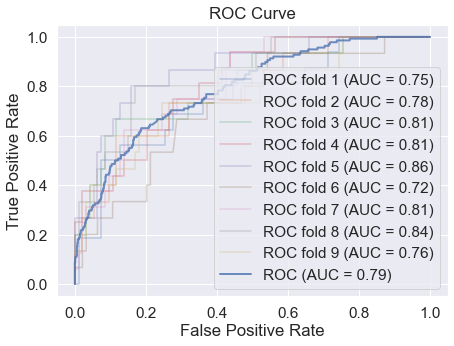

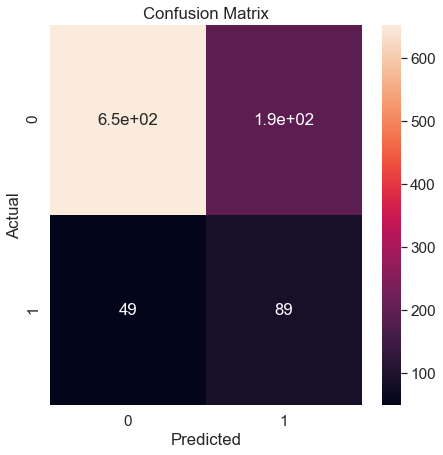

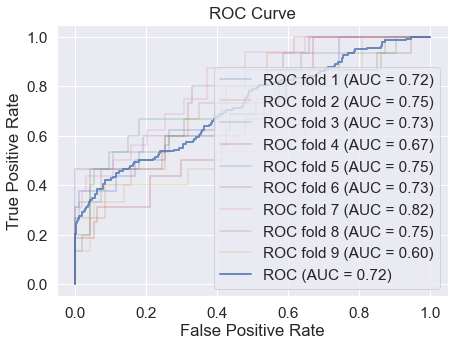

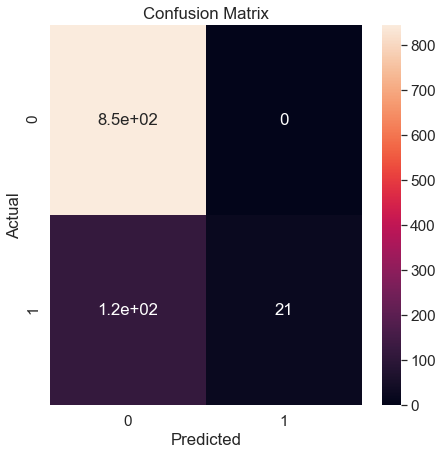

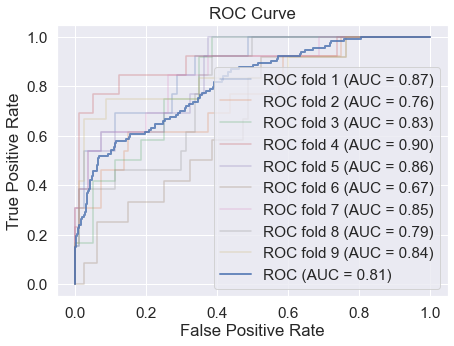

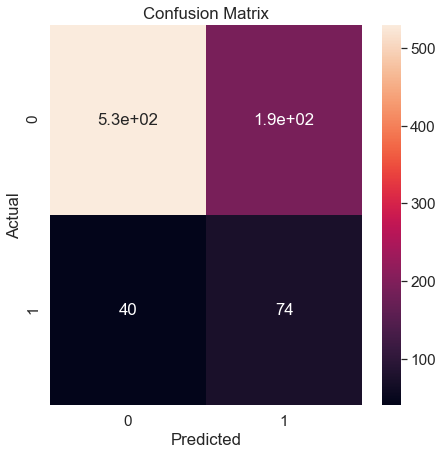

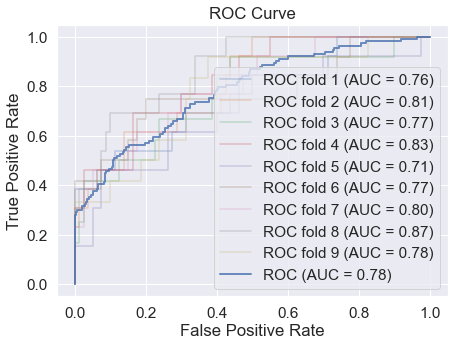

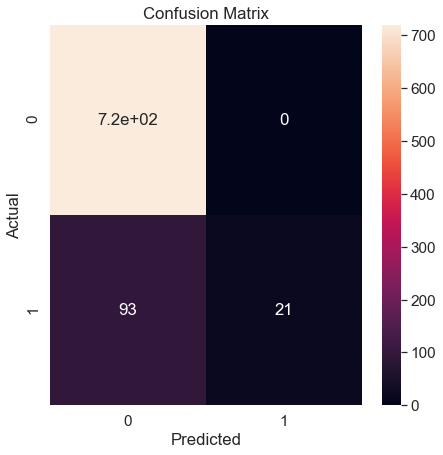

In [120]:
do_smote=True
svm_time, svm_auc, fpr_svm, tpr_svm, svm_class_rep = perform_classification(svc_clf, merge_train, 3, do_smote, scaling=True)
do_smote=False
svm_time_nosmote,svm_auc_nosmote,_,_, svm_class_rep_nosmote = perform_classification(svc_clf, merge_train, 3, do_smote, scaling=True)
do_smote=True
svm_time_noout,svm_auc_noout,_,_, svm_class_rep_noout = perform_classification(svc_clf, merge_train_no_out, 3, do_smote, scaling=True)
do_smote=False
svm_time_nosmote_noout,svm_auc_nosmote_noout,_,_, svm_class_rep_nosmote_noout = perform_classification(svc_clf, merge_train_no_out, 3, do_smote, scaling=True)

### Logistic Regression

In statistics, the logistic model (or logit model) is used to model the probability of a certain class or event existing such as pass/fail, win/lose, alive/dead or healthy/sick.


In [121]:
merge_train = pd.read_csv('merge_train.csv')

In [122]:
logreg = LogisticRegression()

In [123]:
parameter_grid = {'C': [0.001, 0.01, 0.1, 0.25, 0.5, 1],
                  'solver': ['liblinear', 'newton-cg', 'lbfgs'],
                  "random_state":[42]
                 }

logreg = grid_search(logreg, 3, parameter_grid, scale=True)

Best score: 0.8627961370152407
Best parameters: {'C': 1, 'random_state': 42, 'solver': 'liblinear'}


- C: The C parameter controls the penality strength. For smaller values of C the regulization of the model is increased, which creates a simple models that are underfit. For higher values of C, the regulization of the model is decreased, which will create overfit models because the complexity is higher. Because of this, it was expected that the model would select a higher value, and because of this, the values given were not very big.
- Solver: The selected solver was newton-cg. This is because Newton's algorithm uses a better quadratic function minimisation.

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.73      0.81       846
           1       0.28      0.64      0.39       138

    accuracy                           0.72       984
   macro avg       0.60      0.68      0.60       984
weighted avg       0.83      0.72      0.75       984

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       846
           1       0.65      0.22      0.33       138

    accuracy                           0.87       984
   macro avg       0.77      0.60      0.63       984
weighted avg       0.85      0.87      0.85       984

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       720
           1       0.29      0.64      0.40       114

    accuracy                           0.73       834
   macro avg       0.61      0.69      0.61       834
weigh

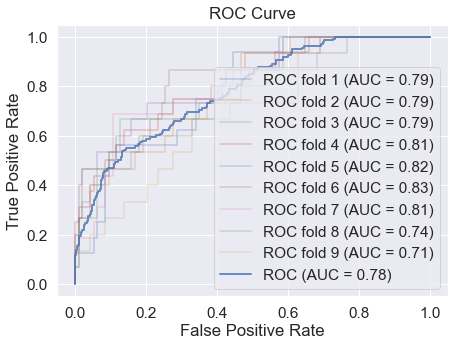

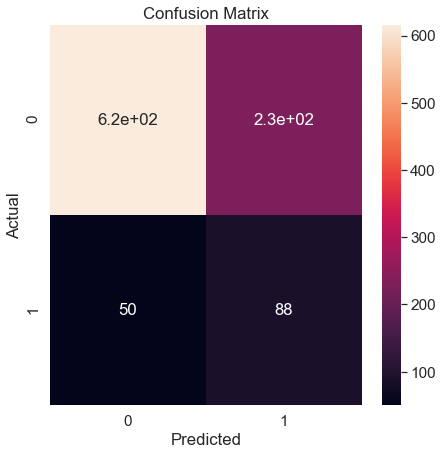

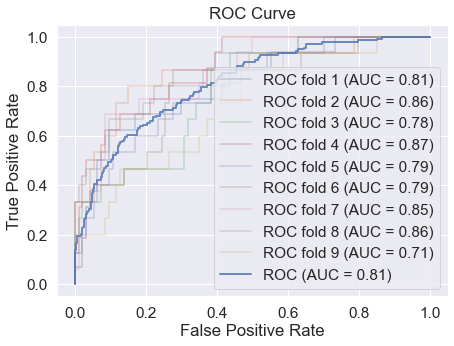

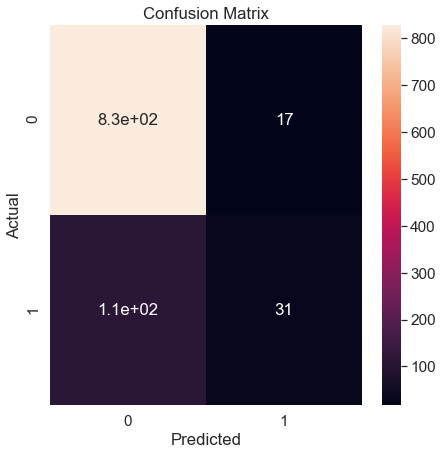

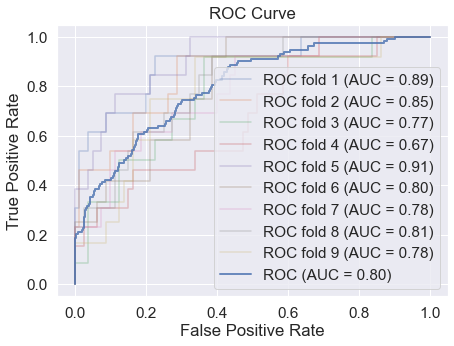

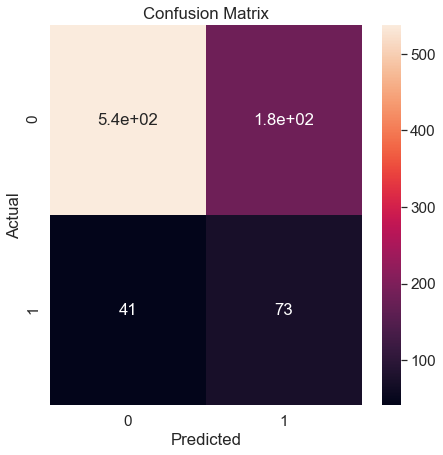

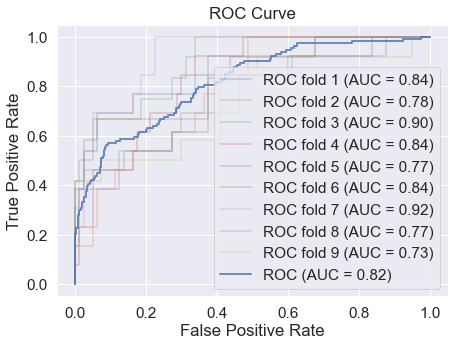

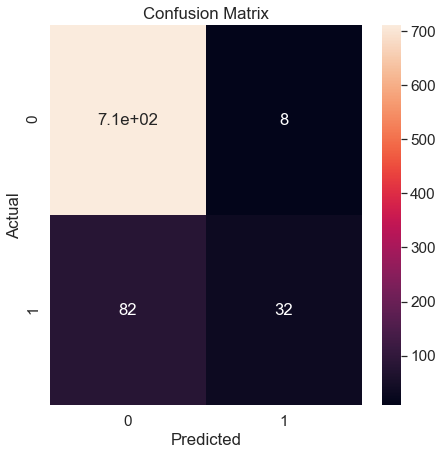

In [124]:
do_smote=True
logreg_time,logreg_auc, fpr_logreg, tpr_logreg, logreg_class_rep = perform_classification(logreg, merge_train, 3, do_smote, scaling=True)
do_smote=False
logreg_time_nosmote,logreg_auc_nosmote,_,_, logreg_class_rep_nosmote = perform_classification(logreg, merge_train, 3, do_smote, scaling=True)
do_smote=True
logreg_time_noout,logreg_auc_noout,_,_, logreg_class_rep_noout = perform_classification(logreg, merge_train_no_out, 3, do_smote, scaling=True)
do_smote=False
logreg_time_nosmote_noout,logreg_auc_nosmote_noout,_,_, logreg_class_rep_nosmote_noout = perform_classification(logreg, merge_train_no_out, 3, do_smote, scaling=True)

### Decision Tree

In [125]:
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=6, max_features=4, splitter='best')

In [126]:
parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5, 6],
                  'max_features': [1, 2, 3, 4, 5],
                 "random_state":[69]}

# grid_search(dtc, 3, parameter_grid)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.74      0.82       846
           1       0.28      0.59      0.38       138

    accuracy                           0.72       984
   macro avg       0.60      0.67      0.60       984
weighted avg       0.83      0.72      0.76       984

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       846
           1       0.60      0.42      0.49       138

    accuracy                           0.88       984
   macro avg       0.75      0.69      0.71       984
weighted avg       0.87      0.88      0.87       984

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.79      0.85       720
           1       0.28      0.50      0.36       114

    accuracy                           0.75       834
   macro avg       0.59      0.65      0.60       834
weigh

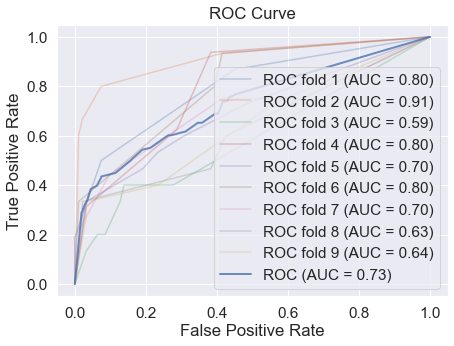

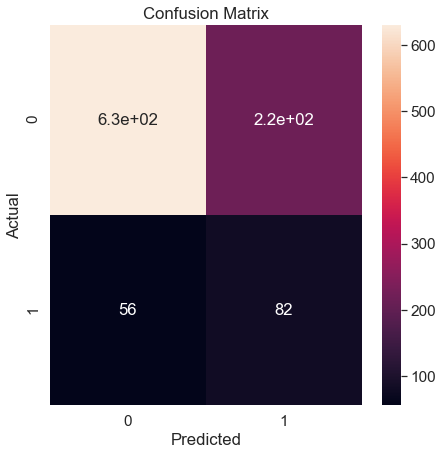

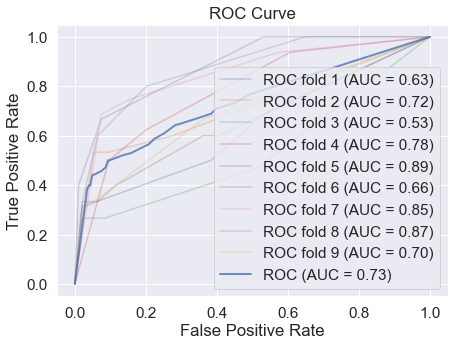

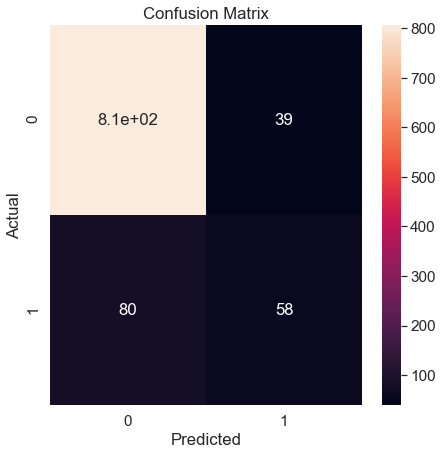

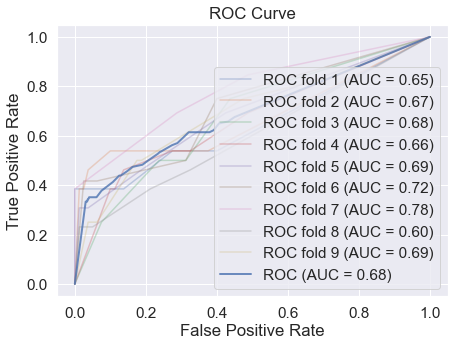

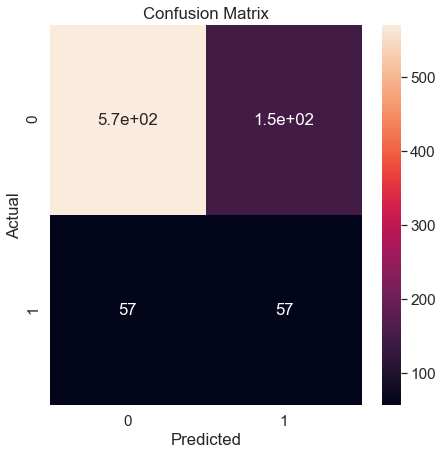

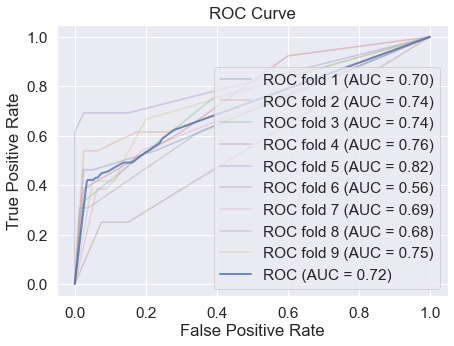

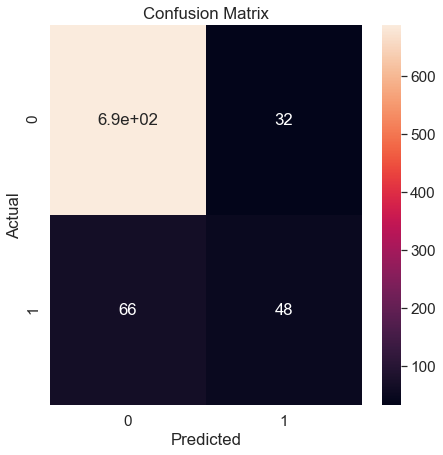

In [127]:
do_smote = True
dtc_time,dtc_auc, fpr_dtc, tpr_dtc, dtc_class_rep  = perform_classification(dtc, merge_train, 3, do_smote, scaling=False)
do_smote = False
dtc_time_nosmote,dtc_auc_nosmote,_,_, dtc_class_rep_nosmote = perform_classification(dtc, merge_train, 3, do_smote, scaling=False)
do_smote = True
dtc_time_noout,dtc_auc_noout,_,_, dtc_class_rep_noout = perform_classification(dtc, merge_train_no_out, 3, do_smote, scaling=False)
do_smote = False
dtc_time_nosmote_noout,dtc_auc_nosmote_noout,_,_, dtc_class_rep_nosmote_noout = perform_classification(dtc, merge_train_no_out, 3, do_smote, scaling=False)

### Random Forest

Random forest is a flexible, easy to use machine learning algorithm that produces, even without hyper-parameter tuning, a great result most of the time. This classifier uses n decision trees to make it's classification, calculating it's prediction from the output of all the decision trees.

In [128]:
rfc = RandomForestClassifier()

In [129]:
parameter_grid = {
    'max_depth': [7,8,9,10],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'n_estimators': [75, 100, 150, 200],
    "random_state":[42]
}

rfc = grid_search(rfc, 3, parameter_grid)

Best score: 0.9792892711634223
Best parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 150, 'random_state': 42}


- Max Depth: How many leaves the model will have. In this case, as expected, the grid search chose the max number of depth as it will divide the data more, managing to get better results. This sometimes leads to overfitting the model, however, since we have little number of features and the features used for each decision tree is also small.
- Max Features: To mitigate the possible overfit caused by the max depth only `log2` of features were selected. This mean, out of all the features passed to the classifier, only ```log2(n_features)``` were used while training each decision tree.
- Criterion: The `gini` criterion's goal is to measure how often a randomly chosen element from the set would be incorrectly labeled, which, in our case, the chances will be low, as there are a lot more status of 1 than 0. The other possible criterion, the `entropy`, uses a similar concept however, it is more computationally heavy. Instead of utilizing simple probabilities, this method takes the log base2 of the probabilities. Nevertheless, as the results are so similar, it does not seem to be worth the time invested in training when using the entropy criterion.
- Number of estimators: The number of decision trees created. 150 were selected as the result obtained did not vary much when more trees are added. Because of this, the smaller number of trees that give the same result is the best, as the computation time is also smaller.


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       846
           1       0.47      0.49      0.48       138

    accuracy                           0.85       984
   macro avg       0.69      0.70      0.69       984
weighted avg       0.85      0.85      0.85       984

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       846
           1       0.82      0.34      0.48       138

    accuracy                           0.90       984
   macro avg       0.86      0.66      0.71       984
weighted avg       0.89      0.90      0.88       984

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       720
           1       0.51      0.53      0.52       114

    accuracy                           0.87       834
   macro avg       0.72      0.72      0.72       834
weigh

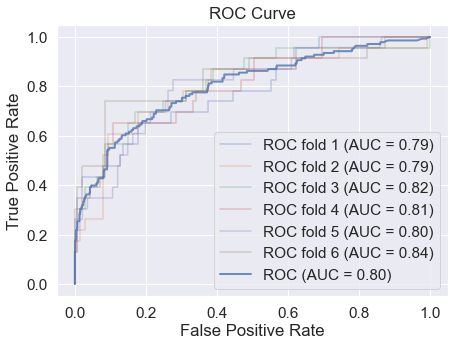

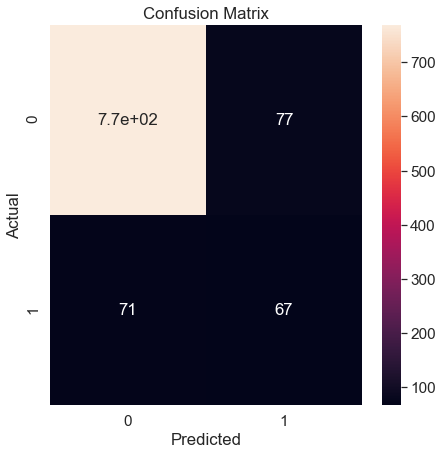

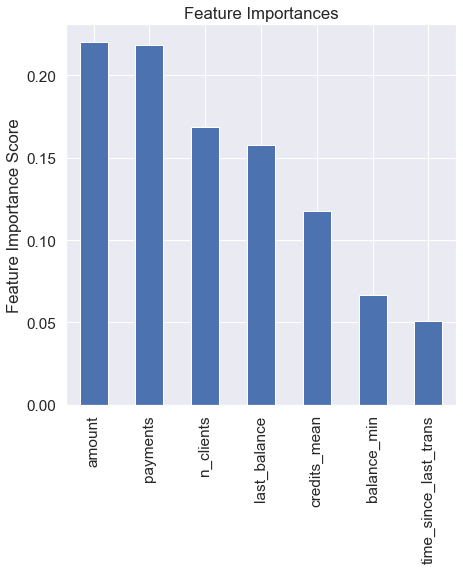

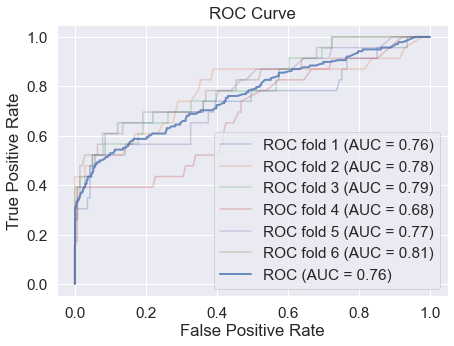

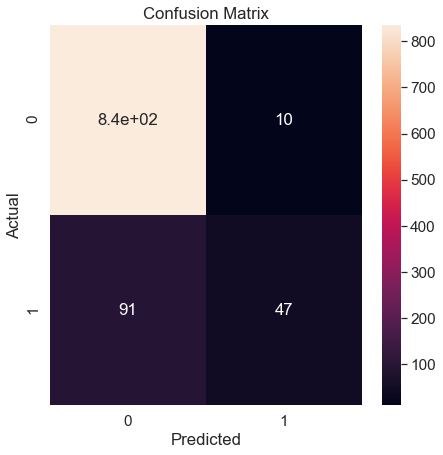

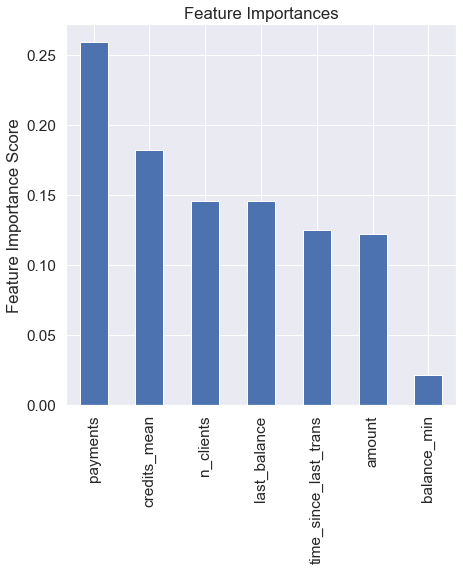

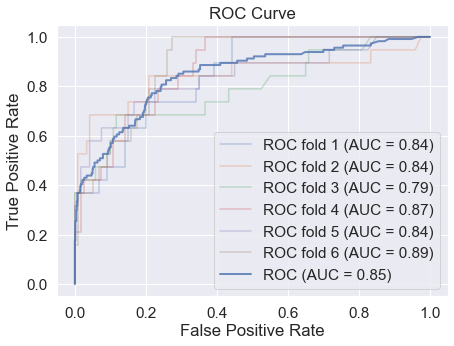

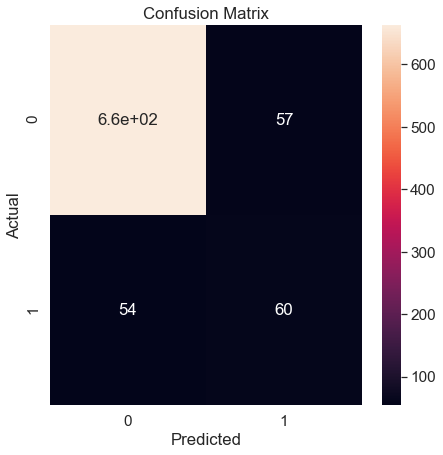

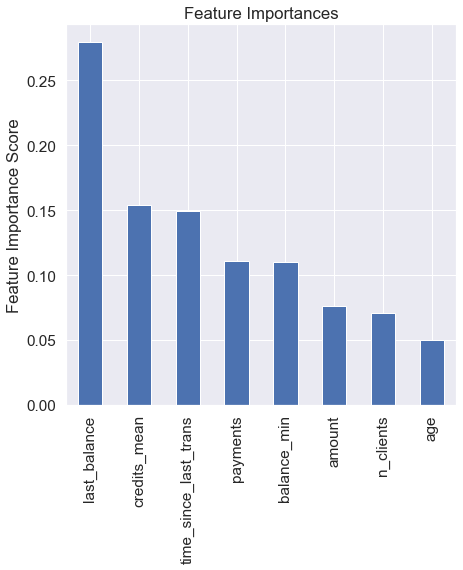

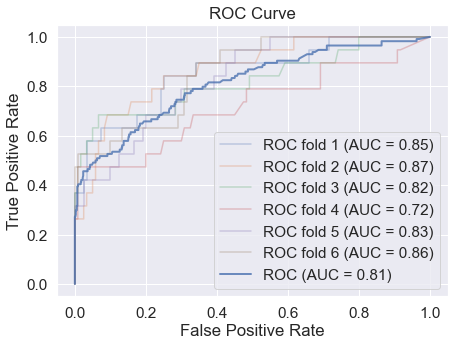

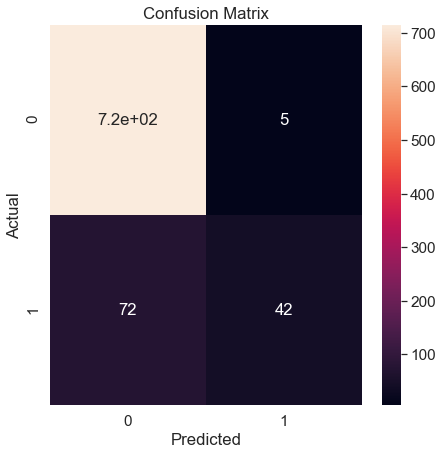

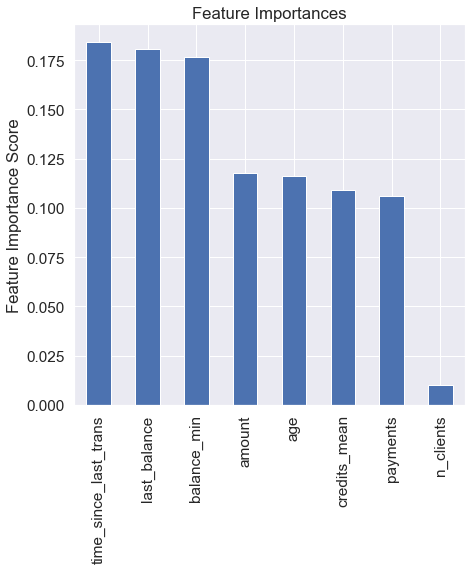

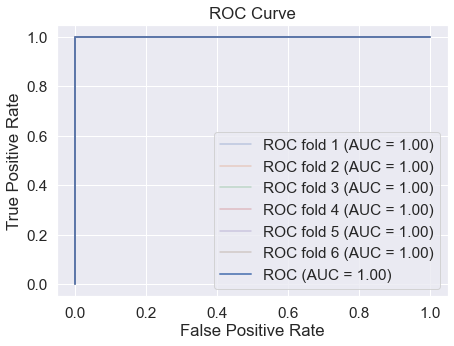

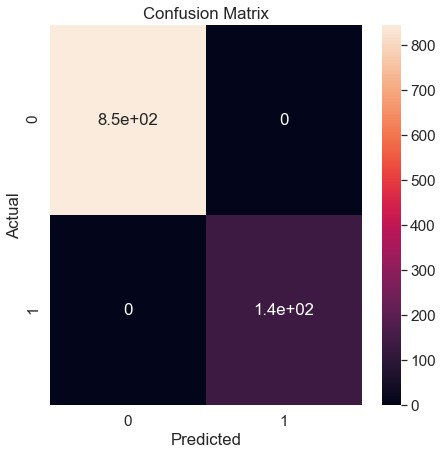

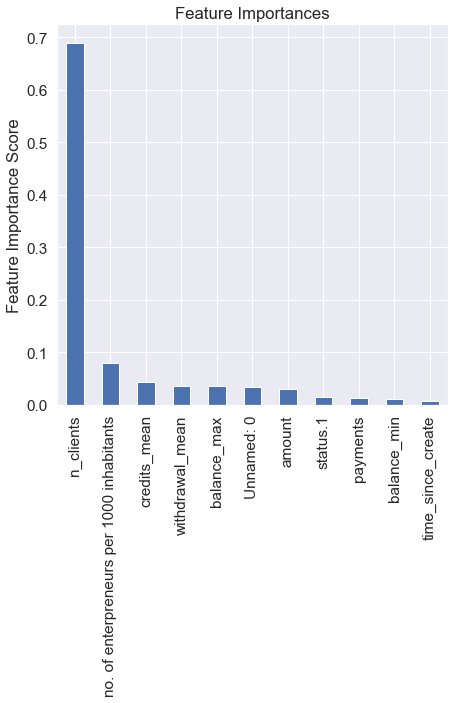

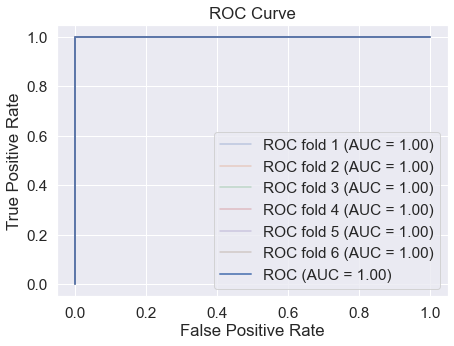

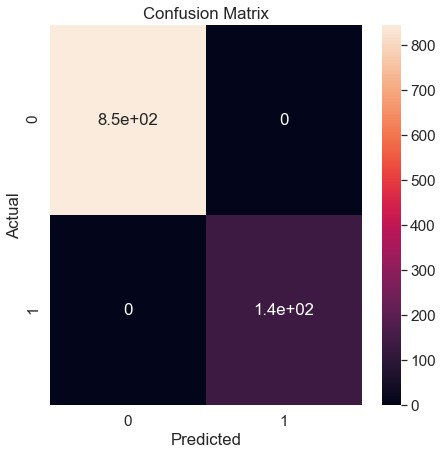

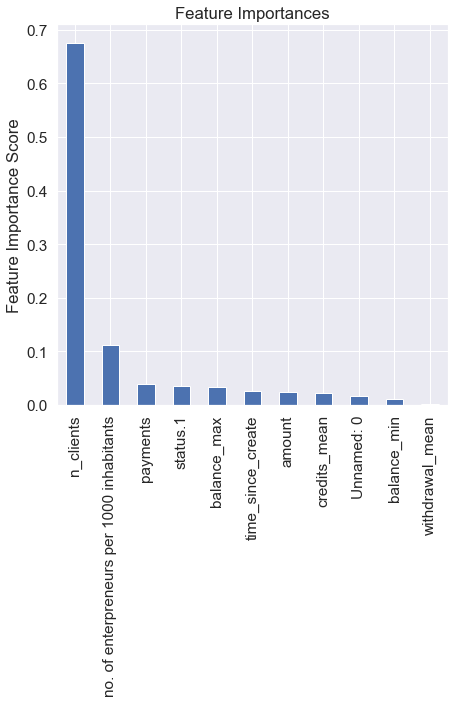

In [130]:
do_smote = True
rfc_time,rfc_auc, fpr_rfc, tpr_rfc, rfc_class_rep = perform_classification(rfc, merge_train, 2, do_smote, scaling=False)
do_smote = False
rfc_time_nosmote,rfc_auc_nosmote,_,_, rfc_class_rep_nosmote = perform_classification(rfc, merge_train, 2, do_smote, scaling=False)
do_smote = True
rfc_time_noout,rfc_auc_noout,_,_, rfc_class_rep_noout = perform_classification(rfc, merge_train_no_out, 2, do_smote, scaling=False)
do_smote = False
rfc_time_nosmote_noout,rfc_auc_nosmote_noout,_,_, rfc_class_rep_nosmote_noout = perform_classification(rfc, merge_train_no_out, 2, do_smote, scaling=False)
do_smote = True
rfc_time_wrap,rfc_auc_wrap,_,_, rfc_wrap_class_rep = perform_classification(rfc, merge_train_rdc_emb, 2, do_smote, scaling=False)
do_smote = False
rfc_time_nosmote_wrap,rfc_auc_nosmote_wrap,_,_,rfc_wrap_class_rep_nosmote = perform_classification(rfc, merge_train_rdc_emb, 2, do_smote, scaling=False)

### K-Nearest Neighbors

In [131]:
neigh = KNeighborsClassifier(algorithm='auto', leaf_size=1, n_neighbors=8, p=1, weights='distance')

neigh.get_params()

{'algorithm': 'auto',
 'leaf_size': 1,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 8,
 'p': 1,
 'weights': 'distance'}

In [132]:
parameter_grid = {'n_neighbors': [2, 4, 5, 8, 10, 15],
                  'weights': ['uniform', 'distance'],
                  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                  'leaf_size': [1, 3, 5, 8, 10, 15, 20, 25, 30, 40, 50],
                  'p': [1,2]}

#grid_search(neigh, 3, parameter_grid)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.77      0.84       846
           1       0.32      0.68      0.44       138

    accuracy                           0.76       984
   macro avg       0.63      0.72      0.64       984
weighted avg       0.85      0.76      0.79       984

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       846
           1       0.74      0.14      0.24       138

    accuracy                           0.87       984
   macro avg       0.81      0.57      0.59       984
weighted avg       0.86      0.87      0.83       984

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.73      0.82       720
           1       0.29      0.68      0.40       114

    accuracy                           0.73       834
   macro avg       0.61      0.70      0.61       834
weigh

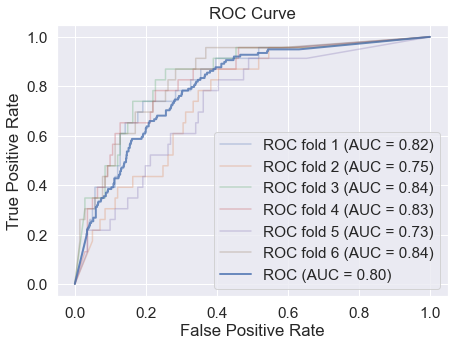

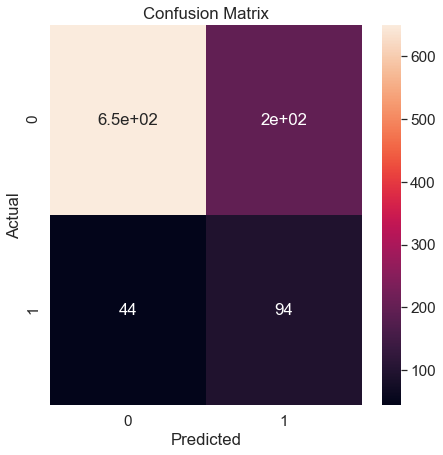

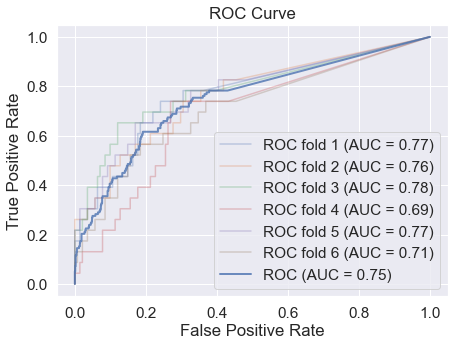

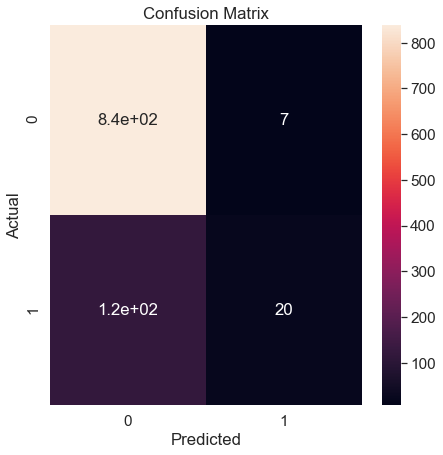

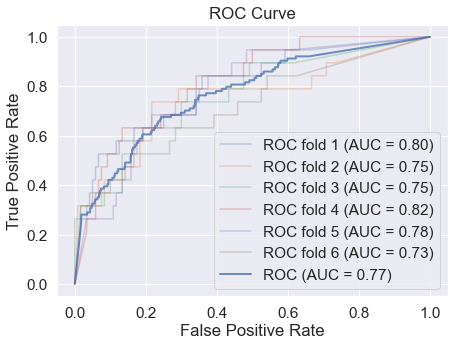

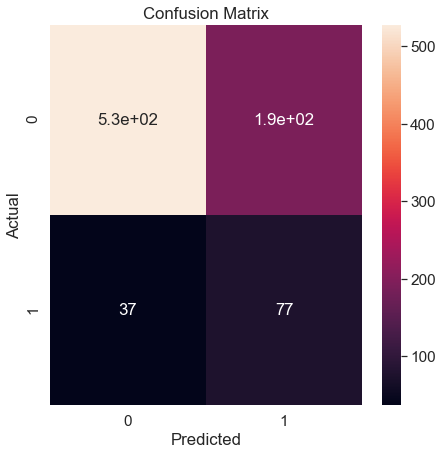

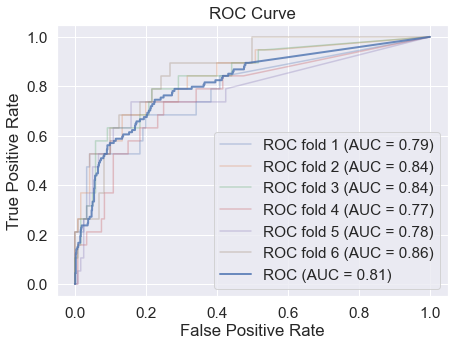

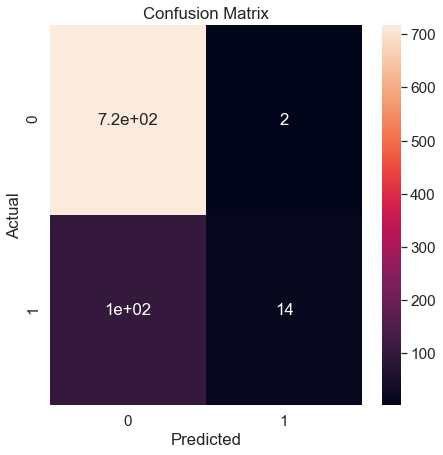

In [133]:
do_smote = True
neigh_time,neigh_auc, fpr_neigh, tpr_neigh, neigh_class_rep = perform_classification(neigh, merge_train, 2, do_smote, scaling=True)
do_smote = False
neigh_time_nosmote,neigh_auc_nosmote,_,_,neigh_class_rep_nosmote = perform_classification(neigh, merge_train, 2, do_smote, scaling=True)
do_smote = True
neigh_time_noout,neigh_auc_noout,_,_, neigh_class_rep_noout = perform_classification(neigh, merge_train_no_out, 2, do_smote, scaling=True)
do_smote = False
neigh_time_nosmote_noout,neigh_auc_nosmote_noout,_,_, neigh_class_rep_nosmote_noout = perform_classification(neigh, merge_train_no_out, 2, do_smote, scaling=True)

### Gradient Boosting

In [134]:
gb_clf = GradientBoostingClassifier(criterion="friedman_mse", learning_rate=0.2, loss="deviance", max_depth=5, max_features="log2", min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=10, subsample=1.0)

In [135]:
parameter_grid = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.05, 0.15, 0.2],
    "min_samples_split": [0.1, 0.5, 0.75, 2, 3, 4],
    "min_samples_leaf": np.linspace(0.1, 2, 5),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse", "squared_error"],
    "subsample":[0.5, 0.8, 1.0],
    "n_estimators":[10],
    "random_state":[42]
    }

#grid_search(gb_clf, 3, parameter_grid)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.89       846
           1       0.38      0.55      0.45       138

    accuracy                           0.81       984
   macro avg       0.65      0.70      0.67       984
weighted avg       0.84      0.81      0.82       984

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       846
           1       0.71      0.12      0.21       138

    accuracy                           0.87       984
   macro avg       0.79      0.56      0.57       984
weighted avg       0.85      0.87      0.83       984

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       720
           1       0.46      0.67      0.55       114

    accuracy                           0.85       834
   macro avg       0.70      0.77      0.73       834
weigh

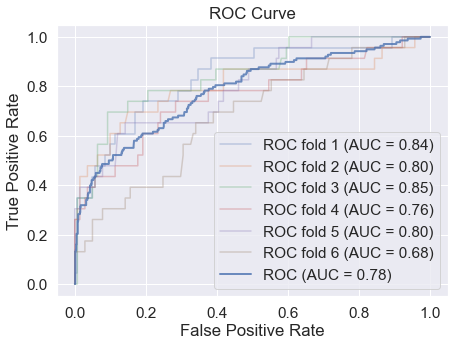

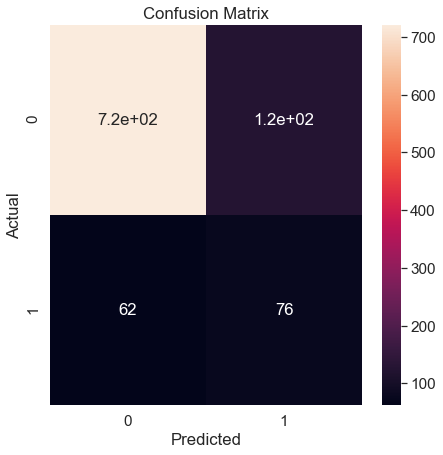

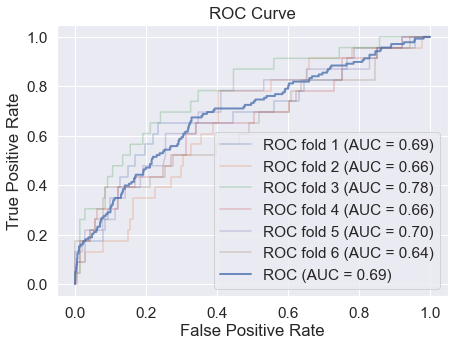

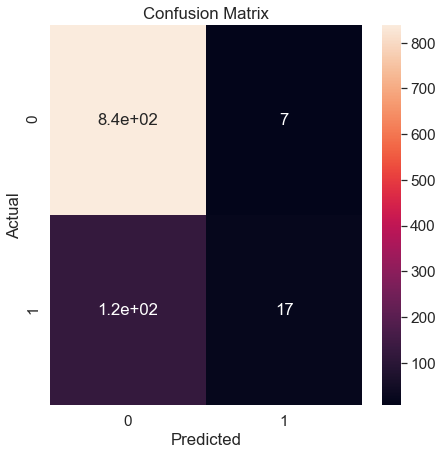

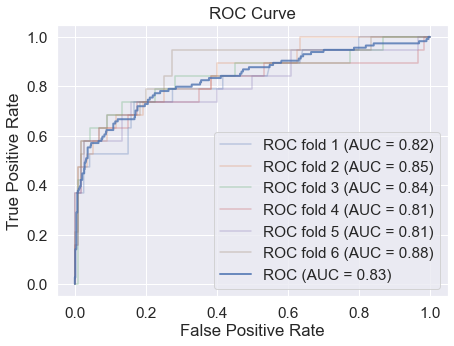

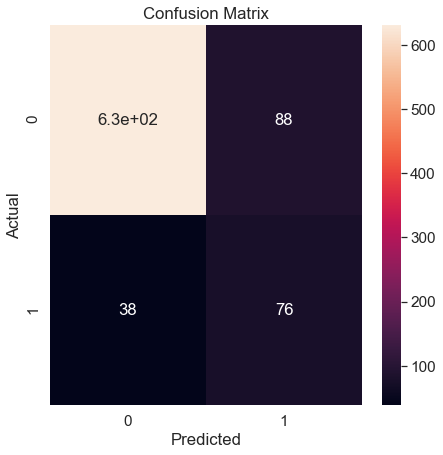

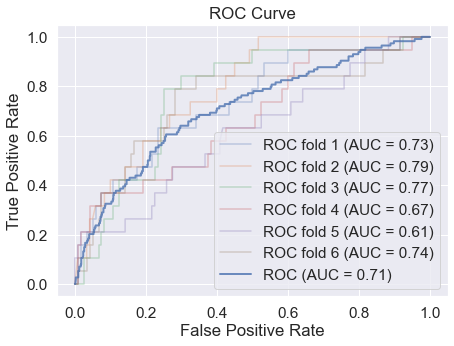

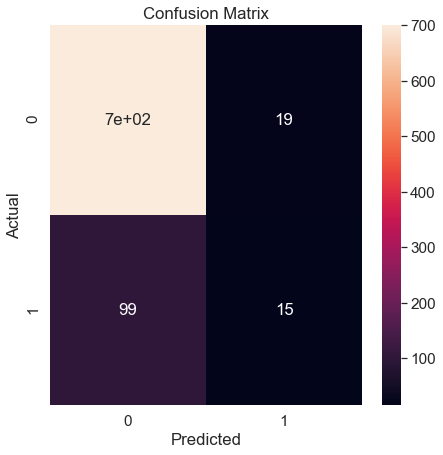

In [136]:
do_smote = True
gbclf_time,gbclf_auc, fpr_gbclf, tpr_gbclf, gbclf_class_rep = perform_classification(gb_clf, merge_train, 2, do_smote, scaling=False)
do_smote = False
gbclf_time_nosmote,gbclf_auc_nosmote,_,_, gbclf_class_rep_nosmote = perform_classification(gb_clf, merge_train, 2, do_smote, scaling=False)
do_smote = True
gbclf_time_noout,gbclf_auc_noout,_,_, gbclf_class_rep_noout = perform_classification(gb_clf, merge_train_no_out, 2, do_smote, scaling=False)
do_smote = False
gbclf_time_nosmote_noout,gbclf_auc_nosmote_noout,_,_, gbclf_class_rep_nosmote_noout = perform_classification(gb_clf, merge_train_no_out, 2, do_smote, scaling=False)

### Naïve Bayes

In [137]:
nb_clf = ComplementNB()

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.35      0.51       846
           1       0.20      0.98      0.33       138

    accuracy                           0.44       984
   macro avg       0.59      0.66      0.42       984
weighted avg       0.88      0.44      0.49       984

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.39      0.56       846
           1       0.20      0.95      0.34       138

    accuracy                           0.47       984
   macro avg       0.59      0.67      0.45       984
weighted avg       0.87      0.47      0.53       984

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.39      0.56       720
           1       0.20      0.96      0.33       114

    accuracy                           0.47       834
   macro avg       0.59      0.68      0.45       834
weigh

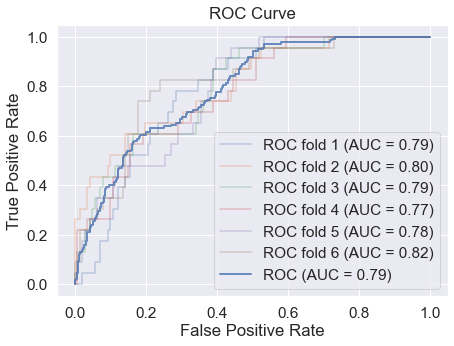

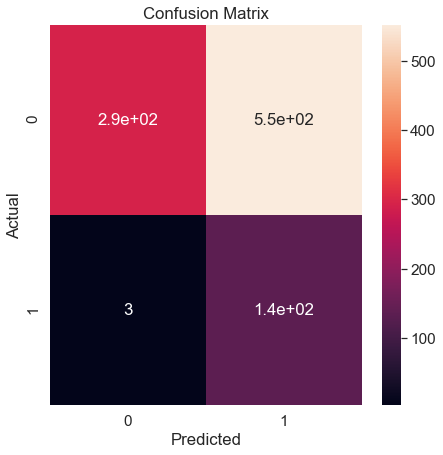

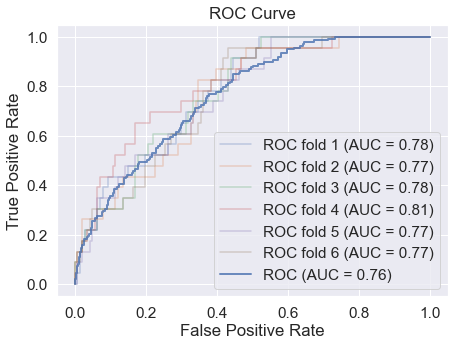

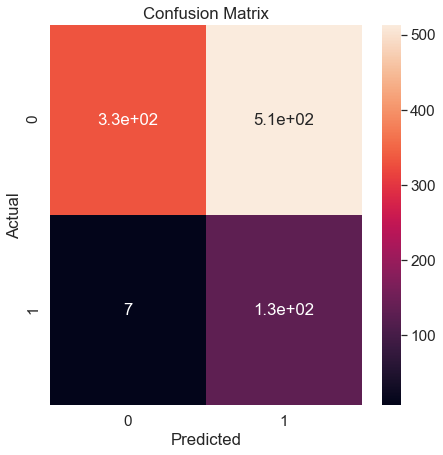

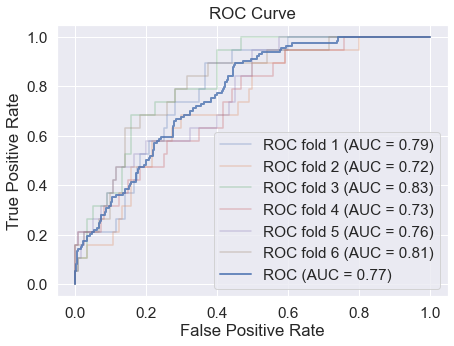

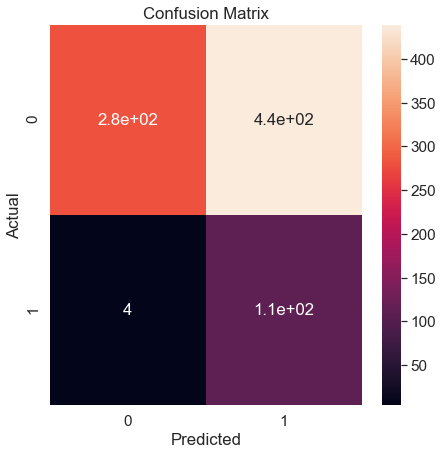

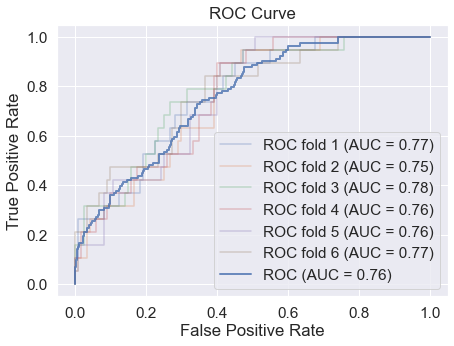

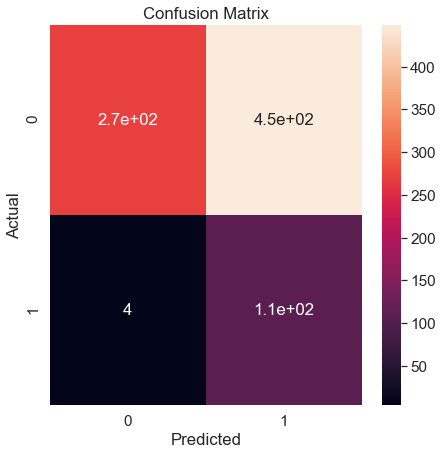

In [138]:
do_smote = True
nbclf_time,nbclf_auc, fpr_nbclf, tpr_nbclf, nbclf_class_rep = perform_classification(nb_clf, merge_train, 2, do_smote, scaling=False)
do_smote = False
nbclf_time_nosmote,nbclf_auc_nosmote,_,_, nbclf_class_rep_nosmote = perform_classification(nb_clf, merge_train, 2, do_smote, scaling=False)
do_smote = True
nbclf_time_noout,nbclf_auc_noout,_,_, nbclf_class_rep_noout = perform_classification(nb_clf, merge_train_no_out, 2, do_smote, scaling=False)
do_smote = False
nbclf_time_nosmote_noout,nbclf_auc_nosmote_noout,_,_, nbclf_class_rep_nosmote_noout = perform_classification(nb_clf, merge_train_no_out, 2, do_smote, scaling=False)

### Voting Classifier

In [139]:
vot_clf = VotingClassifier(estimators = [('SVC',svc_clf), ('NAIVE',nb_clf), ('Random',rfc)], voting ='soft')

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       846
           1       0.39      0.61      0.47       138

    accuracy                           0.81       984
   macro avg       0.66      0.73      0.68       984
weighted avg       0.85      0.81      0.83       984

Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       846
           1       0.96      0.19      0.32       138

    accuracy                           0.89       984
   macro avg       0.92      0.59      0.63       984
weighted avg       0.89      0.89      0.85       984

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       720
           1       0.34      0.59      0.43       114

    accuracy                           0.79       834
   macro avg       0.63      0.70      0.65       834
weigh

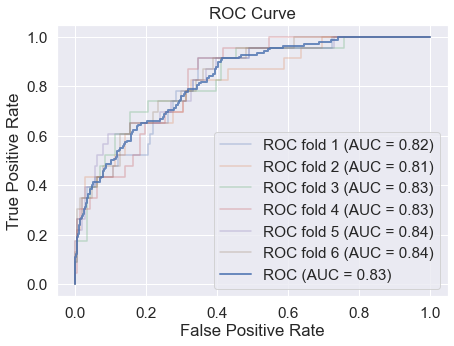

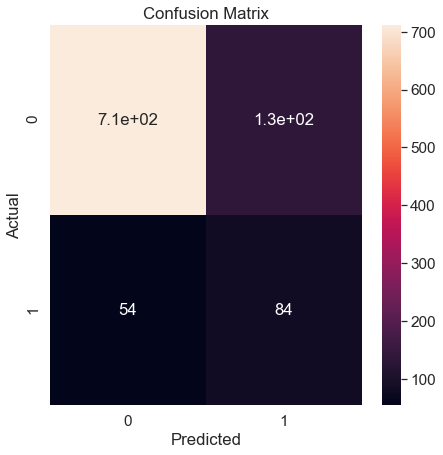

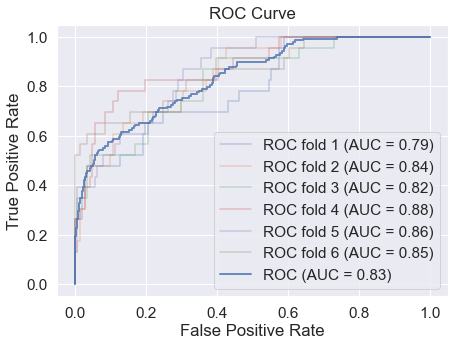

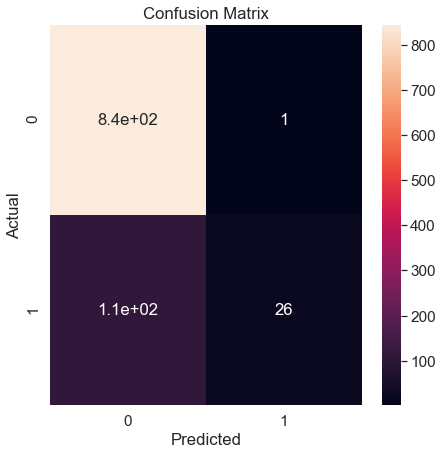

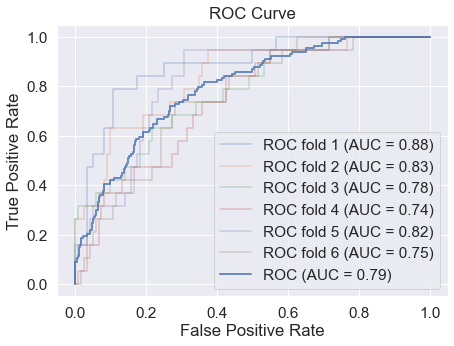

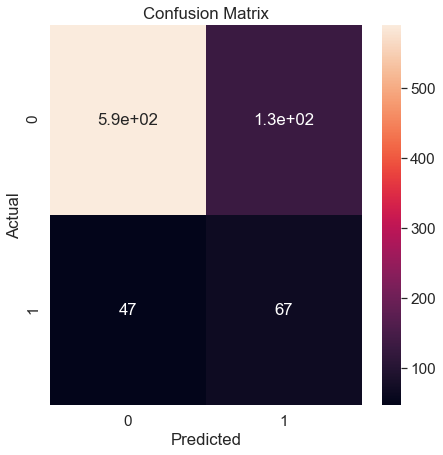

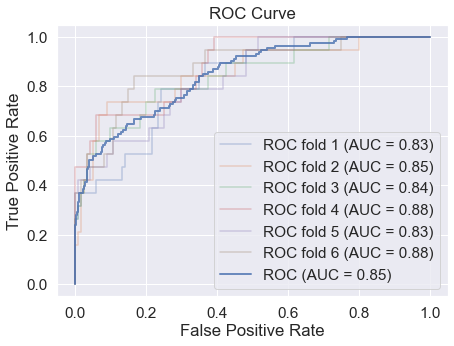

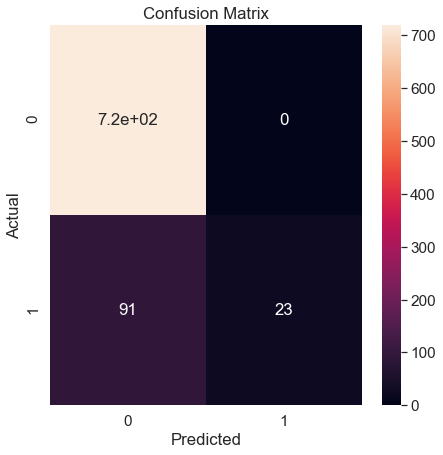

In [140]:
do_smote = True
votclf_time,votclf_auc, fpr_votclf, tpr_votclf, votclf_class_rep = perform_classification(vot_clf, merge_train, 2, do_smote, scaling=True)
do_smote = False
votclf_time_nosmote,votclf_auc_nosmote,_,_, votclf_class_rep_nosmote = perform_classification(vot_clf, merge_train, 2, do_smote, scaling=True)
do_smote = True
votclf_time_noout,votclf_auc_noout,_,_, votclf_class_rep_noout = perform_classification(vot_clf, merge_train_no_out, 2, do_smote, scaling=True)
do_smote = False
votclf_time_nosmote_noout,votclf_auc_nosmote_noout,_,_, votclf_class_rep_nosmote_noout = perform_classification(vot_clf, merge_train_no_out, 2, do_smote, scaling=True)

## Performance estimations

In [141]:
table = [["Classifier", "Outlier Removal", "SMOTE", "ROC AUC", "Average Precision", "Average Recall", "Execution Time"],
         ["SVM", "Yes", "Yes", "{:.2f}".format(svm_auc), "{:.2f}".format(svm_class_rep["weighted avg"]["precision"]), "{:.2f}".format(svm_class_rep["weighted avg"]["recall"]), "{:.2f}".format(svm_time) ],
         ["SVM", "Yes", "No", "{:.2f}".format(svm_auc_nosmote), "{:.2f}".format(svm_class_rep_nosmote["weighted avg"]["precision"]), "{:.2f}".format(svm_class_rep_nosmote["weighted avg"]["recall"]), "{:.2f}".format(svm_time_nosmote) ],
         ["SVM", "No", "Yes", "{:.2f}".format(svm_auc_noout), "{:.2f}".format(svm_class_rep_noout["weighted avg"]["precision"]), "{:.2f}".format(svm_class_rep_noout["weighted avg"]["recall"]), "{:.2f}".format(svm_time_noout) ],
         ["SVM", "No", "No", "{:.2f}".format(svm_auc_nosmote_noout), "{:.2f}".format(svm_class_rep_nosmote_noout["weighted avg"]["precision"]), "{:.2f}".format(svm_class_rep_nosmote_noout["weighted avg"]["recall"]), "{:.2f}".format(svm_time_nosmote_noout) ],         
         ["Logistic Regression", "Yes", "Yes", "{:.2f}".format(logreg_auc), "{:.2f}".format(logreg_class_rep["weighted avg"]["precision"]), "{:.2f}".format(logreg_class_rep["weighted avg"]["recall"]), "{:.2f}".format(logreg_time) ],
         ["Logistic Regression", "Yes", "No", "{:.2f}".format(logreg_auc_nosmote), "{:.2f}".format(logreg_class_rep_nosmote["weighted avg"]["precision"]), "{:.2f}".format(logreg_class_rep_nosmote["weighted avg"]["recall"]), "{:.2f}".format(logreg_time_nosmote) ],
         ["Logistic Regression", "No", "Yes", "{:.2f}".format(logreg_auc_noout), "{:.2f}".format(logreg_class_rep_noout["weighted avg"]["precision"]), "{:.2f}".format(logreg_class_rep_noout["weighted avg"]["recall"]), "{:.2f}".format(logreg_time_noout) ],
         ["Logistic Regression", "No", "No", "{:.2f}".format(logreg_auc_nosmote_noout), "{:.2f}".format(logreg_class_rep_nosmote_noout["weighted avg"]["precision"]), "{:.2f}".format(logreg_class_rep_nosmote_noout["weighted avg"]["recall"]), "{:.2f}".format(logreg_time_nosmote_noout) ],
         ["Decistion Tree", "Yes", "Yes", "{:.2f}".format(dtc_auc), "{:.2f}".format(dtc_class_rep["weighted avg"]["precision"]), "{:.2f}".format(dtc_class_rep["weighted avg"]["recall"]), "{:.2f}".format(dtc_time) ],
         ["Decistion Tree", "Yes", "No", "{:.2f}".format(dtc_auc_nosmote), "{:.2f}".format(dtc_class_rep_nosmote["weighted avg"]["precision"]), "{:.2f}".format(dtc_class_rep_nosmote["weighted avg"]["recall"]), "{:.2f}".format(dtc_time_nosmote) ],
         ["Decistion Tree", "No", "Yes", "{:.2f}".format(dtc_auc_noout), "{:.2f}".format(dtc_class_rep_noout["weighted avg"]["precision"]), "{:.2f}".format(dtc_class_rep_noout["weighted avg"]["recall"]), "{:.2f}".format(dtc_time_noout) ],
         ["Decistion Tree", "No", "No", "{:.2f}".format(dtc_auc_nosmote_noout), "{:.2f}".format(dtc_class_rep_nosmote_noout["weighted avg"]["precision"]), "{:.2f}".format(dtc_class_rep_nosmote_noout["weighted avg"]["recall"]), "{:.2f}".format(dtc_time_nosmote_noout) ],
         ["Random Forest", "Yes", "Yes", "{:.2f}".format(rfc_auc), "{:.2f}".format(rfc_class_rep["weighted avg"]["precision"]), "{:.2f}".format(rfc_class_rep["weighted avg"]["recall"]), "{:.2f}".format(rfc_time) ],
         ["Random Forest", "Yes", "No", "{:.2f}".format(rfc_auc_nosmote), "{:.2f}".format(rfc_class_rep_nosmote["weighted avg"]["precision"]), "{:.2f}".format(rfc_class_rep_nosmote["weighted avg"]["recall"]), "{:.2f}".format(rfc_time_nosmote) ],
         ["Random Forest", "No", "Yes", "{:.2f}".format(rfc_auc_noout), "{:.2f}".format(rfc_class_rep_noout["weighted avg"]["precision"]), "{:.2f}".format(rfc_class_rep_noout["weighted avg"]["recall"]), "{:.2f}".format(rfc_time_noout) ],
         ["Random Forest", "No", "No", "{:.2f}".format(rfc_auc_nosmote_noout), "{:.2f}".format(rfc_class_rep_nosmote_noout["weighted avg"]["precision"]), "{:.2f}".format(rfc_class_rep_nosmote_noout["weighted avg"]["recall"]), "{:.2f}".format(rfc_time_nosmote_noout) ],
         ["Random Forest With Embedded Selection", "No", "Yes", "{:.2f}".format(rfc_auc_wrap), "{:.2f}".format(rfc_wrap_class_rep["weighted avg"]["precision"]), "{:.2f}".format(rfc_wrap_class_rep["weighted avg"]["recall"]), "{:.2f}".format(rfc_time_wrap) ],
         ["Random Forest With Embedded Selection", "No", "No", "{:.2f}".format(rfc_auc_nosmote_wrap), "{:.2f}".format(rfc_wrap_class_rep_nosmote["weighted avg"]["precision"]), "{:.2f}".format(rfc_wrap_class_rep_nosmote["weighted avg"]["recall"]), "{:.2f}".format(rfc_time_nosmote_wrap) ],
         ["Gradient Boosting", "Yes", "Yes", "{:.2f}".format(gbclf_auc), "{:.2f}".format(gbclf_class_rep["weighted avg"]["precision"]), "{:.2f}".format(gbclf_class_rep["weighted avg"]["recall"]), "{:.2f}".format(gbclf_time) ],
         ["Gradient Boosting", "Yes", "No", "{:.2f}".format(gbclf_auc_nosmote), "{:.2f}".format(gbclf_class_rep_nosmote["weighted avg"]["precision"]), "{:.2f}".format(gbclf_class_rep_nosmote["weighted avg"]["recall"]), "{:.2f}".format(gbclf_time_nosmote) ],
         ["Gradient Boosting", "No", "Yes", "{:.2f}".format(gbclf_auc_noout), "{:.2f}".format(gbclf_class_rep_noout["weighted avg"]["precision"]), "{:.2f}".format(gbclf_class_rep_noout["weighted avg"]["recall"]), "{:.2f}".format(gbclf_time_noout) ],
         ["Gradient Boosting", "No", "No", "{:.2f}".format(gbclf_auc_nosmote_noout), "{:.2f}".format(gbclf_class_rep_nosmote_noout["weighted avg"]["precision"]), "{:.2f}".format(gbclf_class_rep_nosmote_noout["weighted avg"]["recall"]), "{:.2f}".format(gbclf_time_nosmote_noout) ],
         ["Naive Bayes", "Yes", "Yes", "{:.2f}".format(nbclf_auc), "{:.2f}".format(nbclf_class_rep["weighted avg"]["precision"]), "{:.2f}".format(nbclf_class_rep["weighted avg"]["recall"]), "{:.2f}".format(nbclf_time) ],
         ["Naive Bayes", "Yes", "No", "{:.2f}".format(nbclf_auc_nosmote), "{:.2f}".format(nbclf_class_rep_nosmote["weighted avg"]["precision"]), "{:.2f}".format(nbclf_class_rep_nosmote["weighted avg"]["recall"]), "{:.2f}".format(nbclf_time_nosmote) ],
         ["Naive Bayes", "No", "Yes", "{:.2f}".format(nbclf_auc_noout), "{:.2f}".format(nbclf_class_rep_noout["weighted avg"]["precision"]), "{:.2f}".format(nbclf_class_rep_noout["weighted avg"]["recall"]), "{:.2f}".format(nbclf_time_noout) ],
         ["Naive Bayes", "No", "No", "{:.2f}".format(nbclf_auc_nosmote_noout), "{:.2f}".format(nbclf_class_rep_nosmote_noout["weighted avg"]["precision"]), "{:.2f}".format(nbclf_class_rep_nosmote_noout["weighted avg"]["recall"]), "{:.2f}".format(nbclf_time_nosmote_noout) ],
         ["Voting", "Yes", "Yes", "{:.2f}".format(votclf_auc), "{:.2f}".format(votclf_class_rep["weighted avg"]["precision"]), "{:.2f}".format(votclf_class_rep["weighted avg"]["recall"]), "{:.2f}".format(votclf_time) ],
         ["Voting", "Yes", "No", "{:.2f}".format(votclf_auc_nosmote), "{:.2f}".format(votclf_class_rep_nosmote["weighted avg"]["precision"]), "{:.2f}".format(votclf_class_rep_nosmote["weighted avg"]["recall"]), "{:.2f}".format(votclf_time_nosmote) ],
         ["Voting", "No", "Yes", "{:.2f}".format(votclf_auc_noout), "{:.2f}".format(votclf_class_rep_noout["weighted avg"]["precision"]), "{:.2f}".format(votclf_class_rep_noout["weighted avg"]["recall"]), "{:.2f}".format(votclf_time_noout) ],
         ["Voting", "No", "No", "{:.2f}".format(votclf_auc_nosmote_noout), "{:.2f}".format(votclf_class_rep_nosmote_noout["weighted avg"]["precision"]), "{:.2f}".format(votclf_class_rep_nosmote_noout["weighted avg"]["recall"]), "{:.2f}".format(votclf_time_nosmote_noout) ],
        ]

df_comparison_table = pd.DataFrame({"Classifier":[], "Outlier Removal": [], "SMOTE":[], "ROC AUC":[], "Average Precision":[], "Average Recall":[], "Execution Time":[]})
for i in range(1, len(table)):
        df_comparison_table.loc[i-1] = table[i]
df_comparison_table = df_comparison_table.set_index(['Classifier', "Outlier Removal", "SMOTE"])
df_comparison_table

ROC AUC  \
Classifier                            Outlier Removal SMOTE           
SVM                                   Yes             Yes      0.79   
                                                      No       0.72   
                                      No              Yes      0.81   
                                                      No       0.78   
Logistic Regression                   Yes             Yes      0.78   
                                                      No       0.81   
                                      No              Yes      0.80   
                                                      No       0.82   
Decistion Tree                        Yes             Yes      0.73   
                                                      No       0.73   
                                      No              Yes      0.68   
                                                      No       0.72   
Random Forest                         Yes             Yes      0.80   
                                                      No       0.76   
                                      No              Yes      0.85   
                                                      No       0.81   
Random Forest With Embedded Selection No              Yes      1.00   
                                                      No       1.00   
Gradient Boosting                     Yes             Yes      0.78   
                                                      No       0.69   
                                      No              Yes      0.83   
                                                      No       0.71   
Naive Bayes                           Yes             Yes      0.79   
                                                      No       0.76   
                                      No              Yes      0.77   
                                                      No       0.76   
Voting                                Yes             Yes      0.83   
                                                      No       0.83   
                                      No              Yes      0.79   
                                                      No       0.85   

                                                            Average Precision  \
Classifier                            Outlier Removal SMOTE                     
SVM                                   Yes             Yes                0.84   
                                                      No                 0.90   
                                      No              Yes                0.84   
                                                      No                 0.90   
Logistic Regression                   Yes             Yes                0.83   
                                                      No                 0.85   
                                      No              Yes                0.84   
                                                      No                 0.88   
Decistion Tree                        Yes             Yes                0.83   
                                                      No                 0.87   
                                      No              Yes                0.82   
                                                      No                 0.87   
Random Forest                         Yes             Yes                0.85   
                                                      No                 0.89   
                                      No              Yes                0.87   
                                                      No                 0.91   
Random Forest With Embedded Selection No              Yes                1.00   
                                                      No                 1.00   
Gradient Boosting                     Yes             Yes                0.84   
                                                      No                 0.85   
     

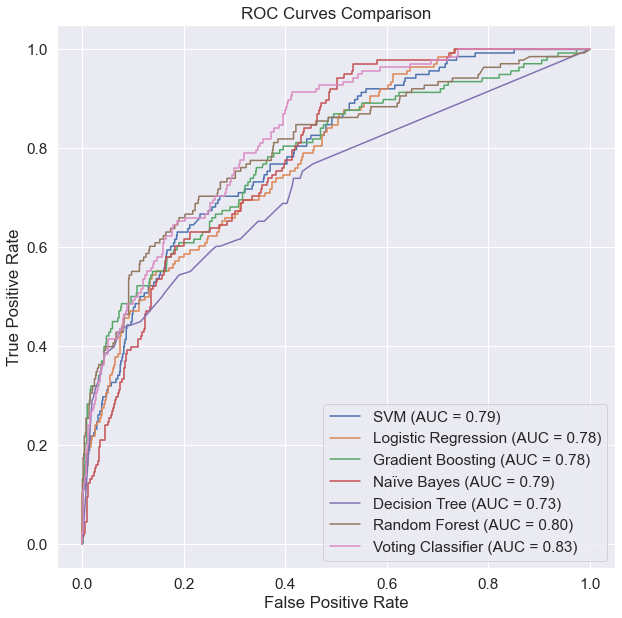

In [142]:
models_curves_data = [
    ("SVM", fpr_svm, tpr_svm),
    ("Logistic Regression", fpr_logreg, tpr_logreg),
    ("Gradient Boosting", fpr_gbclf, tpr_gbclf),
    ('Naïve Bayes', fpr_nbclf, tpr_nbclf),
    ('Decision Tree', fpr_dtc, tpr_dtc),
    ('Random Forest', fpr_rfc, tpr_rfc),
    ('Voting Classifier', fpr_votclf, tpr_votclf)
]

fig, ax = plt.subplots(figsize=(10,10))

for name, fpr, tpr in models_curves_data:  
    ax.plot(fpr, tpr,
                 label='{} (AUC = {:.2f})'.format(name, auc(fpr, tpr)))
    ax.legend()
    
    
_ = ax.set_title('ROC Curves Comparison')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.show()

## Final Predictions 

In [143]:
merge_train = pd.read_csv("merge_train.csv")
merge_test = pd.read_csv("merge_test.csv")

submit_test(vot_clf, merge_train, merge_test, column=1, do_smote=False, scaling=True, probs=True)

       Id  Predicted
0    5895   0.189358
1    7122   0.808569
2    6173   0.246764
3    6142   0.060978
4    5358   0.286458
..    ...        ...
349  4989   0.304320
350  5221   0.216315
351  6402   0.208806
352  5346   0.304203
353  6748   0.321229

[354 rows x 2 columns]


Id  Predicted
0    5895   0.189358
1    7122   0.808569
2    6173   0.246764
3    6142   0.060978
4    5358   0.286458
..    ...        ...
349  4989   0.304320
350  5221   0.216315
351  6402   0.208806
352  5346   0.304203
353  6748   0.321229

[354 rows x 2 columns]